In [1]:
%matplotlib notebook

In [2]:
SMPLSH_Dir = r'..\SMPL_Socks\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch
import numpy as np

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.nn.functional as F
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    HardPhongShader,
    BlendParams
)
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,
)
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import json
from os.path import join

import pyvista as pv

import Logger

In [3]:
def renderMesh(camRTs, cfg, mesh, renderer):
    images= []
    with torch.no_grad():
        for iCam in range(cfg.numCams):
            R=camRTs[iCam]['R']
            T=camRTs[iCam]['T']
            image = renderer.renderer(meshes_world=mesh, R=R, T=T).cpu().numpy()
            images.append(image)
    return images

def saveVTK(outFile, verts, smplshExampleMesh):
    smplshExampleMesh.points = verts
    smplshExampleMesh.save(outFile)

def visualize2DResults(images, refImgs, cfg, outImgFile=None, imgSizeInch=5):
    lossVal = 0
    fig, axs = plt.subplots(2, cfg.numCams)
    fig.set_size_inches(cfg.numCams*imgSizeInch, 2*imgSizeInch)
    with torch.no_grad():
        for iCam in range(cfg.numCams):
            imgAlpha = images[iCam][0,...,3]

            axs[0,iCam].imshow(imgAlpha, vmin=0.0, vmax=1.0)
            axs[0,iCam].axis('off')
            lossVal += np.sum((imgAlpha - refImgs[iCam][0,...,3]) ** 2)
            # Visualize 2D difference|
            imgAlphaDiff = np.abs(imgAlpha - refImgs[iCam][0, ..., 3])
            axs[1,iCam].imshow(imgAlphaDiff, vmin=0.0, vmax=1.0)
            axs[1,iCam].axis('off')
        if outImgFile is not None:
            plt.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)
    return lossVal

In [4]:
outFolder = r'F:\WorkingCopy2\2020_04_20_DifferentiableRendererTest\MultiViewNewLoss'

In [5]:
smplshData = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SmplshModel.npz'

smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

pose_size = 3 * 52
beta_size = 10

smplsh = smplsh_torch.SMPLModel(device, smplshData)
np.random.seed(9608)
pose = torch.from_numpy((np.random.rand(pose_size) - 0.5) * 0.4)\
        .type(torch.float64).to(device)
betas = torch.from_numpy((np.random.rand(beta_size) - 0.5) * 0.06) \
        .type(torch.float64).to(device)
trans = torch.from_numpy(np.zeros(3)).type(torch.float64).to(device)

verts = smplsh(betas, pose, trans).type(torch.float32)
# Initialize each vertex to be gray in color.
verts_rgb = ( 0.5 *torch.ones_like(verts))[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

smplshMesh = Meshes([verts], [smplsh.faces.to(device)], textures=textures)

smplshExampleMesh = pv.PolyData(smplshExampleMeshFile)

In [6]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 0.1
        s.plotStep = 10
        s.numCams = 8
        s.imgSize = 512
        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
        cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=cameras, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )

In [7]:
cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 10

# cfgRef.blurRange = 1e-1
cfgRef.blurRange = 0
cfgRef.imgSize = 2000

renderRef = Renderer(cfgRef)

cfg = RenderingCfg()
# cfg.sigma = 1e-3
cfg.noiseLevel = 0.1
# cfg.blurRange = 1e-1
cfg.sigma = 1e-5
cfg.blurRange = 1e-4
cfg.plotStep = 5
cfg.learningRate = 0.001

cfg.faces_per_pixel = 15
cfg.imgSize = 2000       
renderSynth = Renderer(cfg)

# cfg.faces_per_pixel = 20
# cfg.blurRange = 0
# cfg.blurRange = 1e-3
# cfg.sigma = 1e-5
# cfg.numCams = 16

In [8]:
expName = 'ParamNoBlur_Sig_' + str(cfg.sigma) +"NS_" + str(cfg.noiseLevel) +'_BRange' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) \
+ '_BdyOly' + str(cfg.bodyJointOnly) + '_NCams_' + str(cfg.numCams)
outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump(cfg.__dict__, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

outFolderMesh = join(outFolderForExperiment, 'Mesh')
os.makedirs(outFolderMesh, exist_ok=True)

F:\WorkingCopy2\2020_04_20_DifferentiableRendererTest\MultiViewNewLoss\ParamNoBlur_Sig_1e-05NS_0.1_BRange0.0001_Fpp15_BdyOlyFalse_NCams_8


In [17]:
camRTs = []
for iCam in range(cfg.numCams):
    R, T = look_at_view_transform(2.7, 0, 360 * iCam / cfg.numCams, device=device) 
    camRTs.append({'R':R, 'T':T})

<IPython.core.display.Javascript object>


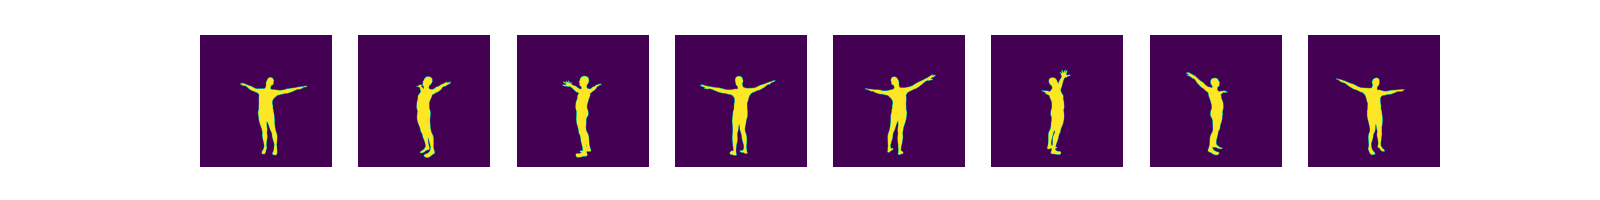

In [18]:
refImgs = []
fig, axs = plt.subplots(1, cfg.numCams)
fig.set_size_inches(cfg.numCams*2, 2)
with torch.no_grad():
    for iCam in range(cfg.numCams):
        R=camRTs[iCam]['R']
        T=camRTs[iCam]['T']
        image = renderRef.renderer(meshes_world=smplshMesh, R=R, T=T).cpu().numpy()
        image[np.where(image)] = 1
        axs[iCam].imshow(image[0,...,3], vmin=0.0, vmax=1.0)
        refImgs.append(image)
        axs[iCam].axis('off')
outTargetImgFile = join(outFolderForExperiment, 'TargetImg.png')
fig.savefig(outTargetImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)
outTargetImgFilePdf = join(outFolderForExperiment, 'TargetImg.pdf')
fig.savefig(outTargetImgFilePdf, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

saveVTK(join(outFolderMesh, 'Target.vtk'), verts.cpu().numpy(), smplshExampleMesh)

In [19]:


memStats = torch.cuda.memory_stats(device=device)
print('Before release: active_bytes.all.current:', memStats['active_bytes.all.current'] / 1000000)
torch.cuda.empty_cache()
memStats = torch.cuda.memory_stats(device=device)
print('After release: active_bytes.all.current:', memStats['active_bytes.all.current'] / 1000000)

Before release: active_bytes.all.current: 82.67264
After release: active_bytes.all.current: 82.67264


In [20]:
np.random.seed(cfg.randSeedPerturb)

if cfg.bodyJointOnly:
    numParameters = 3 * 22
else:
    numParameters = 3 * 52
# posePerturbed = torch.tensor(pose.cpu().numpy() + (np.random.rand(pose_size) - 0.5) * noiseLevel, dtype=torch.float64, device=device, requires_grad=True)
# Keep hand fixed
if cfg.bodyJointOnly:
    poseHands = pose[numBodyParameters:].clone().detach()
    poseParams = torch.tensor(pose[:numBodyParameters].cpu().numpy() + (np.random.rand(numBodyParameters) - 0.5) * cfg.noiseLevel, dtype=torch.float64, device=device, requires_grad=True)
    posePerturbed = torch.cat([poseParams, poseHands])
else:
    poseParams  = torch.tensor(pose.cpu().numpy() + (np.random.rand(pose_size) - 0.5) * cfg.noiseLevel, dtype=torch.float64, device=device, requires_grad=True)
    posePerturbed = poseParams

<IPython.core.display.Javascript object>


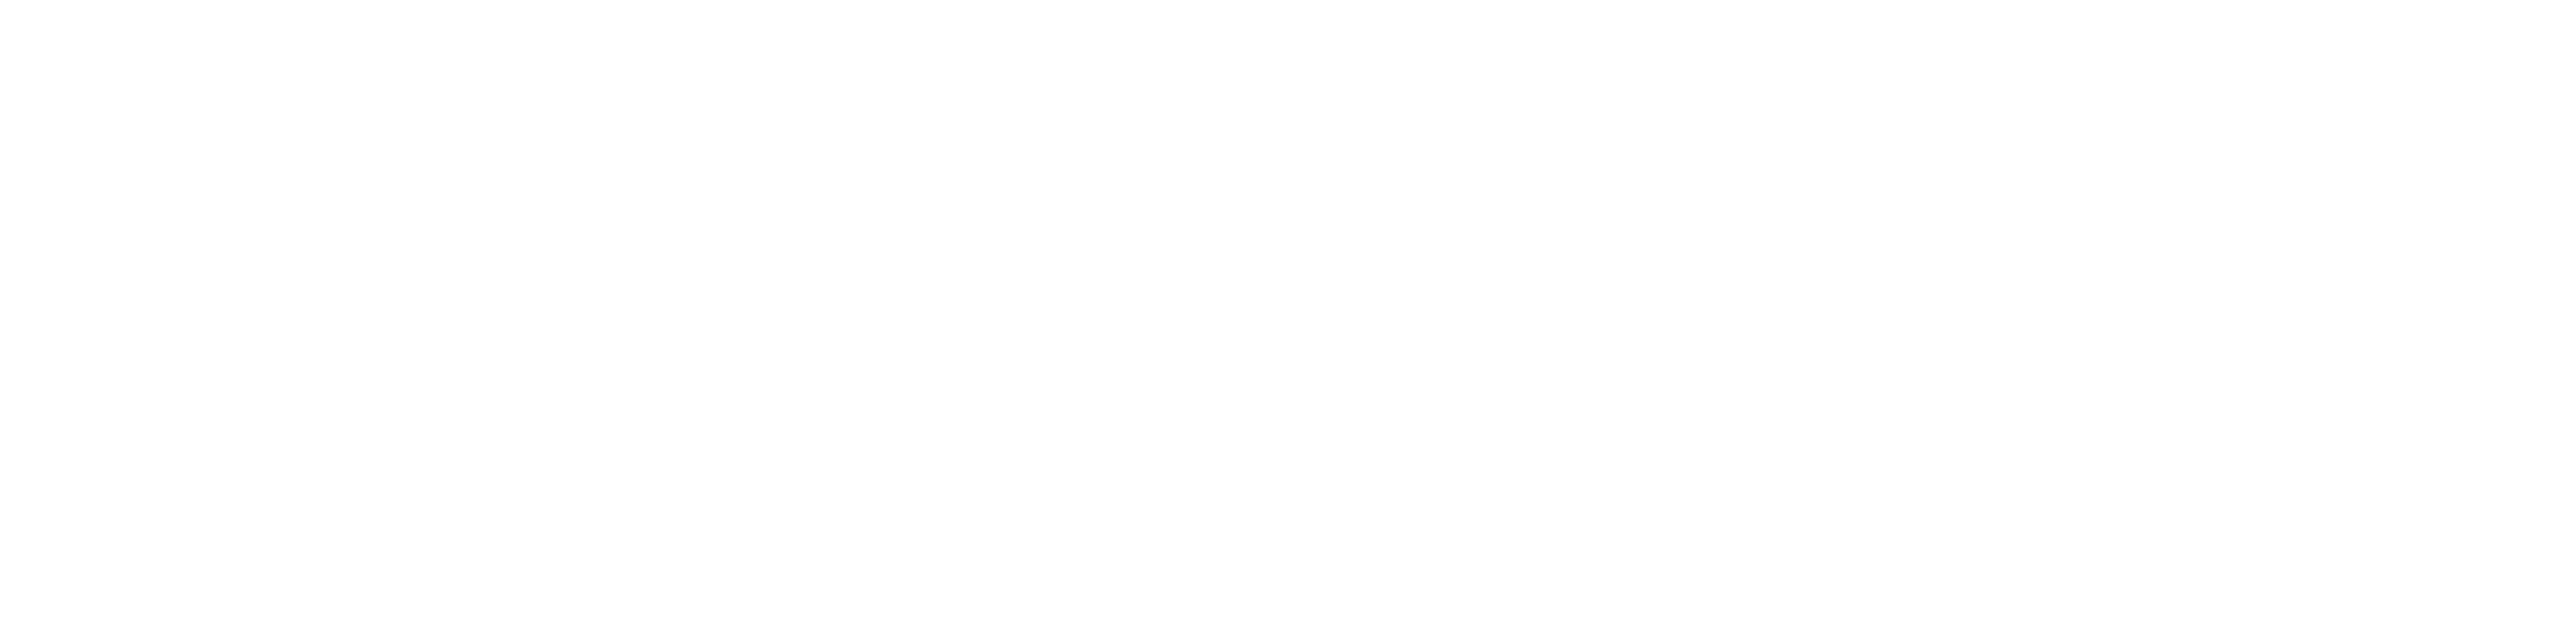

In [21]:
vertsPerturbed = smplsh(betas, posePerturbed, trans).type(torch.float32)
smplshMeshPerturbed = Meshes([vertsPerturbed], [smplsh.faces.to(device)], textures=textures)
images = renderMesh(camRTs, cfg, smplshMeshPerturbed, renderSynth)
        
outInitalImgFile = join(outFolderForExperiment, 'ZInitalImg.png')
# fig.savefig(outInitalImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)
loss = visualize2DResults(images, refImgs, cfg, outInitalImgFile)

In [22]:
# with torch.no_grad():
#     loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
print('Inital loss:', loss)
poses = []
losses = []

Inital loss: 379384.65625


In [23]:
optimizer = torch.optim.Adam([poseParams], lr=cfg.learningRate)

logFile = join(outFolderForExperiment, 'Logs.txt')
logger = Logger.configLogger(logFile)

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


2020-05-29 12:28:43,534 logger INFO loss 1.99, 3D Dis:  28.90mm, poseDiff: 0.13, MemUsed:180.06


<IPython.core.display.Javascript object>


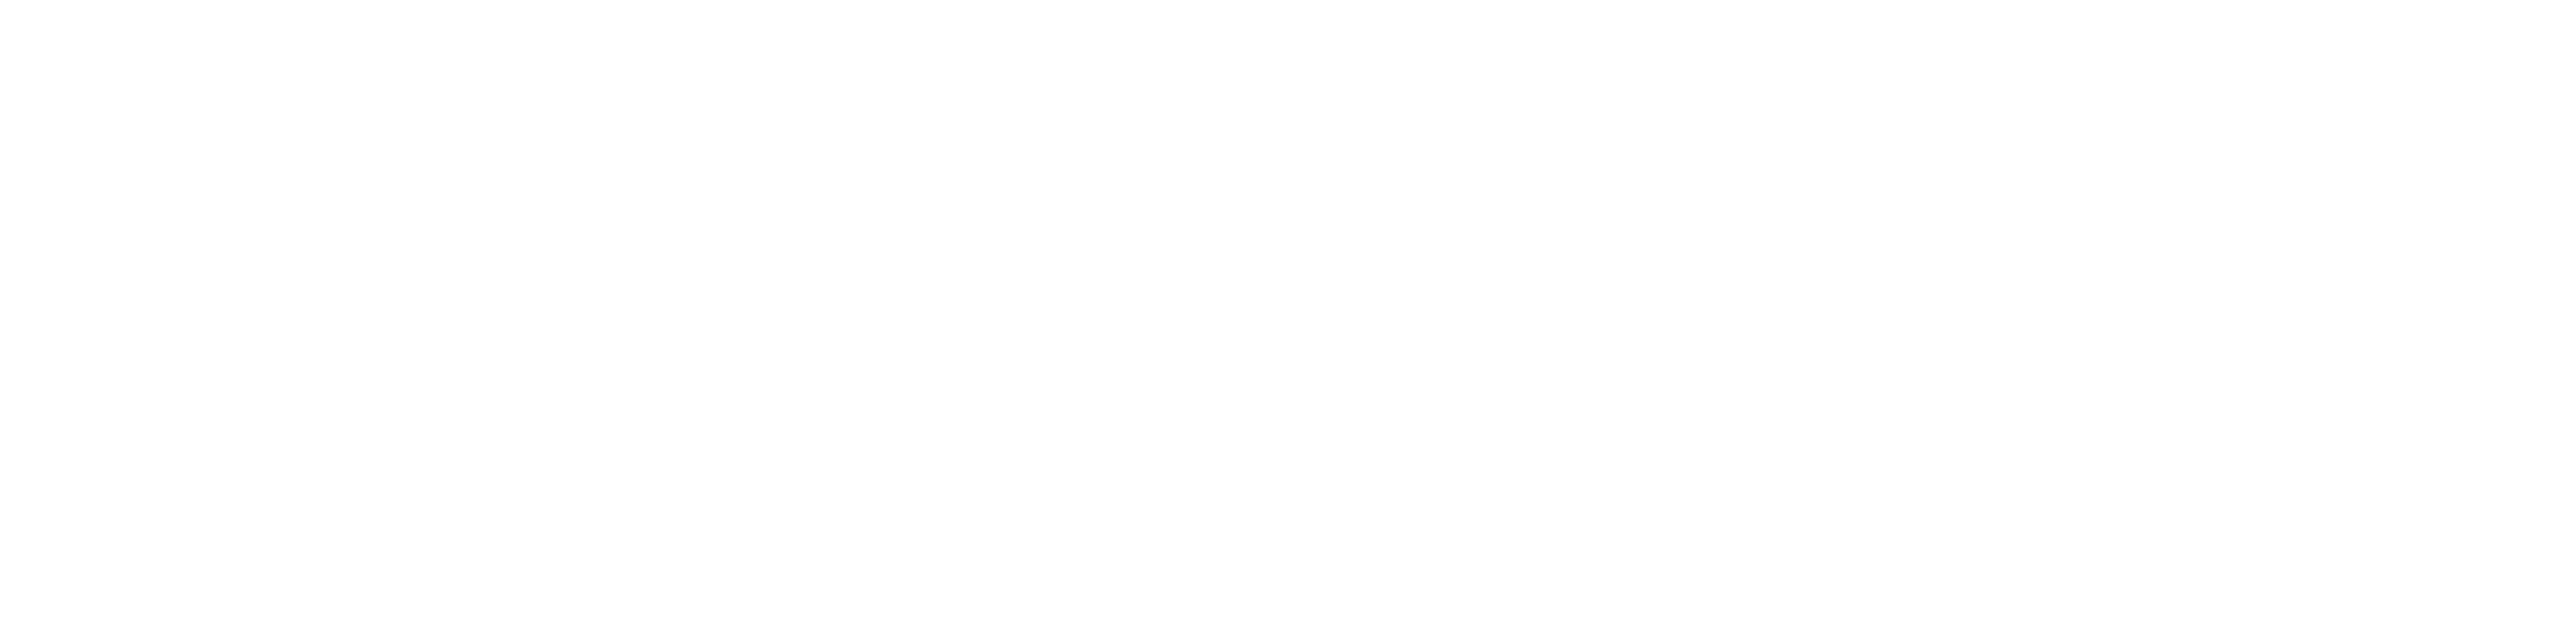

2020-05-29 12:29:15,697 logger INFO loss 1.90, 3D Dis:  26.01mm, poseDiff: 0.13, MemUsed:180.06
2020-05-29 12:29:25,445 logger INFO loss 1.81, 3D Dis:  23.26mm, poseDiff: 0.13, MemUsed:180.06
2020-05-29 12:29:35,224 logger INFO loss 1.72, 3D Dis:  20.71mm, poseDiff: 0.13, MemUsed:180.06
2020-05-29 12:29:45,014 logger INFO loss 1.65, 3D Dis:  18.47mm, poseDiff: 0.13, MemUsed:180.06
2020-05-29 12:29:54,937 logger INFO loss 1.58, 3D Dis:  16.70mm, poseDiff: 0.13, MemUsed:180.06


<IPython.core.display.Javascript object>


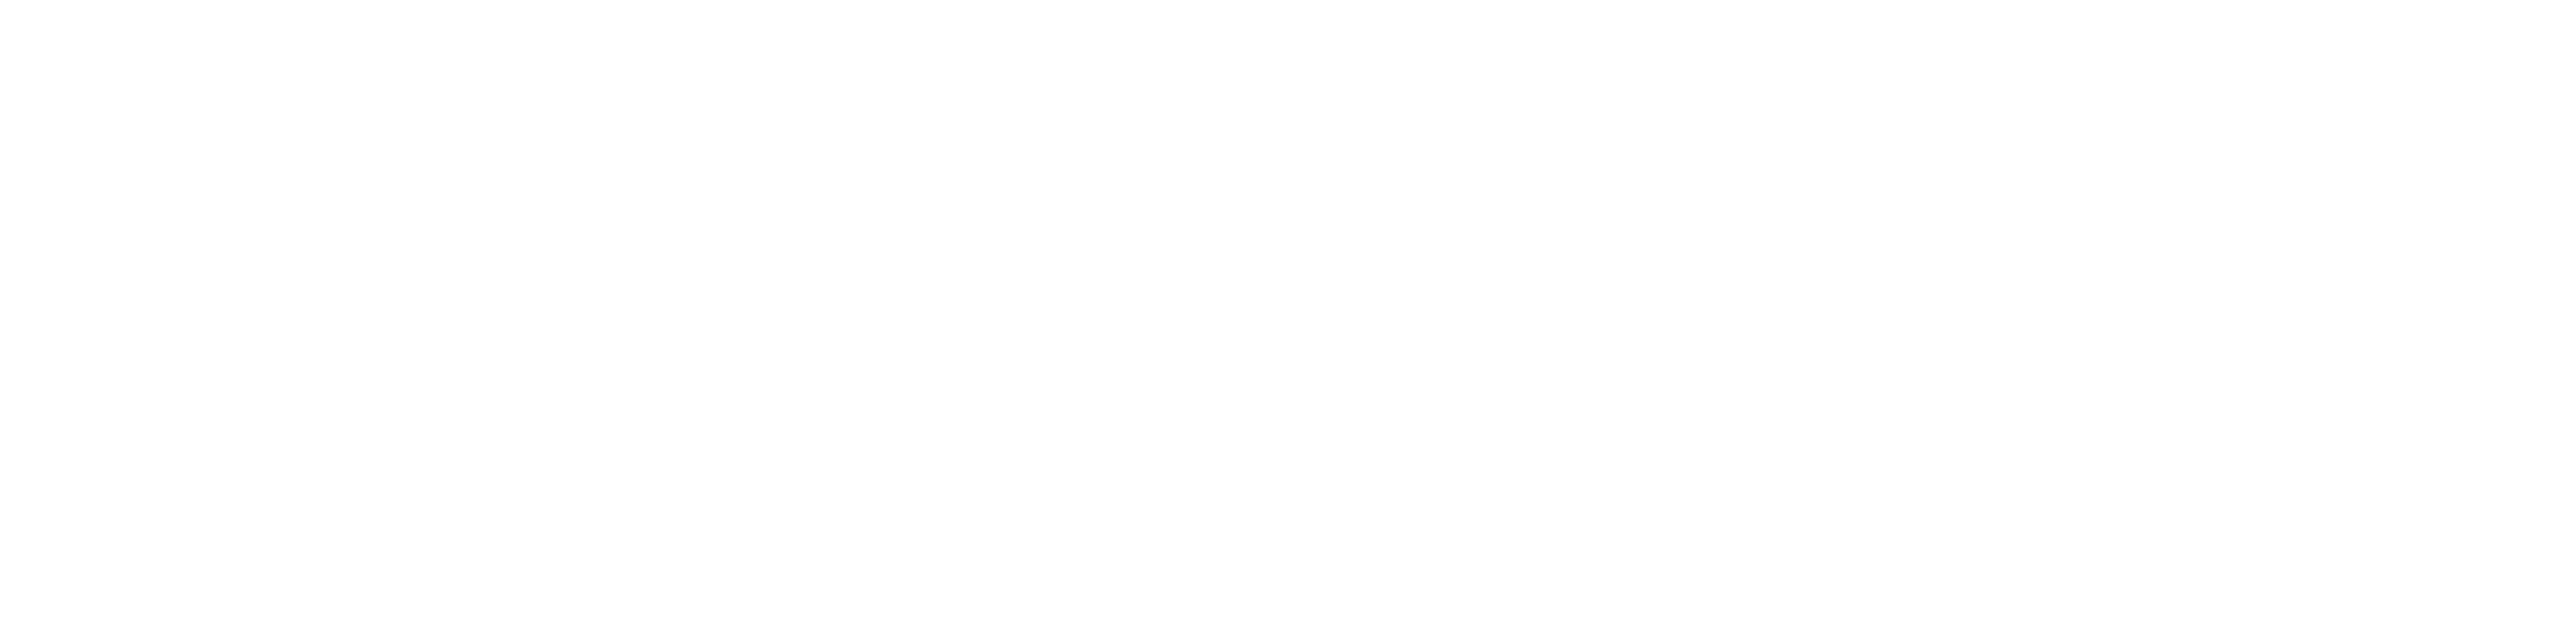

2020-05-29 12:30:27,606 logger INFO loss 1.52, 3D Dis:  15.60mm, poseDiff: 0.14, MemUsed:180.06
2020-05-29 12:30:37,487 logger INFO loss 1.50, 3D Dis:  15.23mm, poseDiff: 0.14, MemUsed:180.06
2020-05-29 12:30:47,523 logger INFO loss 1.49, 3D Dis:  15.42mm, poseDiff: 0.14, MemUsed:180.06
2020-05-29 12:30:57,503 logger INFO loss 1.49, 3D Dis:  15.74mm, poseDiff: 0.14, MemUsed:180.06
2020-05-29 12:31:07,684 logger INFO loss 1.49, 3D Dis:  15.85mm, poseDiff: 0.14, MemUsed:180.06


<IPython.core.display.Javascript object>


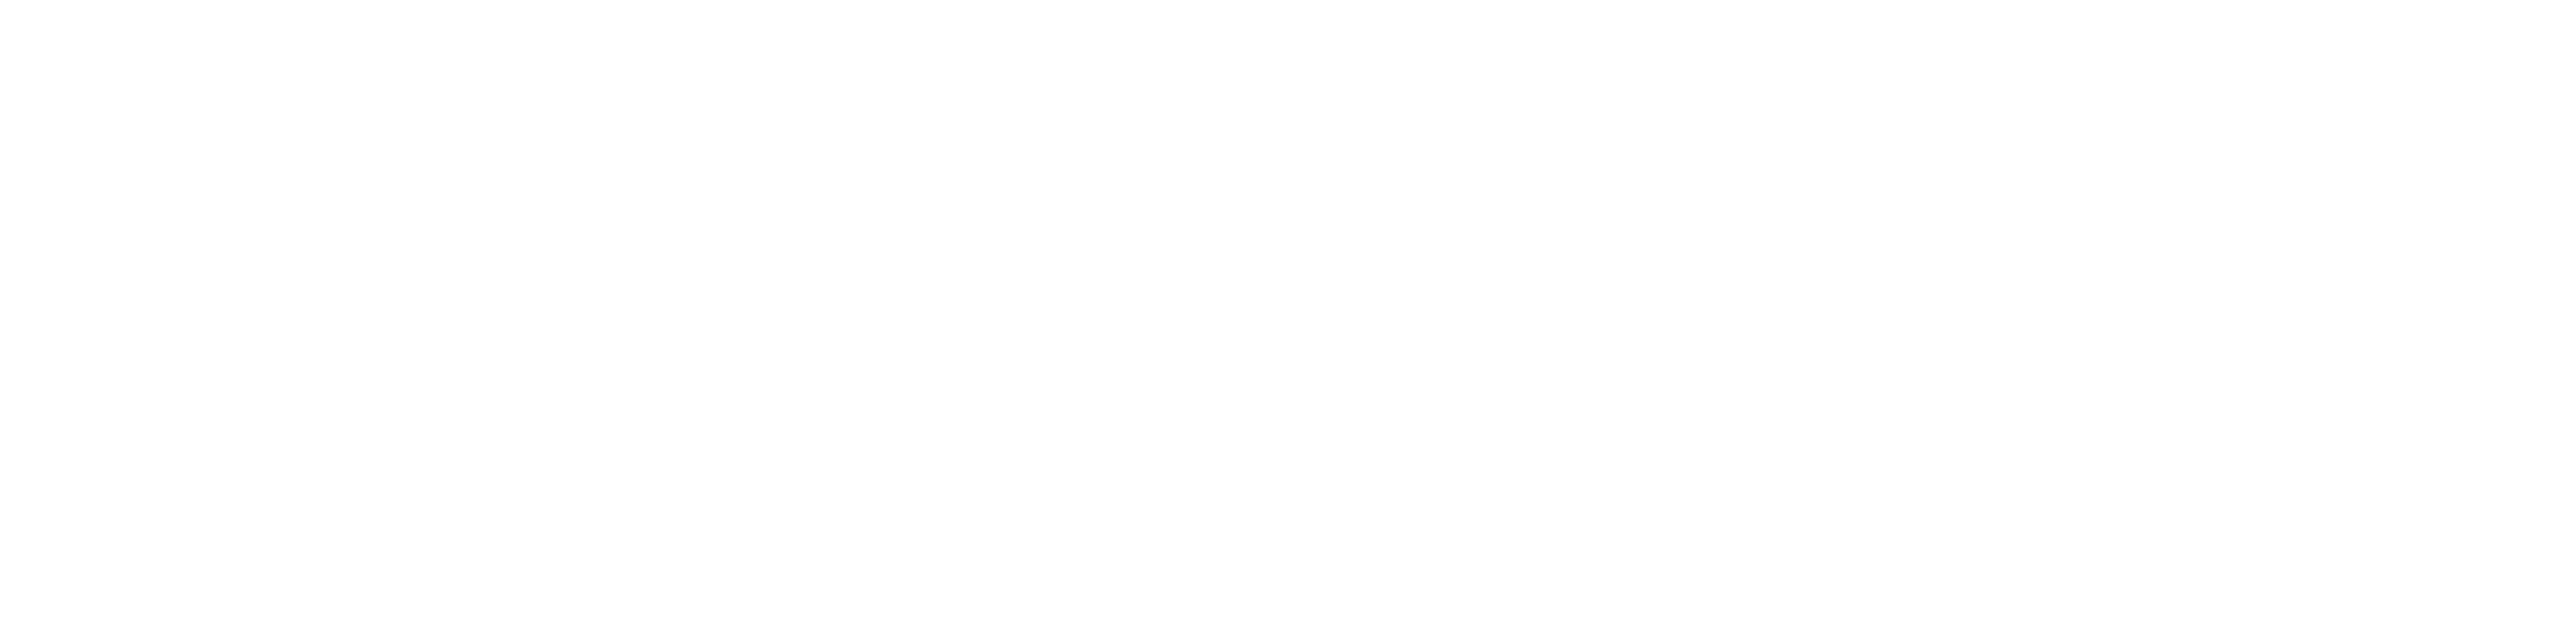

2020-05-29 12:31:40,836 logger INFO loss 1.48, 3D Dis:  15.63mm, poseDiff: 0.14, MemUsed:180.06
2020-05-29 12:31:50,792 logger INFO loss 1.46, 3D Dis:  15.10mm, poseDiff: 0.14, MemUsed:180.06
2020-05-29 12:32:00,846 logger INFO loss 1.44, 3D Dis:  14.26mm, poseDiff: 0.14, MemUsed:180.06
2020-05-29 12:32:11,420 logger INFO loss 1.41, 3D Dis:  13.17mm, poseDiff: 0.14, MemUsed:180.06
2020-05-29 12:32:21,639 logger INFO loss 1.37, 3D Dis:  11.90mm, poseDiff: 0.14, MemUsed:180.06


<IPython.core.display.Javascript object>


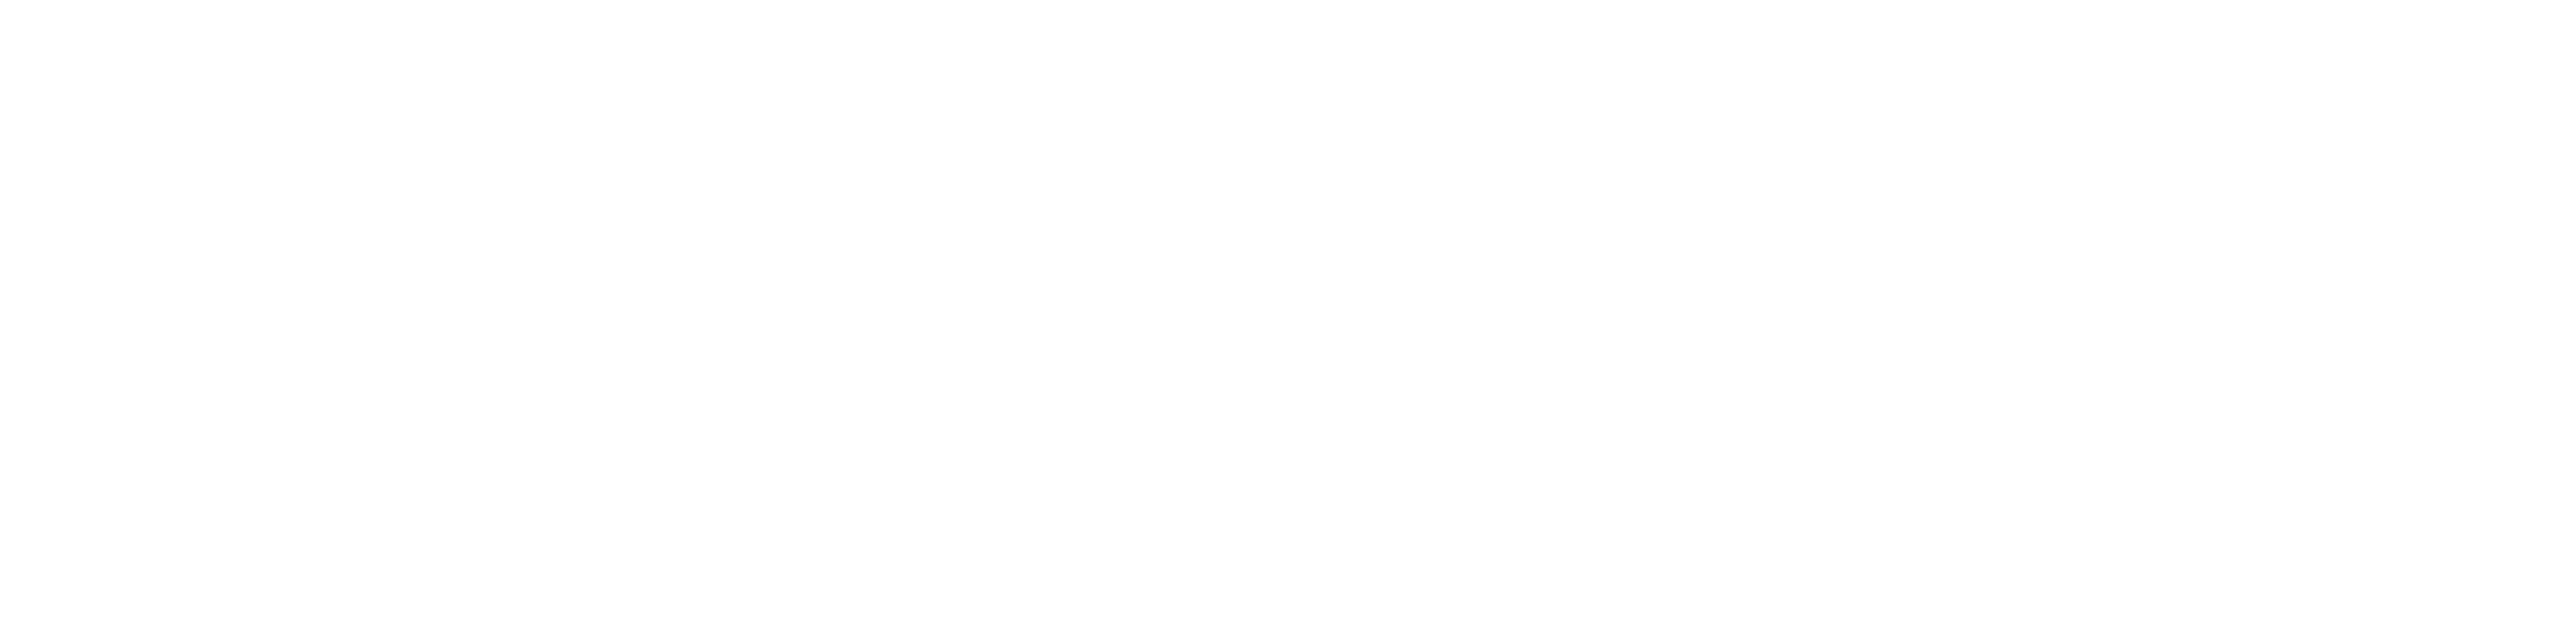

2020-05-29 12:32:54,506 logger INFO loss 1.35, 3D Dis:  10.54mm, poseDiff: 0.14, MemUsed:180.06
2020-05-29 12:33:04,561 logger INFO loss 1.33, 3D Dis:  9.30mm, poseDiff: 0.14, MemUsed:180.06
2020-05-29 12:33:14,769 logger INFO loss 1.31, 3D Dis:  8.40mm, poseDiff: 0.14, MemUsed:180.06
2020-05-29 12:33:25,015 logger INFO loss 1.31, 3D Dis:  7.89mm, poseDiff: 0.15, MemUsed:180.06
2020-05-29 12:33:35,457 logger INFO loss 1.30, 3D Dis:  7.59mm, poseDiff: 0.15, MemUsed:180.06


<IPython.core.display.Javascript object>


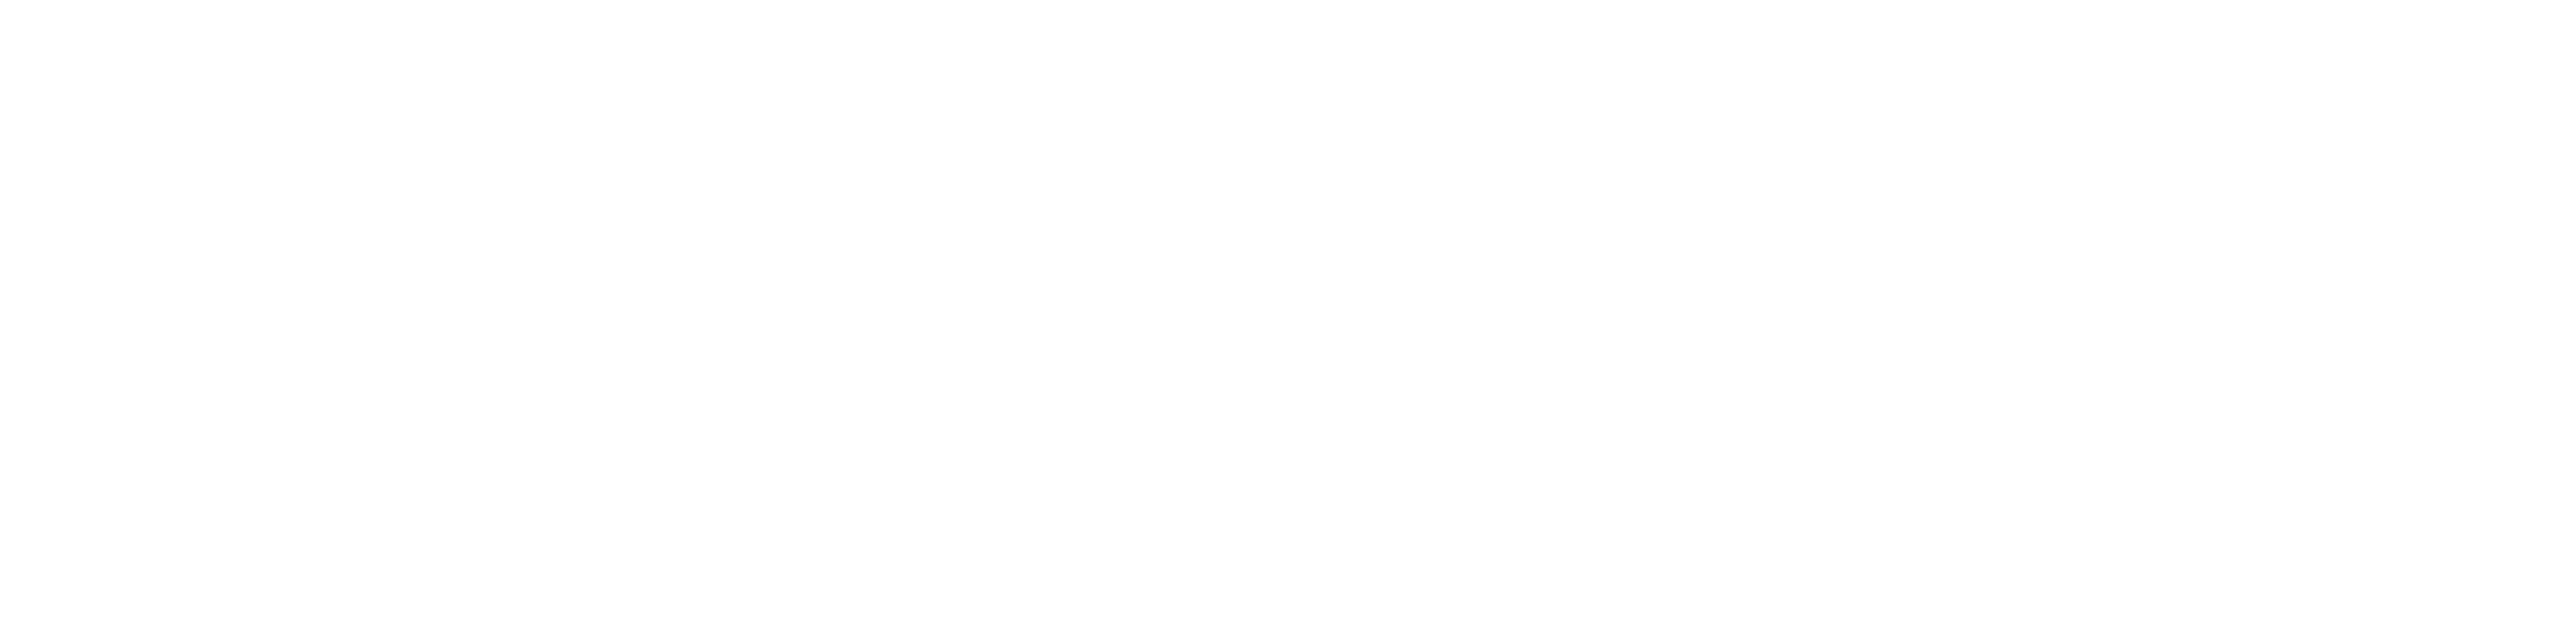

2020-05-29 12:34:08,671 logger INFO loss 1.29, 3D Dis:  7.33mm, poseDiff: 0.15, MemUsed:180.06
2020-05-29 12:34:18,665 logger INFO loss 1.28, 3D Dis:  7.05mm, poseDiff: 0.15, MemUsed:180.06
2020-05-29 12:34:28,866 logger INFO loss 1.27, 3D Dis:  6.73mm, poseDiff: 0.15, MemUsed:180.06
2020-05-29 12:34:39,143 logger INFO loss 1.25, 3D Dis:  6.40mm, poseDiff: 0.15, MemUsed:180.06
2020-05-29 12:34:49,643 logger INFO loss 1.24, 3D Dis:  6.15mm, poseDiff: 0.16, MemUsed:180.06


<IPython.core.display.Javascript object>


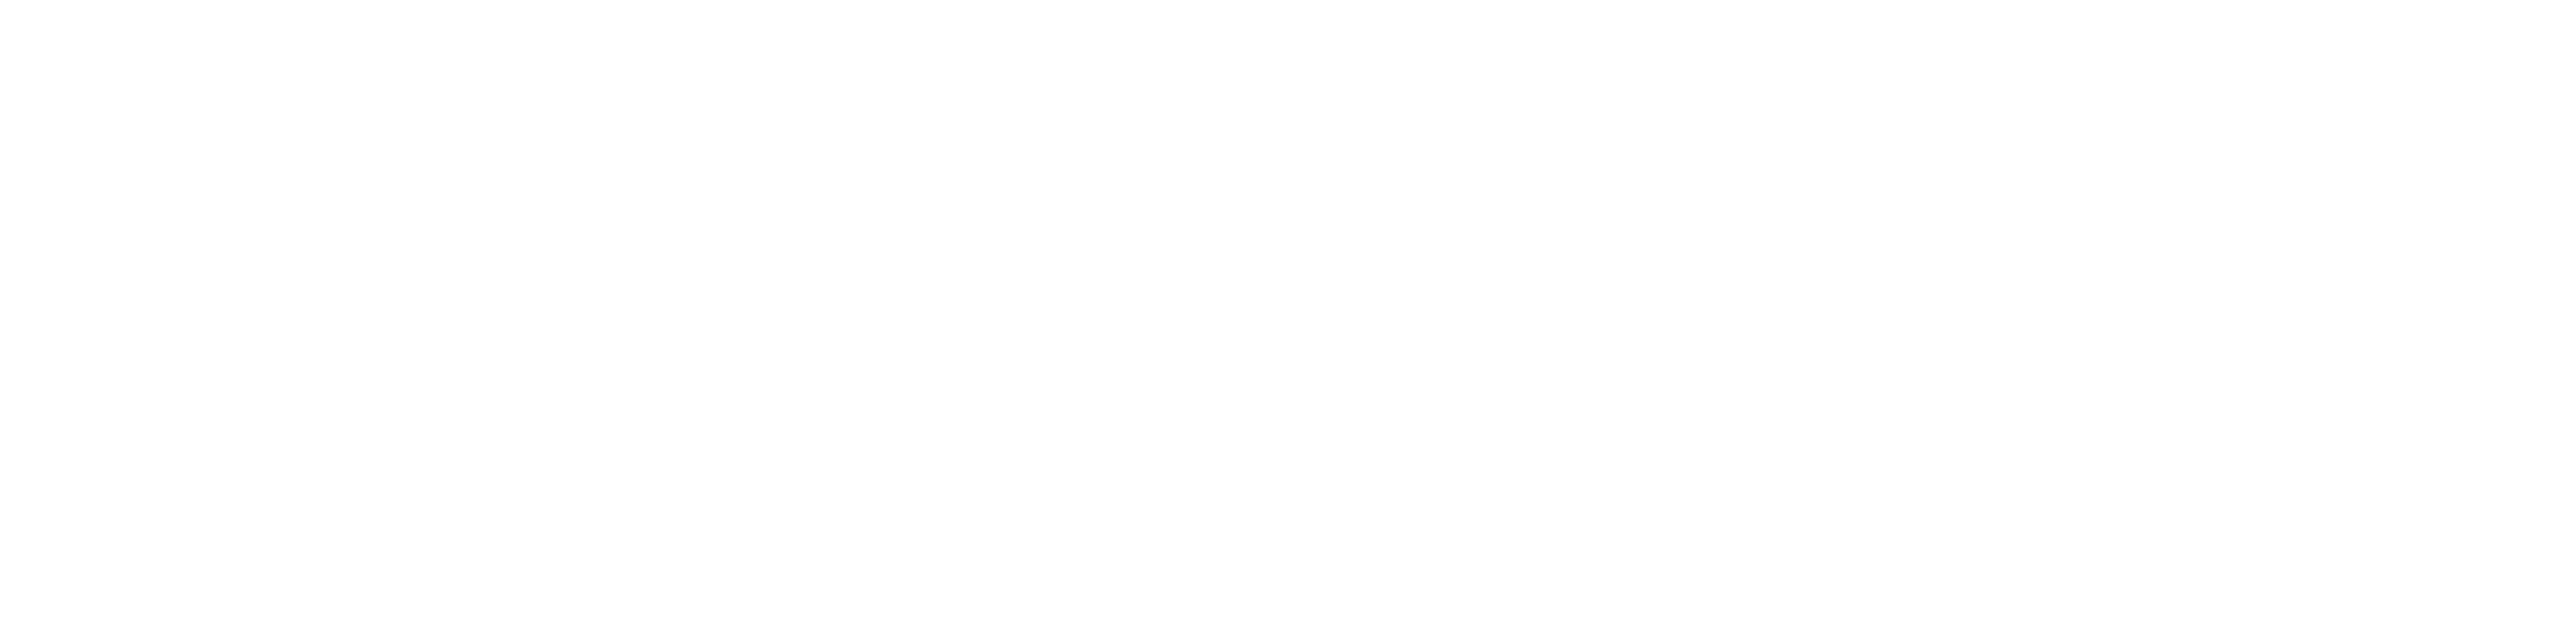

2020-05-29 12:35:22,581 logger INFO loss 1.23, 3D Dis:  6.04mm, poseDiff: 0.16, MemUsed:180.06
2020-05-29 12:35:32,582 logger INFO loss 1.22, 3D Dis:  6.15mm, poseDiff: 0.16, MemUsed:180.06
2020-05-29 12:35:42,869 logger INFO loss 1.22, 3D Dis:  6.43mm, poseDiff: 0.16, MemUsed:180.06
2020-05-29 12:35:53,250 logger INFO loss 1.22, 3D Dis:  6.76mm, poseDiff: 0.16, MemUsed:180.06
2020-05-29 12:36:03,685 logger INFO loss 1.22, 3D Dis:  7.02mm, poseDiff: 0.16, MemUsed:180.06


<IPython.core.display.Javascript object>


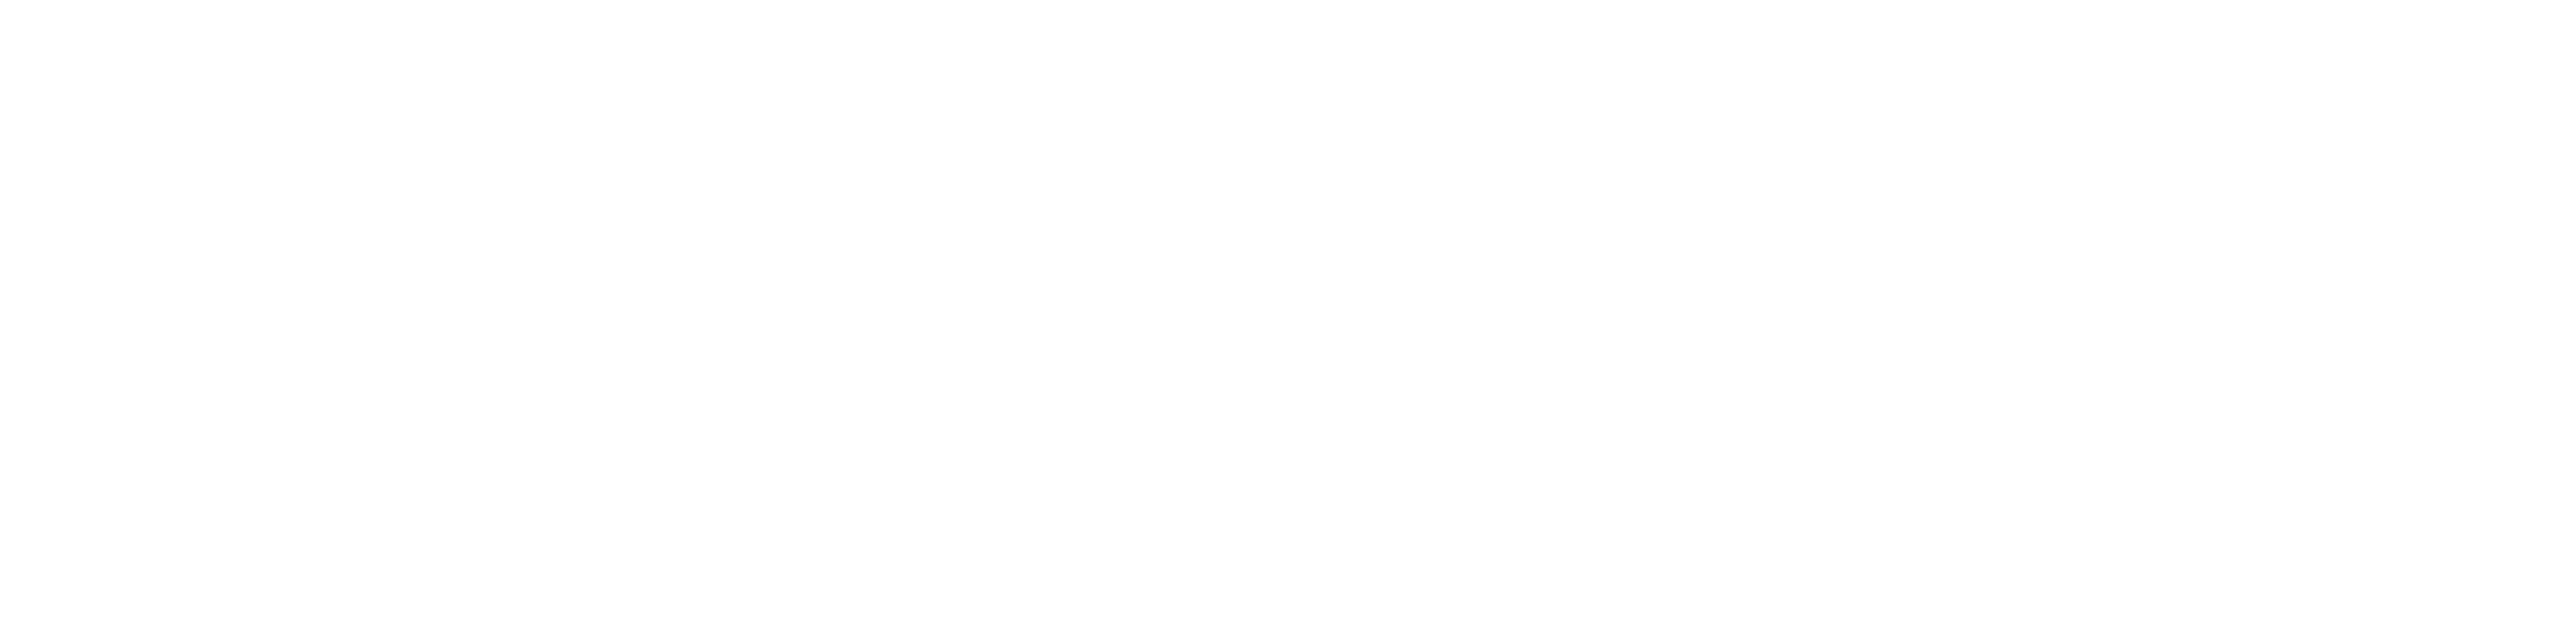

2020-05-29 12:36:36,917 logger INFO loss 1.22, 3D Dis:  7.13mm, poseDiff: 0.17, MemUsed:180.06
2020-05-29 12:36:46,952 logger INFO loss 1.22, 3D Dis:  7.09mm, poseDiff: 0.17, MemUsed:180.06
2020-05-29 12:36:57,165 logger INFO loss 1.22, 3D Dis:  6.91mm, poseDiff: 0.17, MemUsed:180.06
2020-05-29 12:37:07,526 logger INFO loss 1.22, 3D Dis:  6.65mm, poseDiff: 0.17, MemUsed:180.06
2020-05-29 12:37:17,888 logger INFO loss 1.21, 3D Dis:  6.39mm, poseDiff: 0.17, MemUsed:180.06


<IPython.core.display.Javascript object>


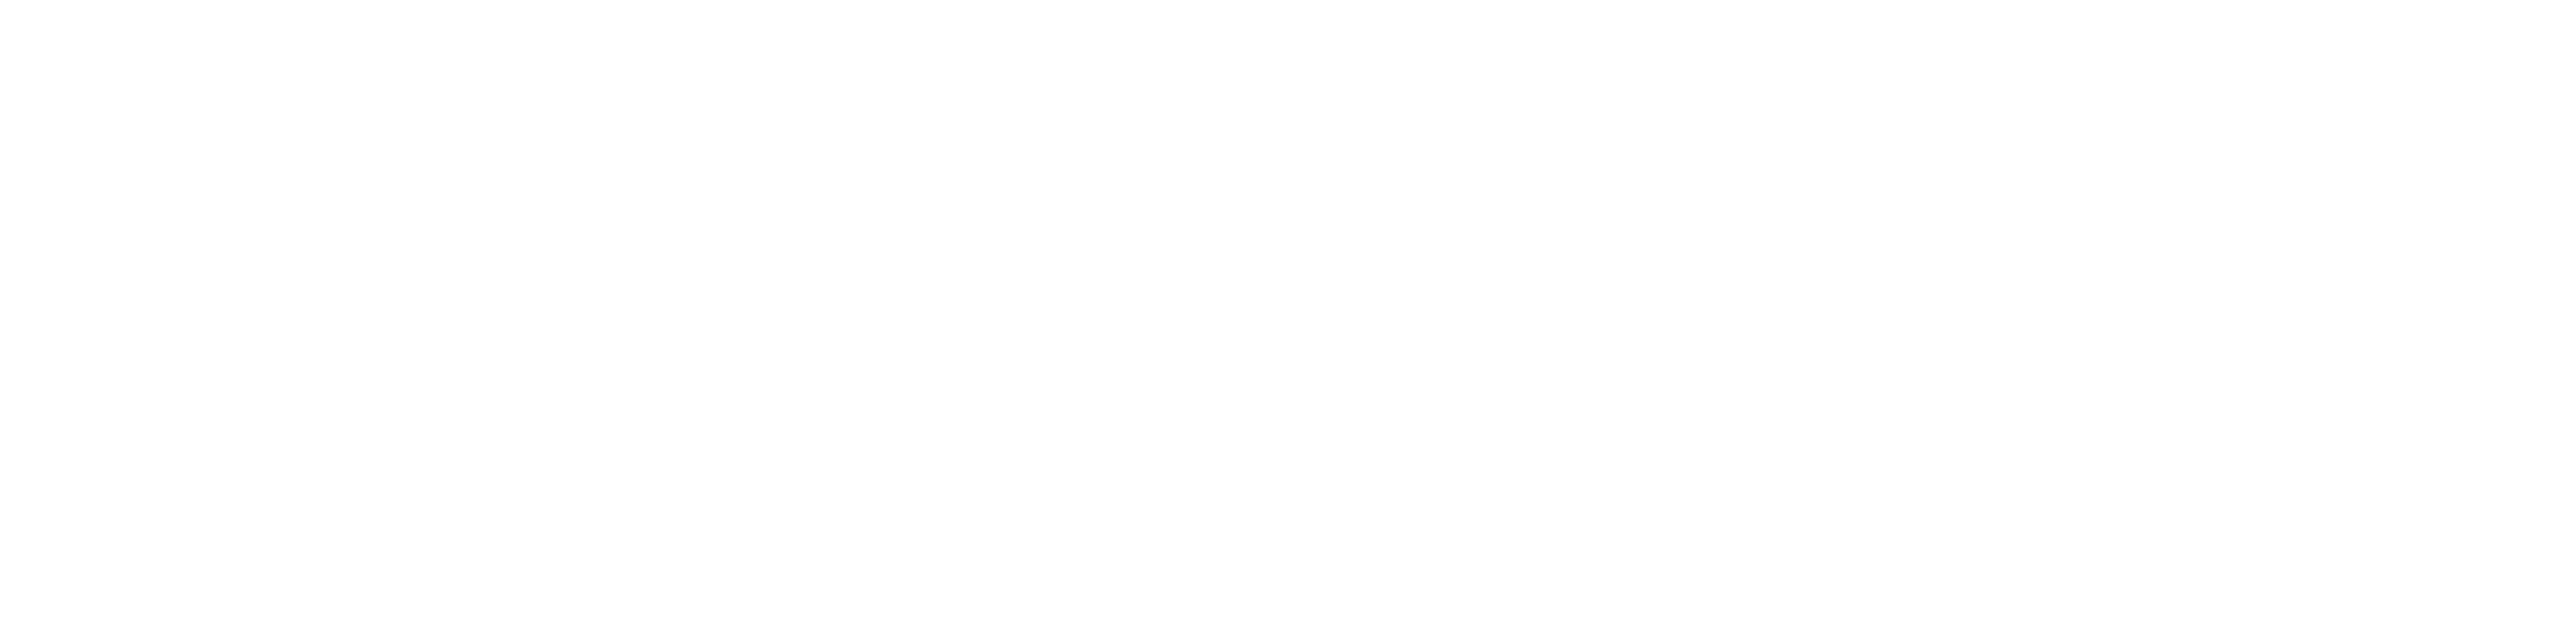

2020-05-29 12:37:50,847 logger INFO loss 1.21, 3D Dis:  6.19mm, poseDiff: 0.17, MemUsed:180.06
2020-05-29 12:38:01,402 logger INFO loss 1.21, 3D Dis:  6.10mm, poseDiff: 0.17, MemUsed:180.06
2020-05-29 12:38:11,856 logger INFO loss 1.21, 3D Dis:  6.10mm, poseDiff: 0.18, MemUsed:180.06
2020-05-29 12:38:23,075 logger INFO loss 1.22, 3D Dis:  6.15mm, poseDiff: 0.18, MemUsed:180.06
2020-05-29 12:38:33,965 logger INFO loss 1.22, 3D Dis:  6.21mm, poseDiff: 0.18, MemUsed:180.06


<IPython.core.display.Javascript object>


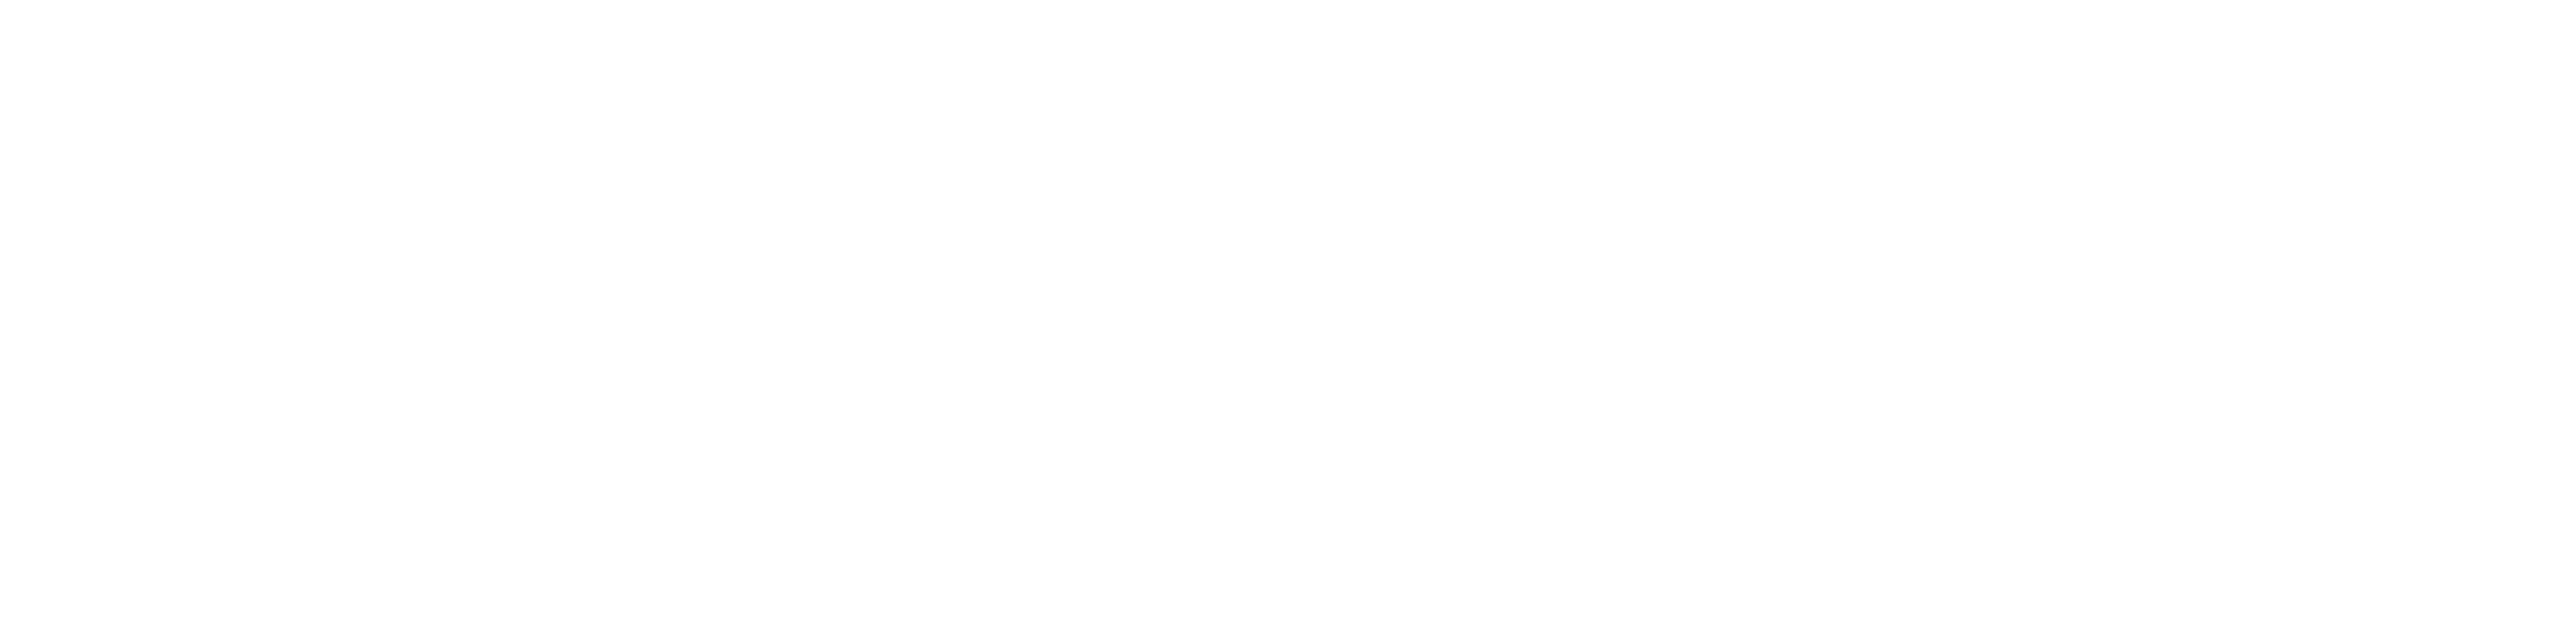

2020-05-29 12:39:08,405 logger INFO loss 1.22, 3D Dis:  6.29mm, poseDiff: 0.18, MemUsed:180.06
2020-05-29 12:39:18,826 logger INFO loss 1.22, 3D Dis:  6.37mm, poseDiff: 0.18, MemUsed:180.06
2020-05-29 12:39:29,406 logger INFO loss 1.21, 3D Dis:  6.46mm, poseDiff: 0.18, MemUsed:180.06
2020-05-29 12:39:39,872 logger INFO loss 1.21, 3D Dis:  6.58mm, poseDiff: 0.19, MemUsed:180.06
2020-05-29 12:39:50,460 logger INFO loss 1.21, 3D Dis:  6.71mm, poseDiff: 0.19, MemUsed:180.06


<IPython.core.display.Javascript object>


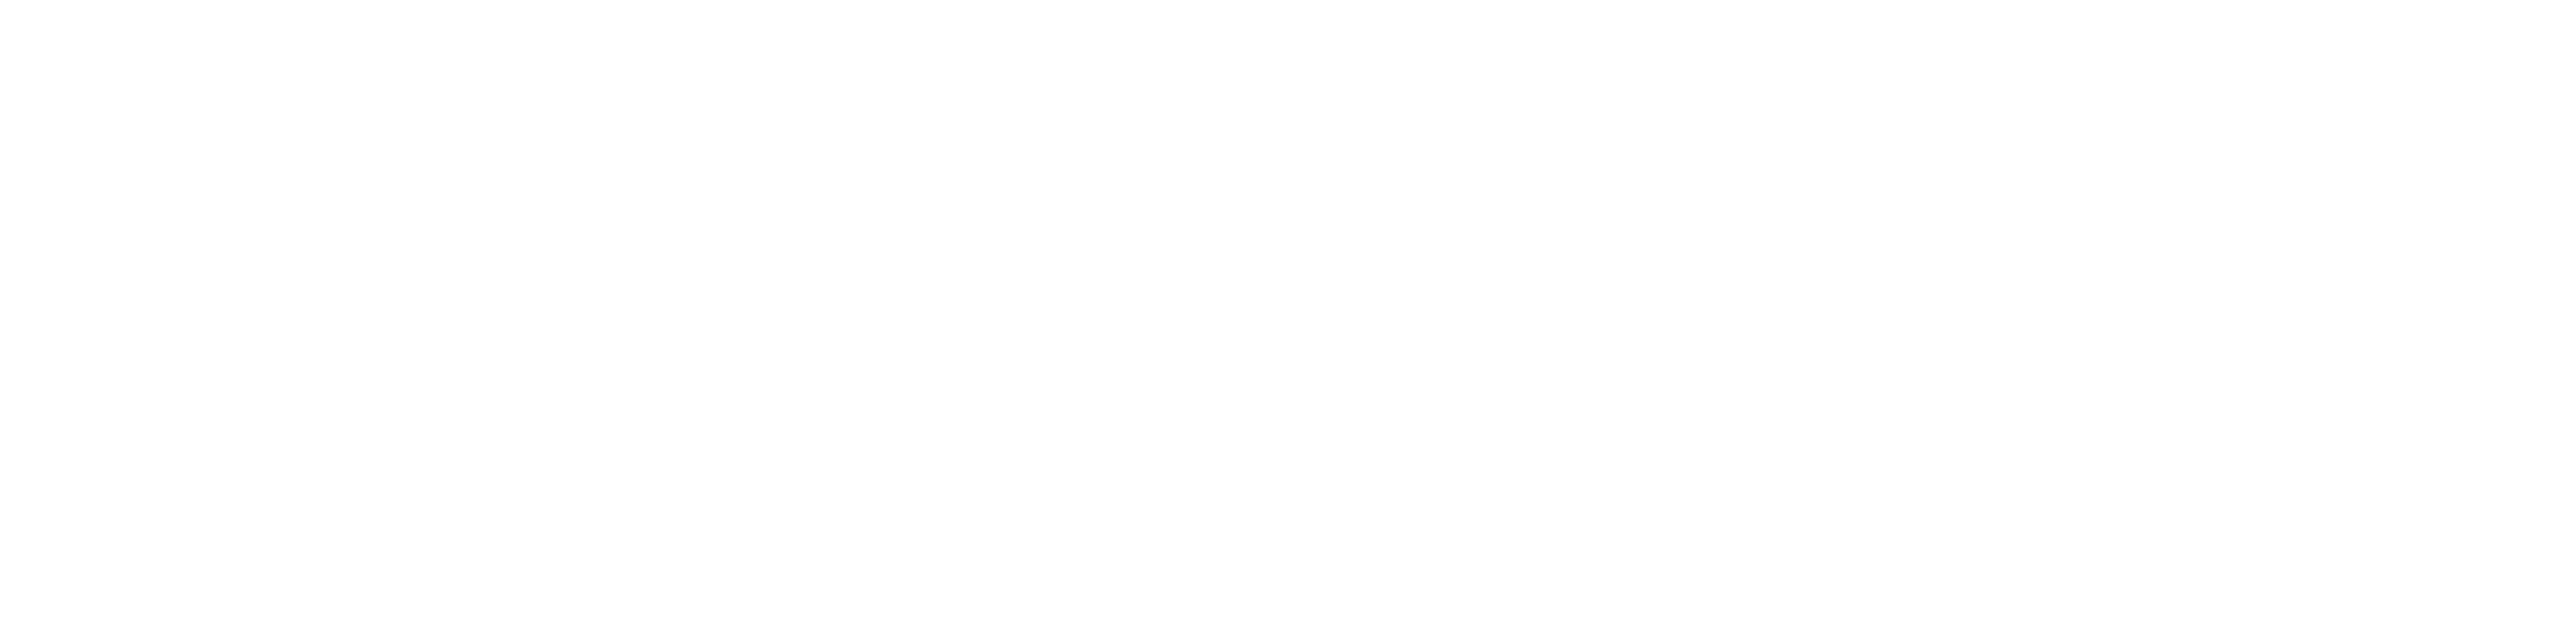

2020-05-29 12:40:24,340 logger INFO loss 1.21, 3D Dis:  6.84mm, poseDiff: 0.19, MemUsed:180.06
2020-05-29 12:40:34,643 logger INFO loss 1.21, 3D Dis:  6.93mm, poseDiff: 0.19, MemUsed:180.06
2020-05-29 12:40:45,234 logger INFO loss 1.21, 3D Dis:  6.99mm, poseDiff: 0.19, MemUsed:180.06
2020-05-29 12:40:55,894 logger INFO loss 1.21, 3D Dis:  6.99mm, poseDiff: 0.20, MemUsed:180.06
2020-05-29 12:41:06,913 logger INFO loss 1.21, 3D Dis:  6.95mm, poseDiff: 0.20, MemUsed:180.06


<IPython.core.display.Javascript object>


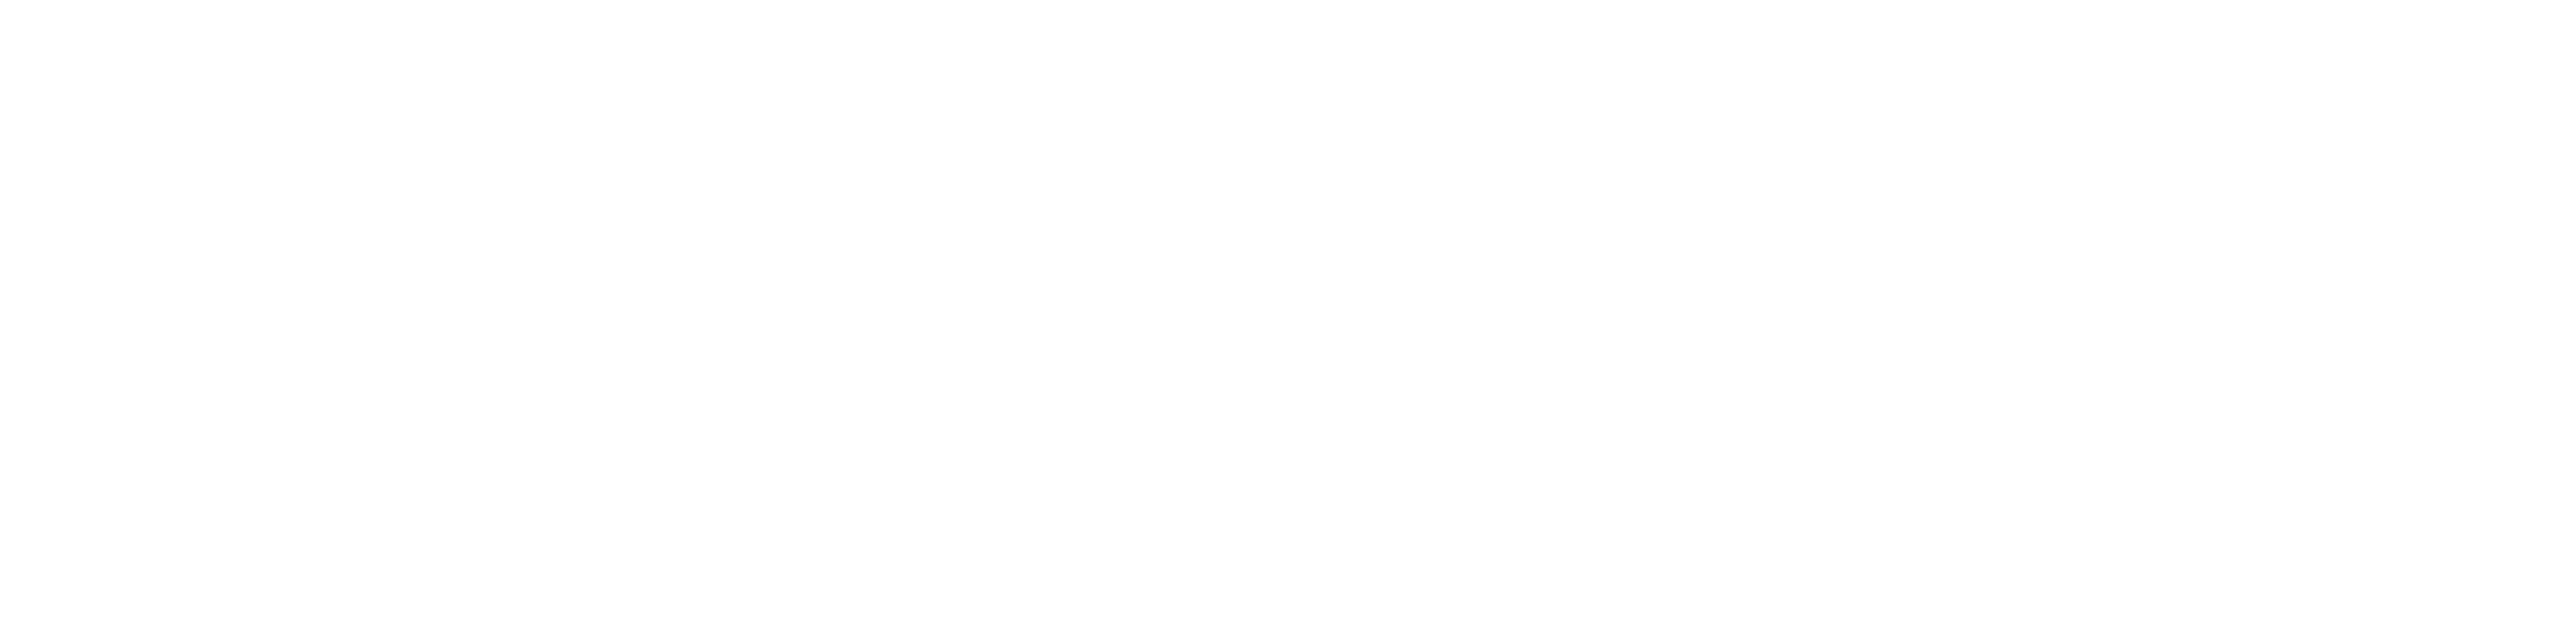

2020-05-29 12:41:40,722 logger INFO loss 1.21, 3D Dis:  6.88mm, poseDiff: 0.20, MemUsed:180.06
2020-05-29 12:41:51,099 logger INFO loss 1.21, 3D Dis:  6.79mm, poseDiff: 0.20, MemUsed:180.06
2020-05-29 12:42:01,823 logger INFO loss 1.21, 3D Dis:  6.72mm, poseDiff: 0.20, MemUsed:180.06
2020-05-29 12:42:12,403 logger INFO loss 1.21, 3D Dis:  6.66mm, poseDiff: 0.21, MemUsed:180.06
2020-05-29 12:42:23,167 logger INFO loss 1.20, 3D Dis:  6.62mm, poseDiff: 0.21, MemUsed:180.06


<IPython.core.display.Javascript object>


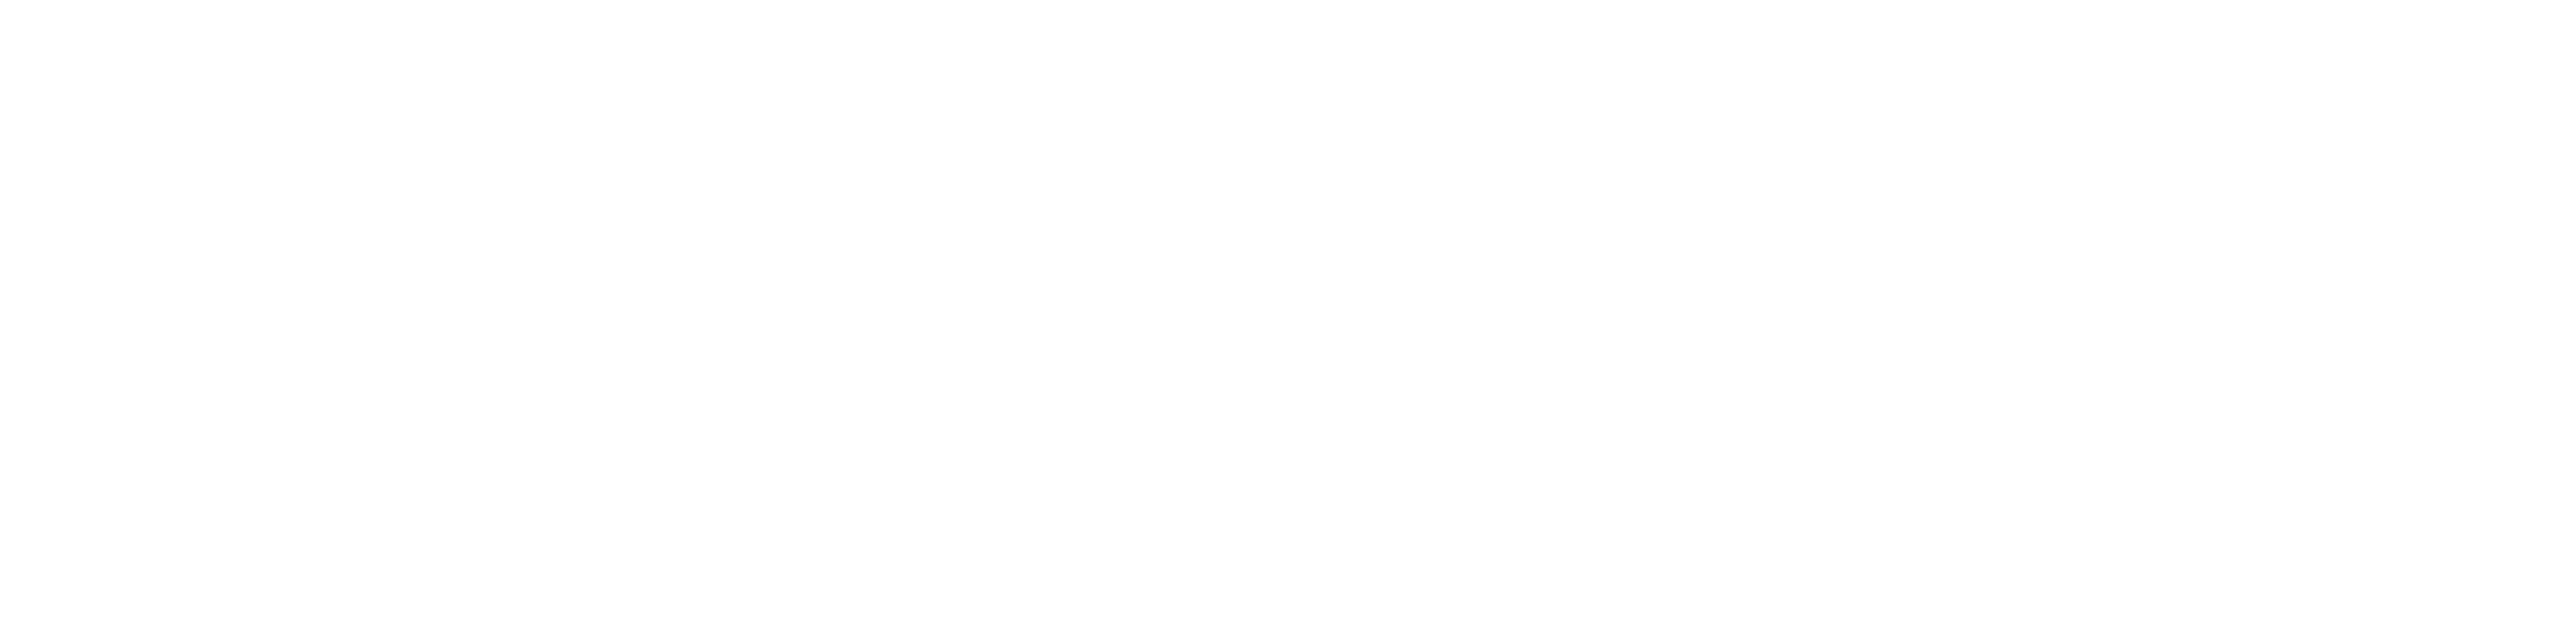

2020-05-29 12:42:56,723 logger INFO loss 1.20, 3D Dis:  6.59mm, poseDiff: 0.21, MemUsed:180.06
2020-05-29 12:43:07,012 logger INFO loss 1.20, 3D Dis:  6.58mm, poseDiff: 0.21, MemUsed:180.06
2020-05-29 12:43:17,765 logger INFO loss 1.20, 3D Dis:  6.58mm, poseDiff: 0.21, MemUsed:180.06
2020-05-29 12:43:28,473 logger INFO loss 1.20, 3D Dis:  6.57mm, poseDiff: 0.22, MemUsed:180.06
2020-05-29 12:43:39,403 logger INFO loss 1.20, 3D Dis:  6.57mm, poseDiff: 0.22, MemUsed:180.06


<IPython.core.display.Javascript object>


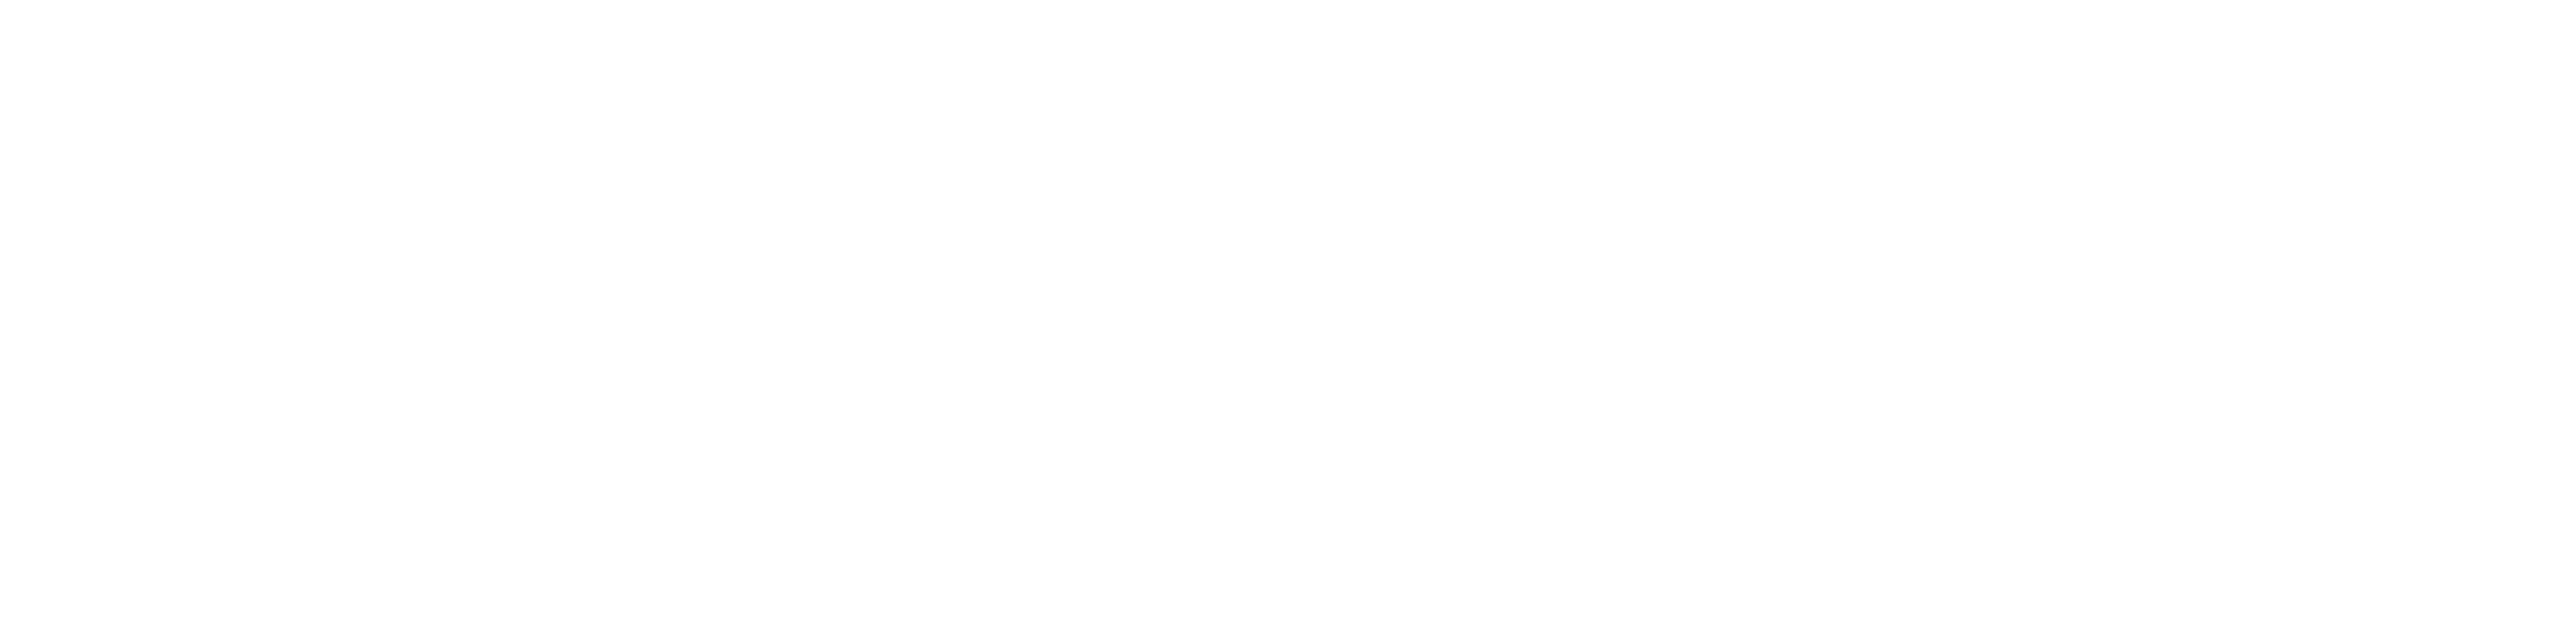

2020-05-29 12:44:13,236 logger INFO loss 1.20, 3D Dis:  6.56mm, poseDiff: 0.22, MemUsed:180.06
2020-05-29 12:44:23,763 logger INFO loss 1.20, 3D Dis:  6.56mm, poseDiff: 0.22, MemUsed:180.06
2020-05-29 12:44:34,230 logger INFO loss 1.20, 3D Dis:  6.55mm, poseDiff: 0.22, MemUsed:180.06
2020-05-29 12:44:44,879 logger INFO loss 1.20, 3D Dis:  6.55mm, poseDiff: 0.23, MemUsed:180.06
2020-05-29 12:44:55,677 logger INFO loss 1.20, 3D Dis:  6.55mm, poseDiff: 0.23, MemUsed:180.06


<IPython.core.display.Javascript object>


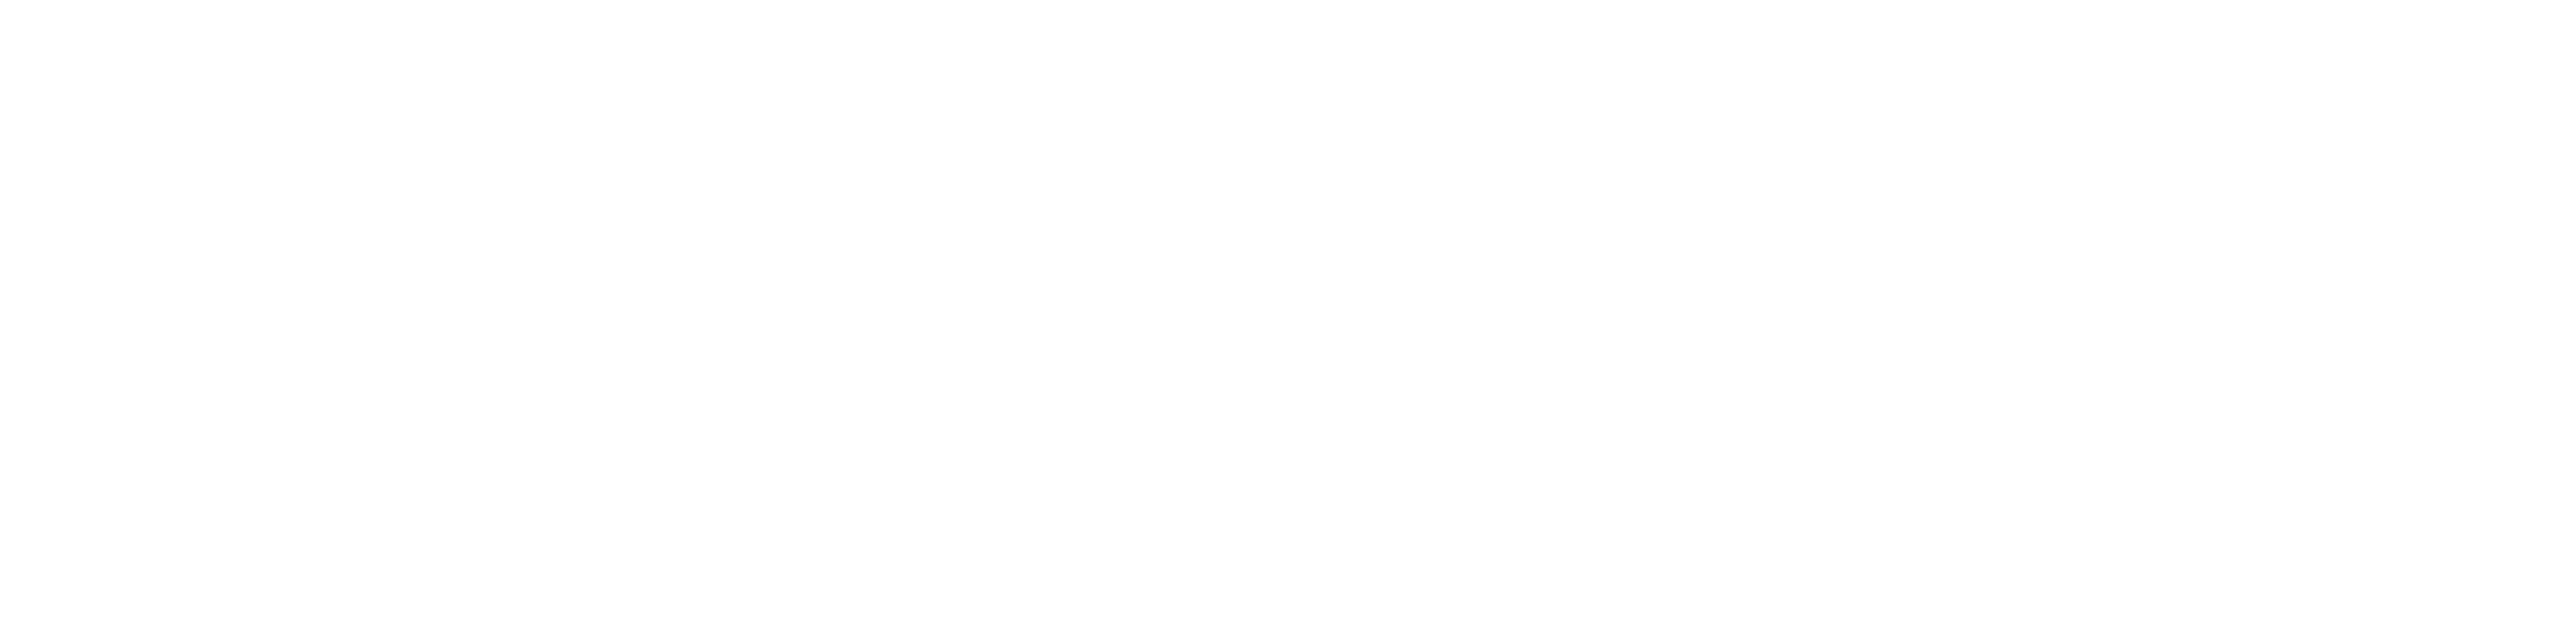

2020-05-29 12:45:29,314 logger INFO loss 1.20, 3D Dis:  6.54mm, poseDiff: 0.23, MemUsed:180.06
2020-05-29 12:45:39,838 logger INFO loss 1.20, 3D Dis:  6.52mm, poseDiff: 0.23, MemUsed:180.06
2020-05-29 12:45:50,564 logger INFO loss 1.20, 3D Dis:  6.49mm, poseDiff: 0.24, MemUsed:180.06
2020-05-29 12:46:01,161 logger INFO loss 1.20, 3D Dis:  6.47mm, poseDiff: 0.24, MemUsed:180.06
2020-05-29 12:46:11,935 logger INFO loss 1.20, 3D Dis:  6.45mm, poseDiff: 0.24, MemUsed:180.06


<IPython.core.display.Javascript object>


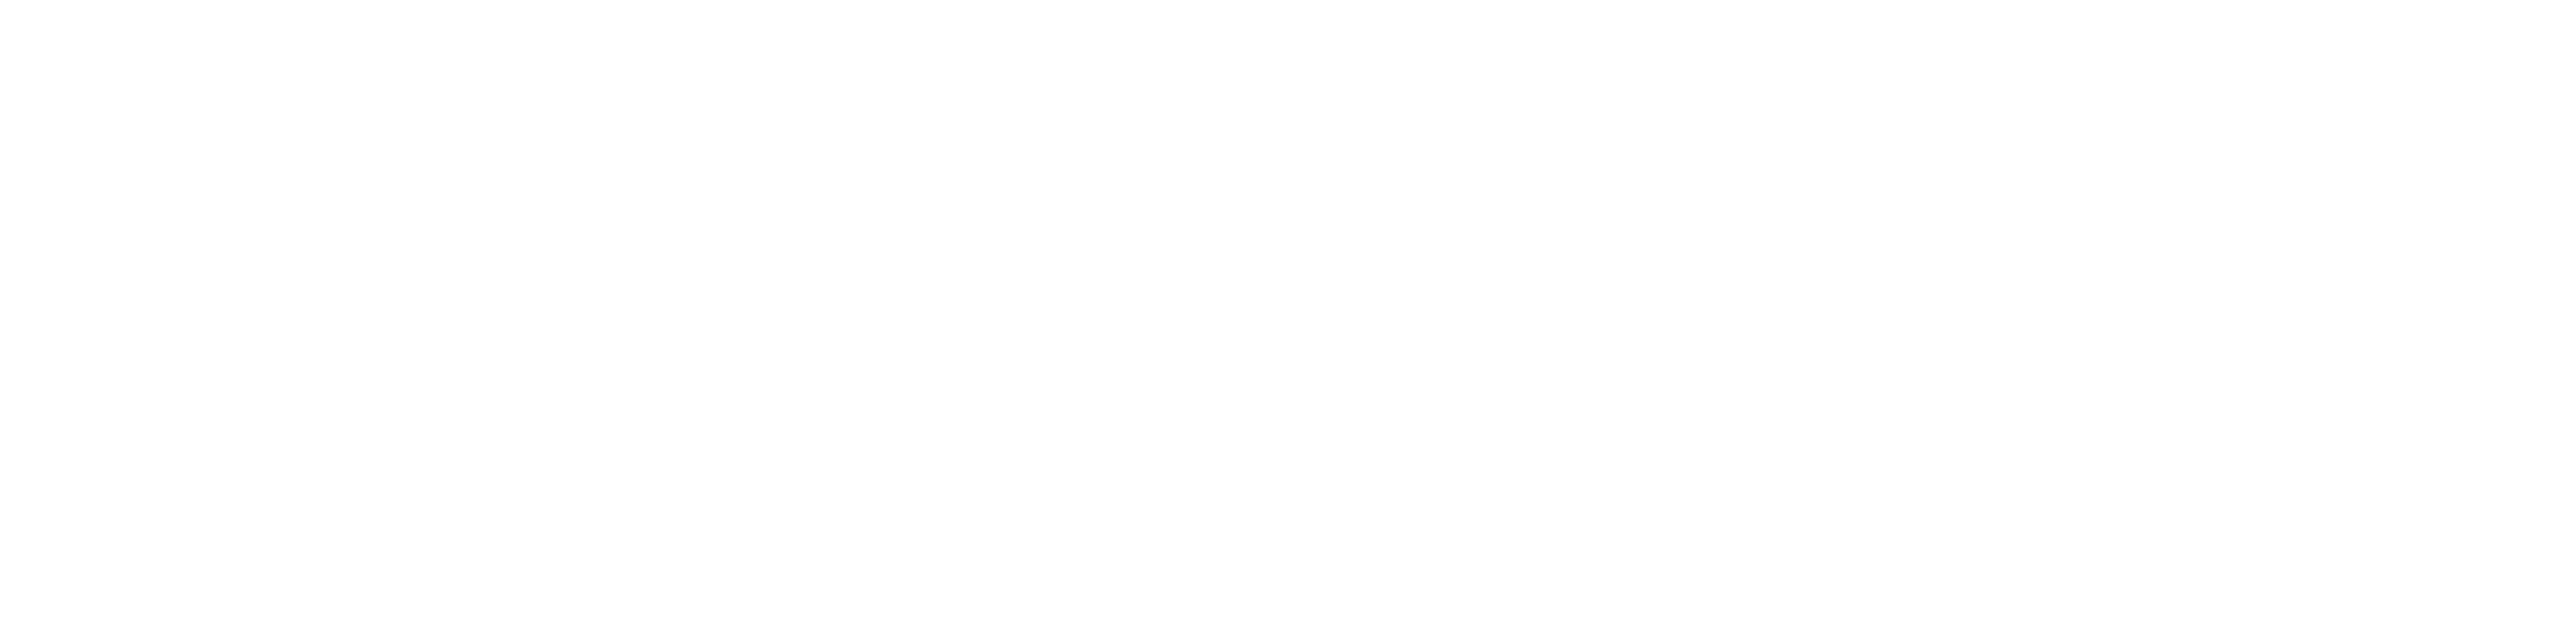

2020-05-29 12:46:45,892 logger INFO loss 1.20, 3D Dis:  6.43mm, poseDiff: 0.24, MemUsed:180.06
2020-05-29 12:46:56,331 logger INFO loss 1.20, 3D Dis:  6.41mm, poseDiff: 0.25, MemUsed:180.06
2020-05-29 12:47:06,950 logger INFO loss 1.20, 3D Dis:  6.39mm, poseDiff: 0.25, MemUsed:180.06
2020-05-29 12:47:17,453 logger INFO loss 1.19, 3D Dis:  6.37mm, poseDiff: 0.25, MemUsed:180.06
2020-05-29 12:47:28,400 logger INFO loss 1.19, 3D Dis:  6.35mm, poseDiff: 0.25, MemUsed:180.06


<IPython.core.display.Javascript object>


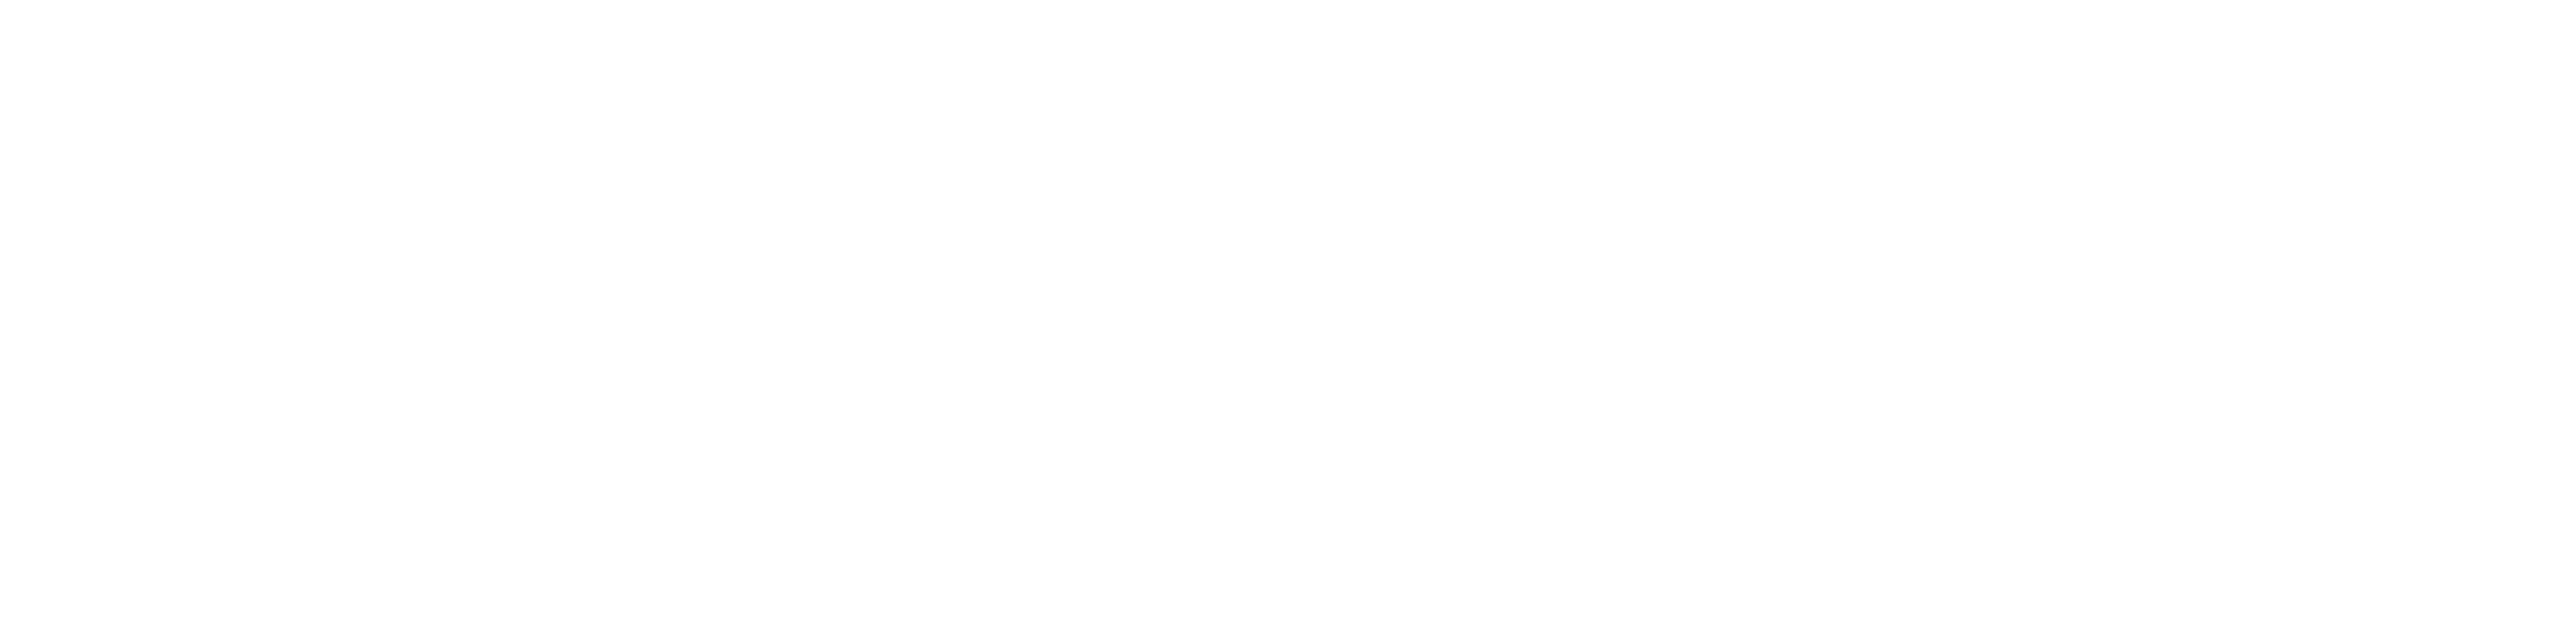

2020-05-29 12:48:02,533 logger INFO loss 1.19, 3D Dis:  6.34mm, poseDiff: 0.26, MemUsed:180.06
2020-05-29 12:48:12,885 logger INFO loss 1.19, 3D Dis:  6.33mm, poseDiff: 0.26, MemUsed:180.06
2020-05-29 12:48:23,552 logger INFO loss 1.19, 3D Dis:  6.32mm, poseDiff: 0.26, MemUsed:180.06
2020-05-29 12:48:34,158 logger INFO loss 1.19, 3D Dis:  6.31mm, poseDiff: 0.26, MemUsed:180.06
2020-05-29 12:48:44,730 logger INFO loss 1.19, 3D Dis:  6.30mm, poseDiff: 0.27, MemUsed:180.06


<IPython.core.display.Javascript object>


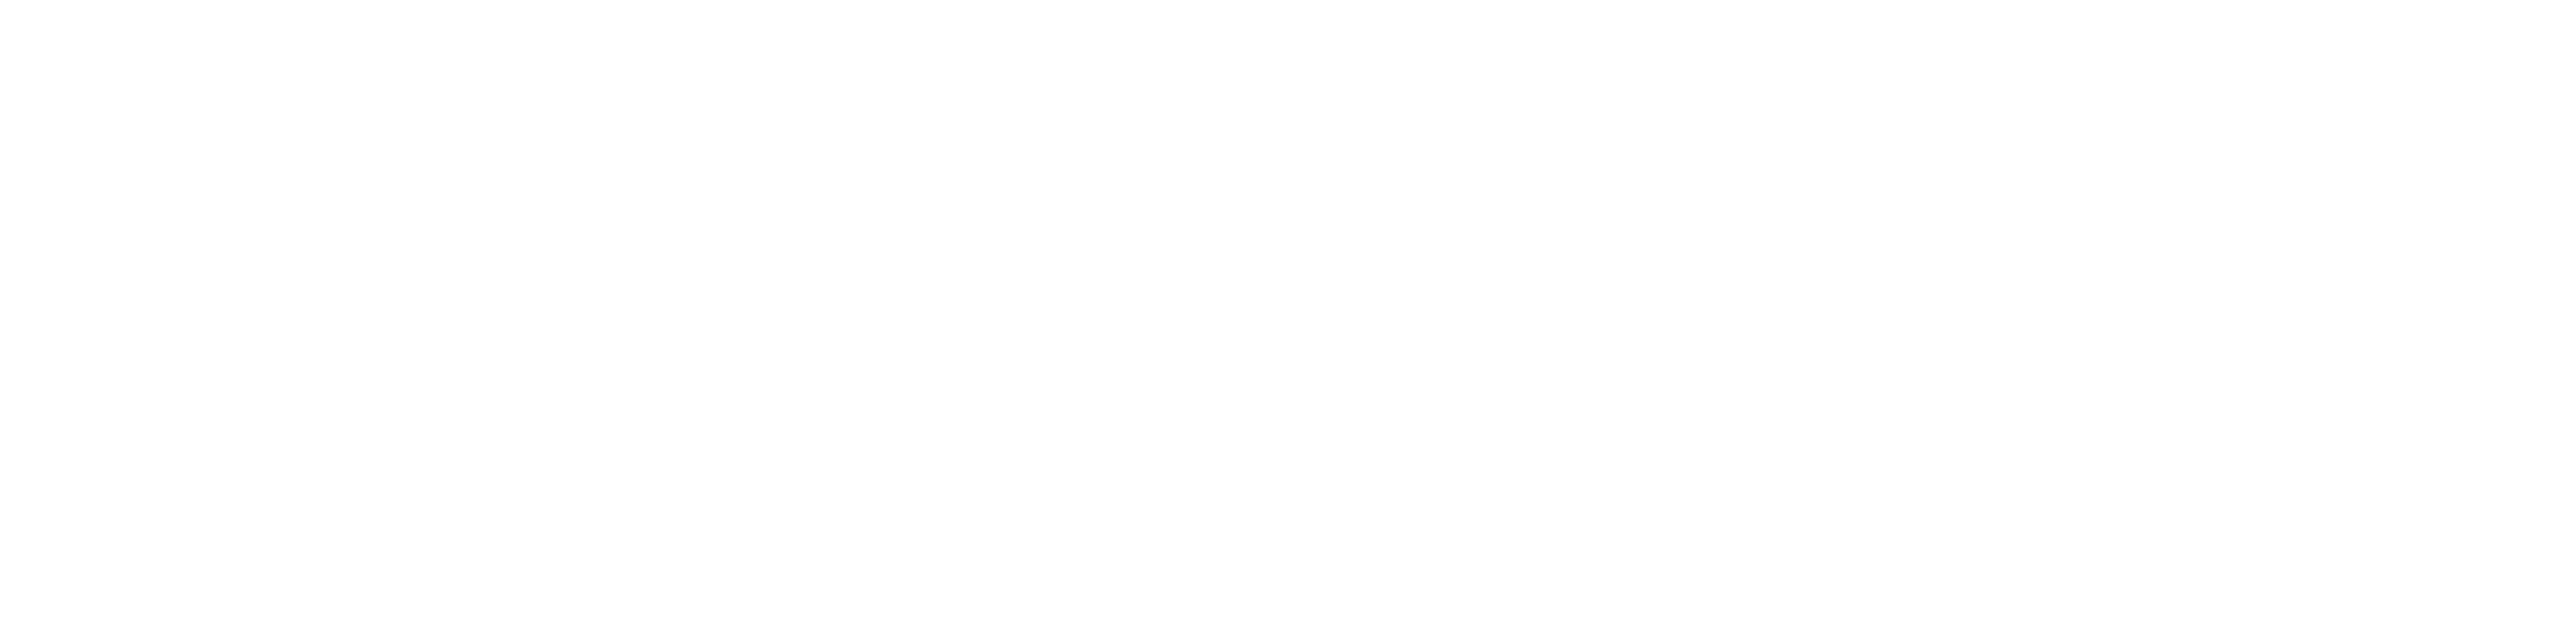

2020-05-29 12:49:18,455 logger INFO loss 1.19, 3D Dis:  6.29mm, poseDiff: 0.27, MemUsed:180.06
2020-05-29 12:49:28,868 logger INFO loss 1.19, 3D Dis:  6.28mm, poseDiff: 0.27, MemUsed:180.06
2020-05-29 12:49:39,550 logger INFO loss 1.19, 3D Dis:  6.27mm, poseDiff: 0.28, MemUsed:180.06
2020-05-29 12:49:50,372 logger INFO loss 1.19, 3D Dis:  6.26mm, poseDiff: 0.28, MemUsed:180.06
2020-05-29 12:50:01,137 logger INFO loss 1.19, 3D Dis:  6.25mm, poseDiff: 0.28, MemUsed:180.06


<IPython.core.display.Javascript object>


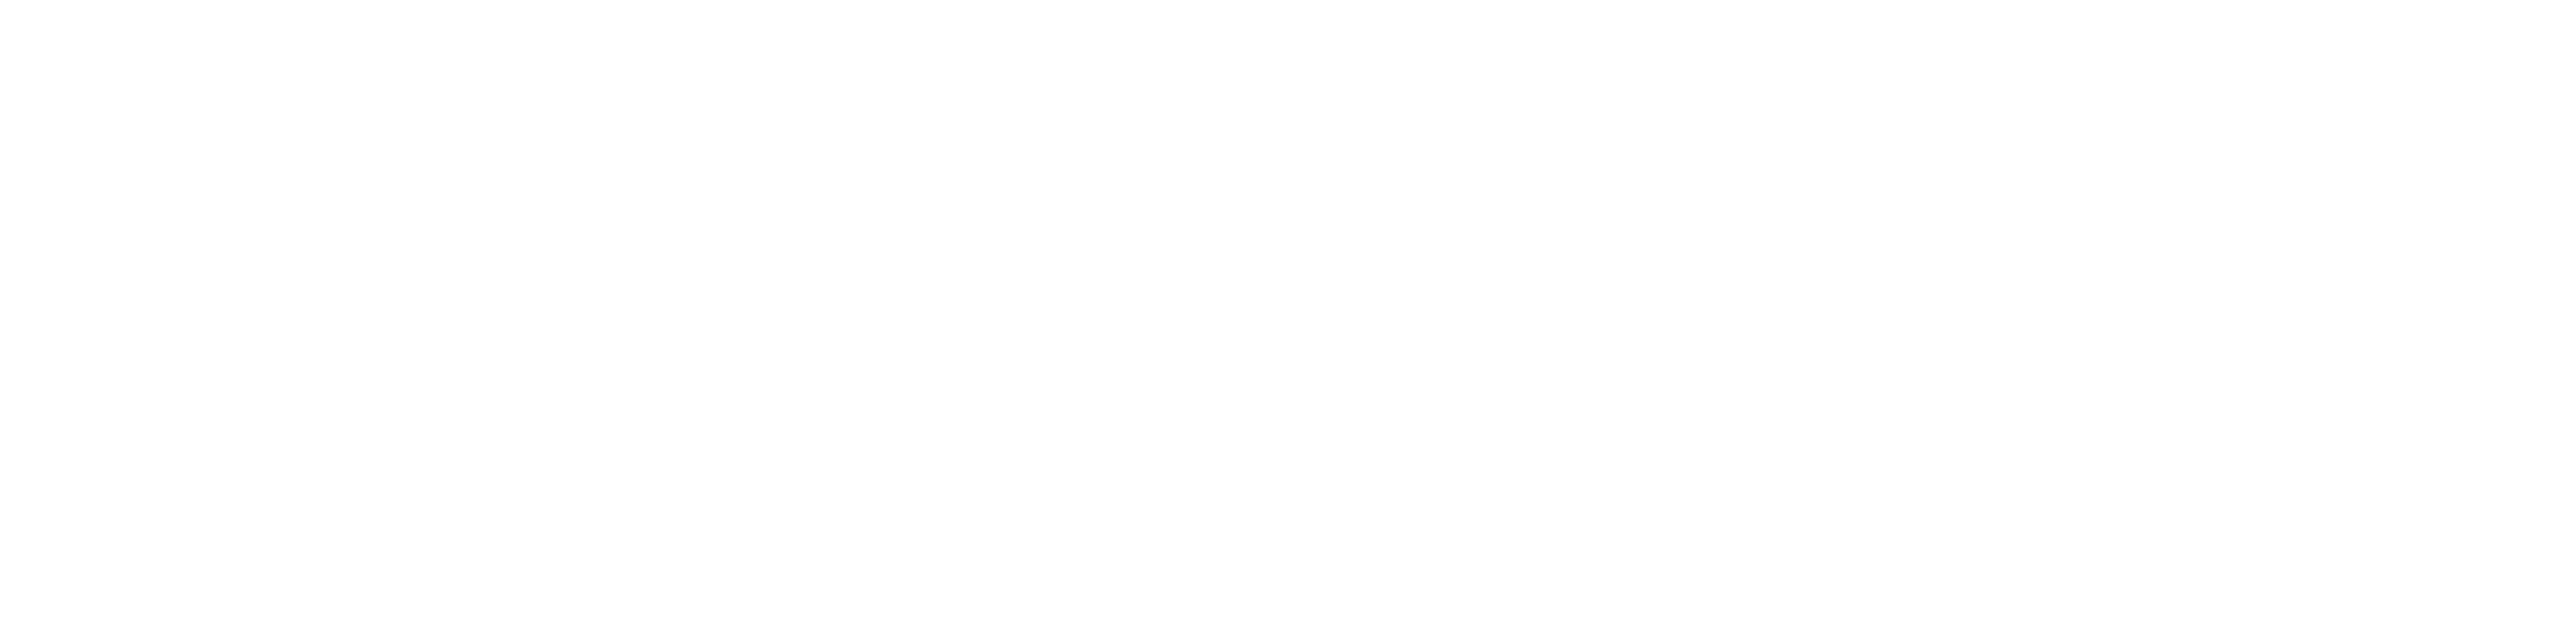

2020-05-29 12:50:34,393 logger INFO loss 1.19, 3D Dis:  6.24mm, poseDiff: 0.28, MemUsed:180.06
2020-05-29 12:50:44,549 logger INFO loss 1.19, 3D Dis:  6.23mm, poseDiff: 0.29, MemUsed:180.06
2020-05-29 12:50:54,816 logger INFO loss 1.19, 3D Dis:  6.23mm, poseDiff: 0.29, MemUsed:180.06
2020-05-29 12:51:05,297 logger INFO loss 1.19, 3D Dis:  6.24mm, poseDiff: 0.29, MemUsed:180.06
2020-05-29 12:51:16,180 logger INFO loss 1.19, 3D Dis:  6.25mm, poseDiff: 0.30, MemUsed:180.06


<IPython.core.display.Javascript object>


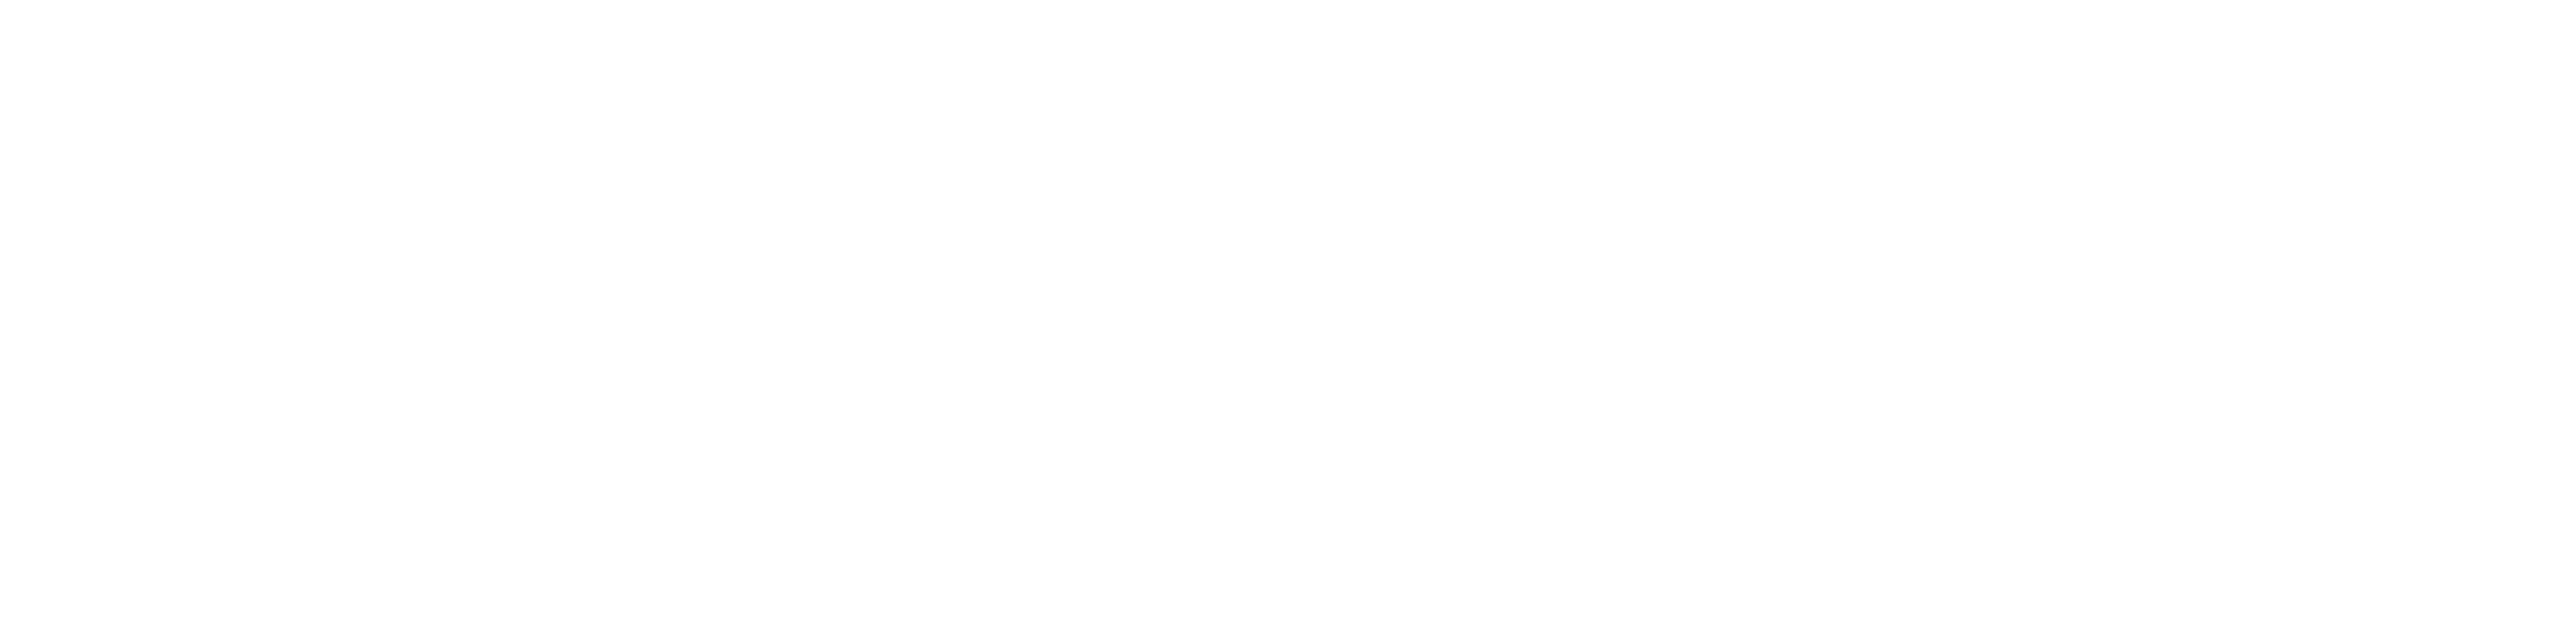

2020-05-29 12:51:50,333 logger INFO loss 1.19, 3D Dis:  6.26mm, poseDiff: 0.30, MemUsed:180.06
2020-05-29 12:52:00,701 logger INFO loss 1.19, 3D Dis:  6.28mm, poseDiff: 0.30, MemUsed:180.06
2020-05-29 12:52:11,301 logger INFO loss 1.19, 3D Dis:  6.31mm, poseDiff: 0.31, MemUsed:180.06
2020-05-29 12:52:21,894 logger INFO loss 1.19, 3D Dis:  6.33mm, poseDiff: 0.31, MemUsed:180.06
2020-05-29 12:52:32,551 logger INFO loss 1.19, 3D Dis:  6.36mm, poseDiff: 0.31, MemUsed:180.06


<IPython.core.display.Javascript object>


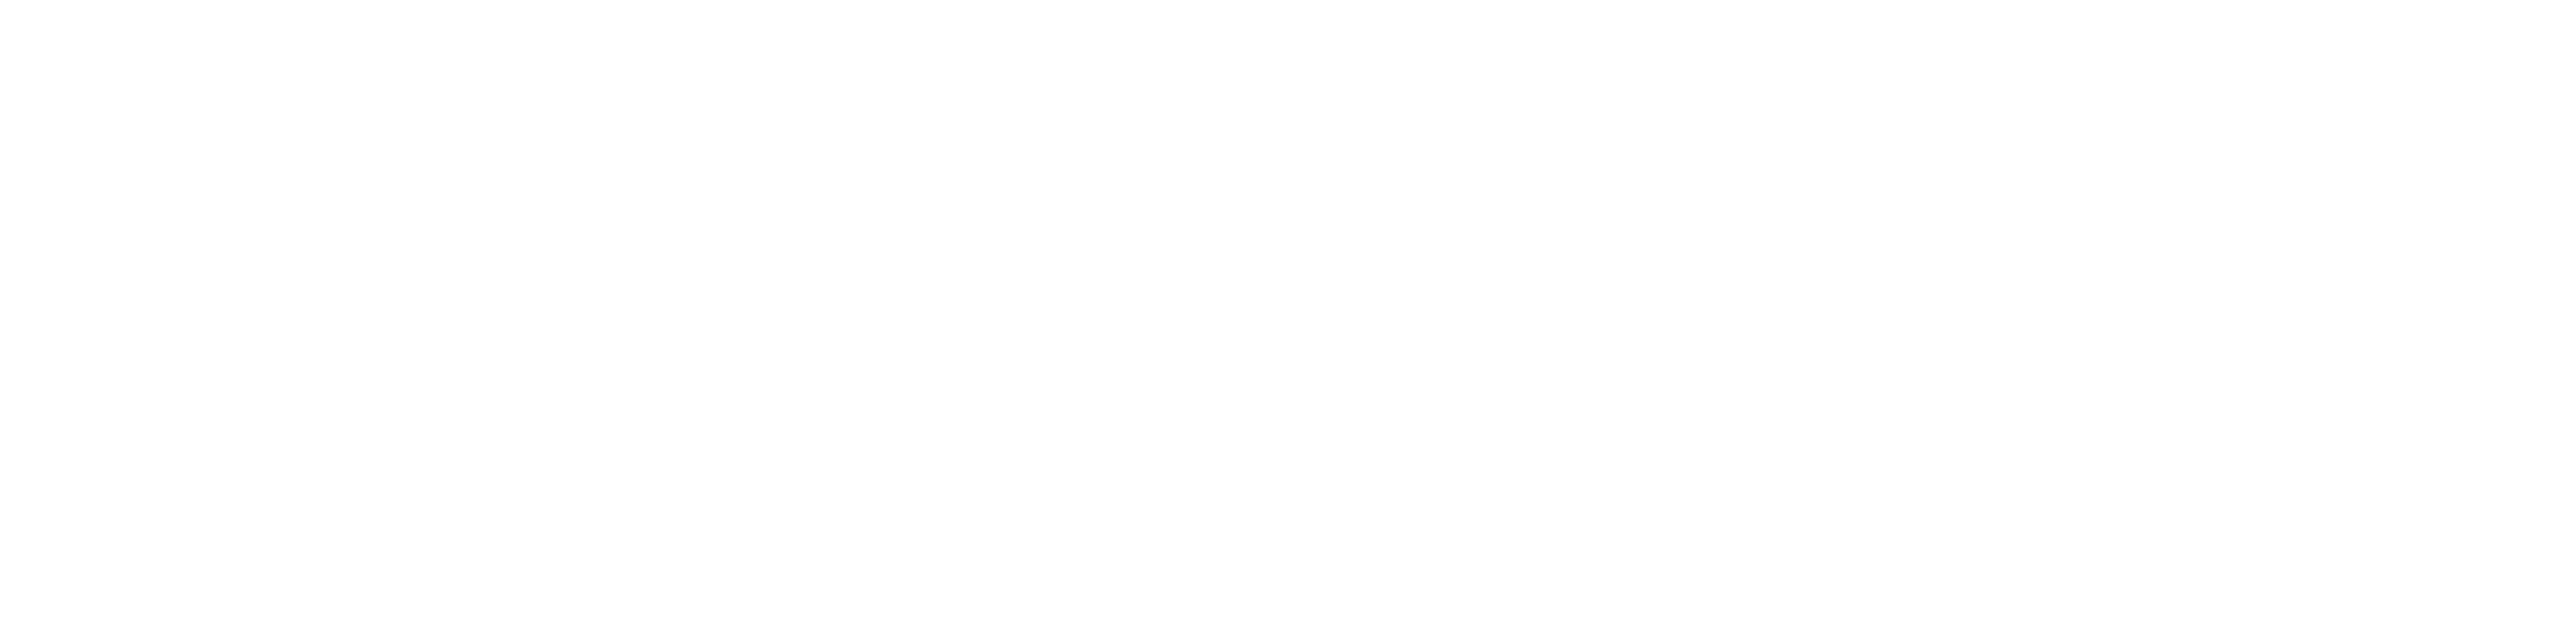

2020-05-29 12:53:06,230 logger INFO loss 1.19, 3D Dis:  6.38mm, poseDiff: 0.32, MemUsed:180.06
2020-05-29 12:53:16,699 logger INFO loss 1.19, 3D Dis:  6.40mm, poseDiff: 0.32, MemUsed:180.06
2020-05-29 12:53:27,324 logger INFO loss 1.19, 3D Dis:  6.41mm, poseDiff: 0.32, MemUsed:180.06
2020-05-29 12:53:38,054 logger INFO loss 1.19, 3D Dis:  6.42mm, poseDiff: 0.33, MemUsed:180.06
2020-05-29 12:53:48,779 logger INFO loss 1.18, 3D Dis:  6.43mm, poseDiff: 0.33, MemUsed:180.06


<IPython.core.display.Javascript object>


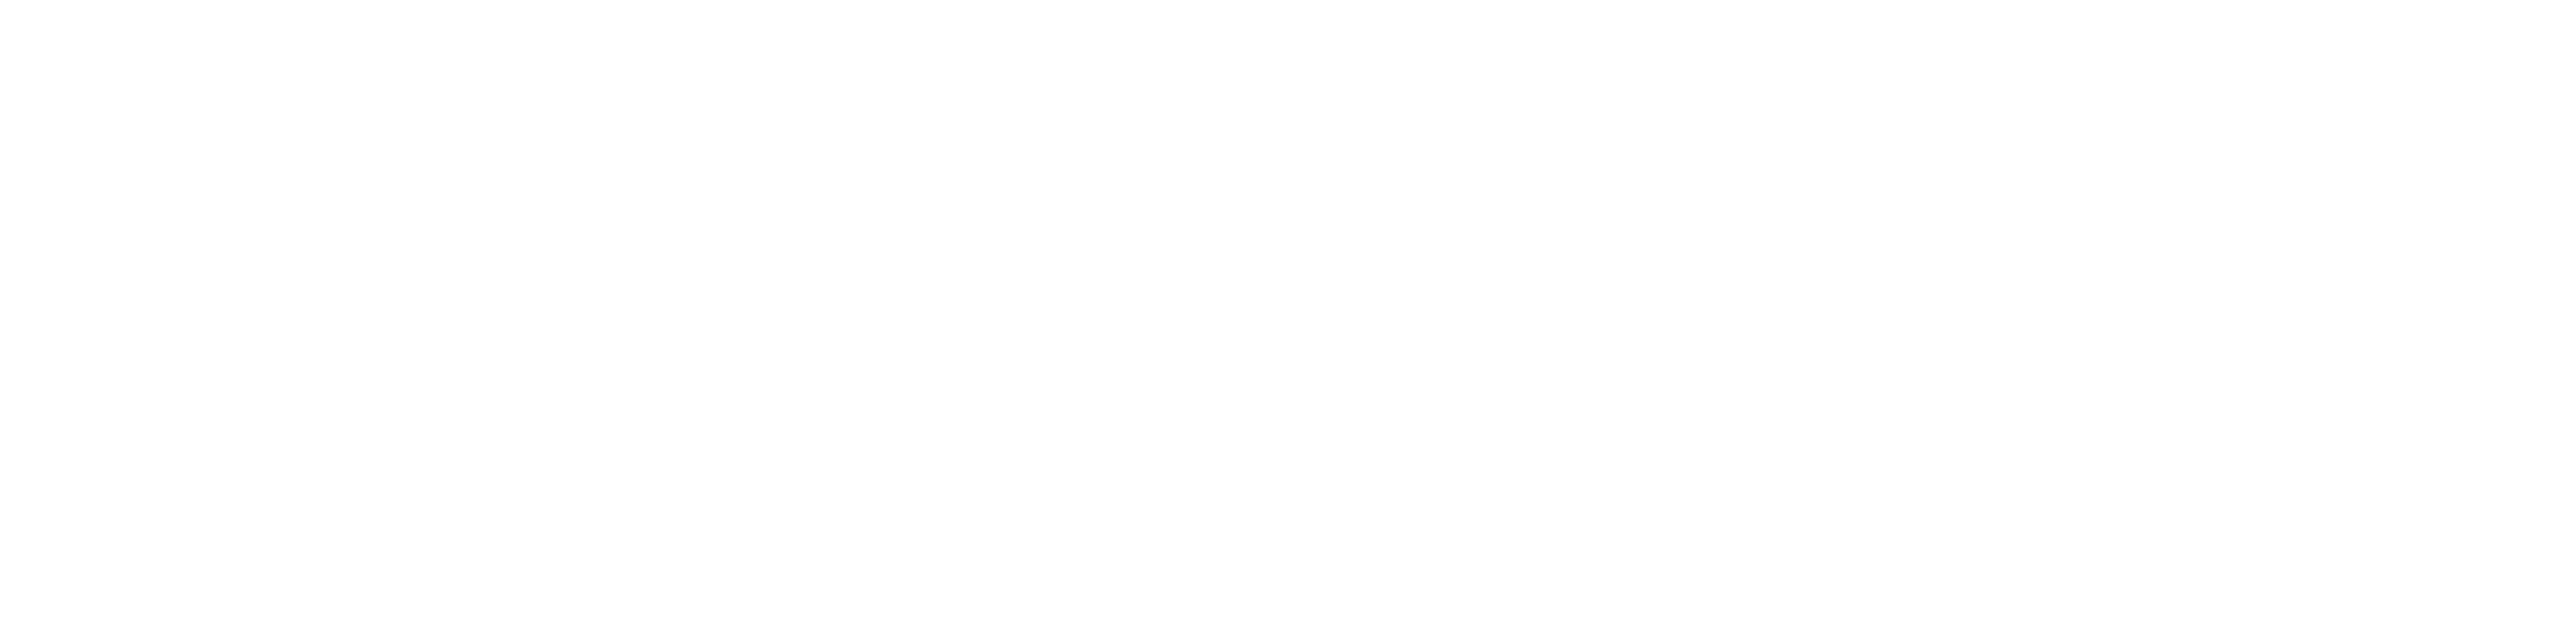

2020-05-29 12:54:22,388 logger INFO loss 1.18, 3D Dis:  6.44mm, poseDiff: 0.33, MemUsed:180.06
2020-05-29 12:54:32,852 logger INFO loss 1.18, 3D Dis:  6.44mm, poseDiff: 0.34, MemUsed:180.06
2020-05-29 12:54:43,296 logger INFO loss 1.18, 3D Dis:  6.45mm, poseDiff: 0.34, MemUsed:180.06
2020-05-29 12:54:54,057 logger INFO loss 1.18, 3D Dis:  6.46mm, poseDiff: 0.34, MemUsed:180.06
2020-05-29 12:55:04,862 logger INFO loss 1.18, 3D Dis:  6.47mm, poseDiff: 0.35, MemUsed:180.06


<IPython.core.display.Javascript object>


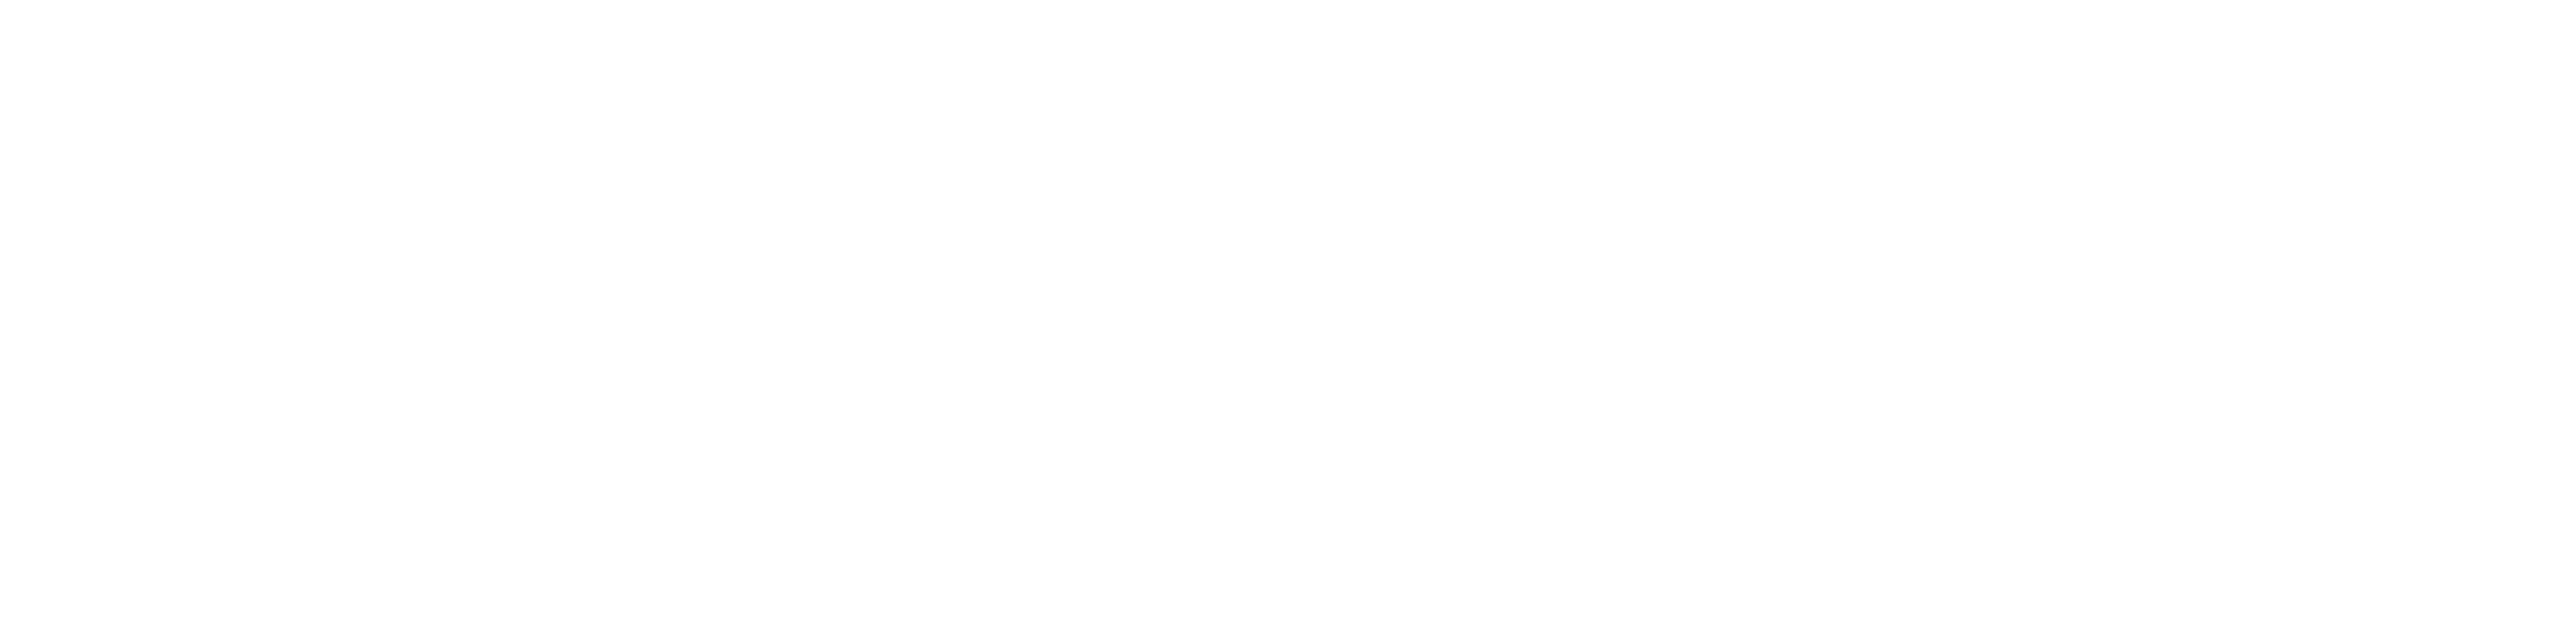

2020-05-29 12:55:38,798 logger INFO loss 1.18, 3D Dis:  6.48mm, poseDiff: 0.35, MemUsed:180.06
2020-05-29 12:55:49,217 logger INFO loss 1.18, 3D Dis:  6.49mm, poseDiff: 0.36, MemUsed:180.06
2020-05-29 12:55:59,819 logger INFO loss 1.18, 3D Dis:  6.50mm, poseDiff: 0.36, MemUsed:180.06
2020-05-29 12:56:10,485 logger INFO loss 1.18, 3D Dis:  6.51mm, poseDiff: 0.36, MemUsed:180.06
2020-05-29 12:56:21,274 logger INFO loss 1.18, 3D Dis:  6.51mm, poseDiff: 0.37, MemUsed:180.06


<IPython.core.display.Javascript object>


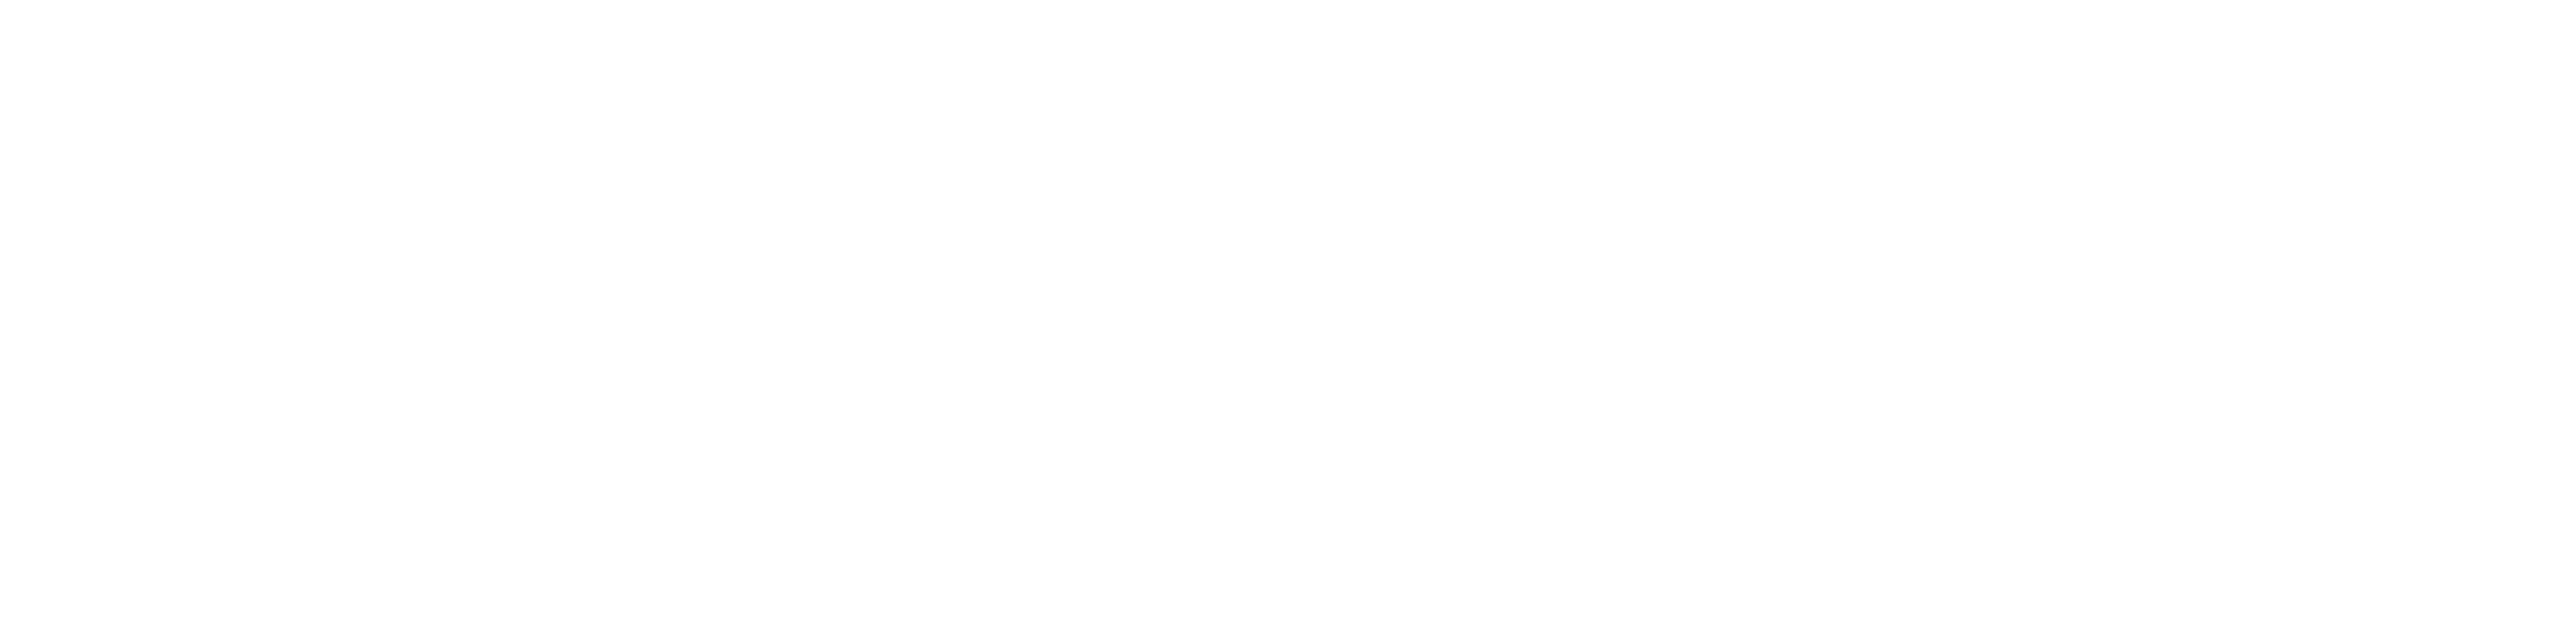

2020-05-29 12:56:55,085 logger INFO loss 1.18, 3D Dis:  6.51mm, poseDiff: 0.37, MemUsed:180.06
2020-05-29 12:57:05,566 logger INFO loss 1.18, 3D Dis:  6.51mm, poseDiff: 0.38, MemUsed:180.06
2020-05-29 12:57:16,257 logger INFO loss 1.18, 3D Dis:  6.51mm, poseDiff: 0.38, MemUsed:180.06
2020-05-29 12:57:26,911 logger INFO loss 1.18, 3D Dis:  6.50mm, poseDiff: 0.38, MemUsed:180.06
2020-05-29 12:57:37,555 logger INFO loss 1.18, 3D Dis:  6.50mm, poseDiff: 0.39, MemUsed:180.06


<IPython.core.display.Javascript object>


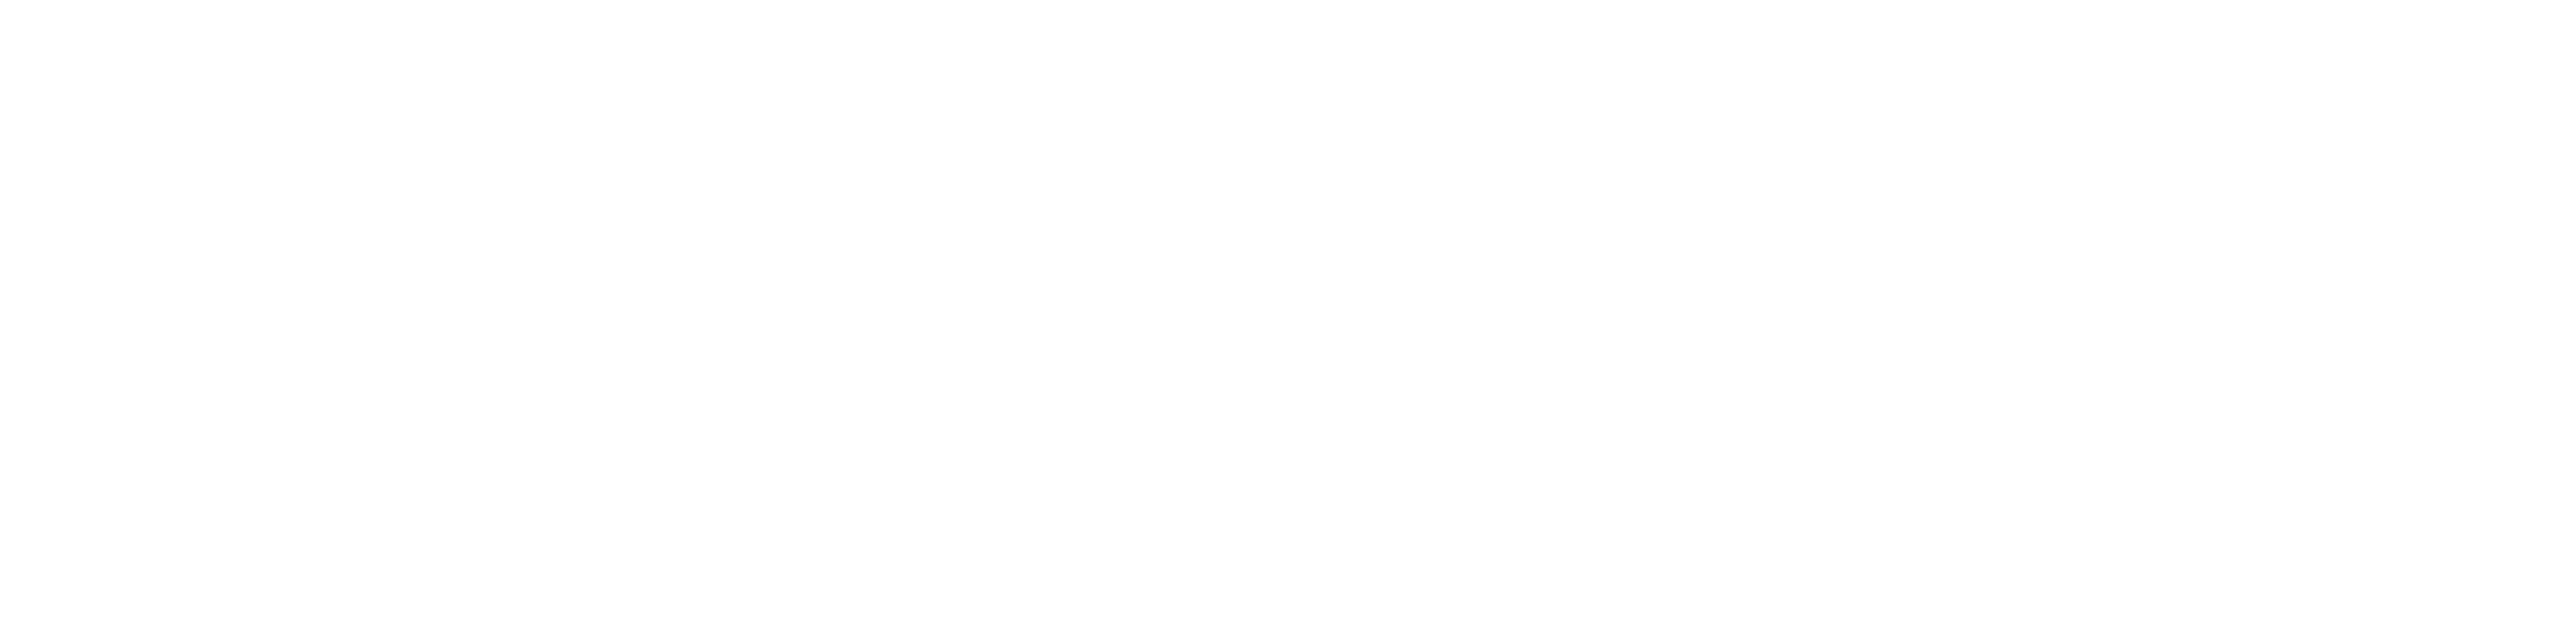

2020-05-29 12:58:11,123 logger INFO loss 1.18, 3D Dis:  6.51mm, poseDiff: 0.39, MemUsed:180.06
2020-05-29 12:58:21,537 logger INFO loss 1.18, 3D Dis:  6.51mm, poseDiff: 0.40, MemUsed:180.06
2020-05-29 12:58:32,249 logger INFO loss 1.18, 3D Dis:  6.52mm, poseDiff: 0.40, MemUsed:180.06
2020-05-29 12:58:42,778 logger INFO loss 1.18, 3D Dis:  6.53mm, poseDiff: 0.40, MemUsed:180.06
2020-05-29 12:58:53,484 logger INFO loss 1.18, 3D Dis:  6.54mm, poseDiff: 0.41, MemUsed:180.06


<IPython.core.display.Javascript object>


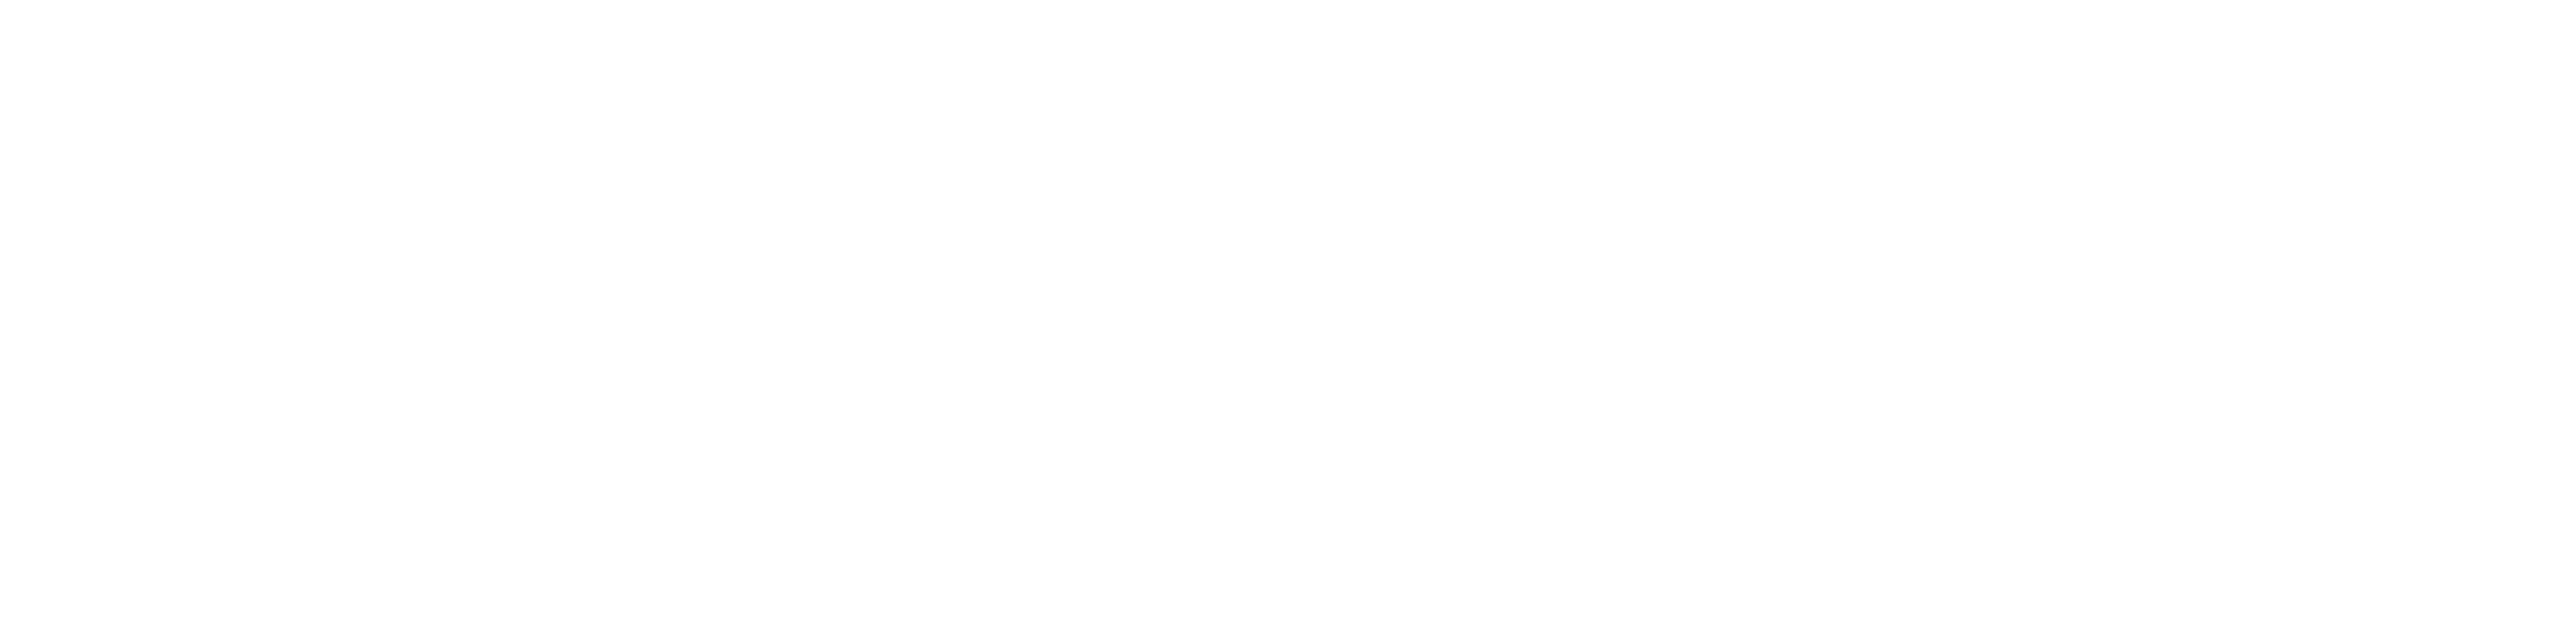

2020-05-29 12:59:27,662 logger INFO loss 1.18, 3D Dis:  6.55mm, poseDiff: 0.41, MemUsed:180.06
2020-05-29 12:59:37,969 logger INFO loss 1.18, 3D Dis:  6.56mm, poseDiff: 0.42, MemUsed:180.06
2020-05-29 12:59:48,557 logger INFO loss 1.18, 3D Dis:  6.57mm, poseDiff: 0.42, MemUsed:180.06
2020-05-29 12:59:59,027 logger INFO loss 1.18, 3D Dis:  6.58mm, poseDiff: 0.43, MemUsed:180.06
2020-05-29 13:00:09,949 logger INFO loss 1.18, 3D Dis:  6.59mm, poseDiff: 0.43, MemUsed:180.06


<IPython.core.display.Javascript object>


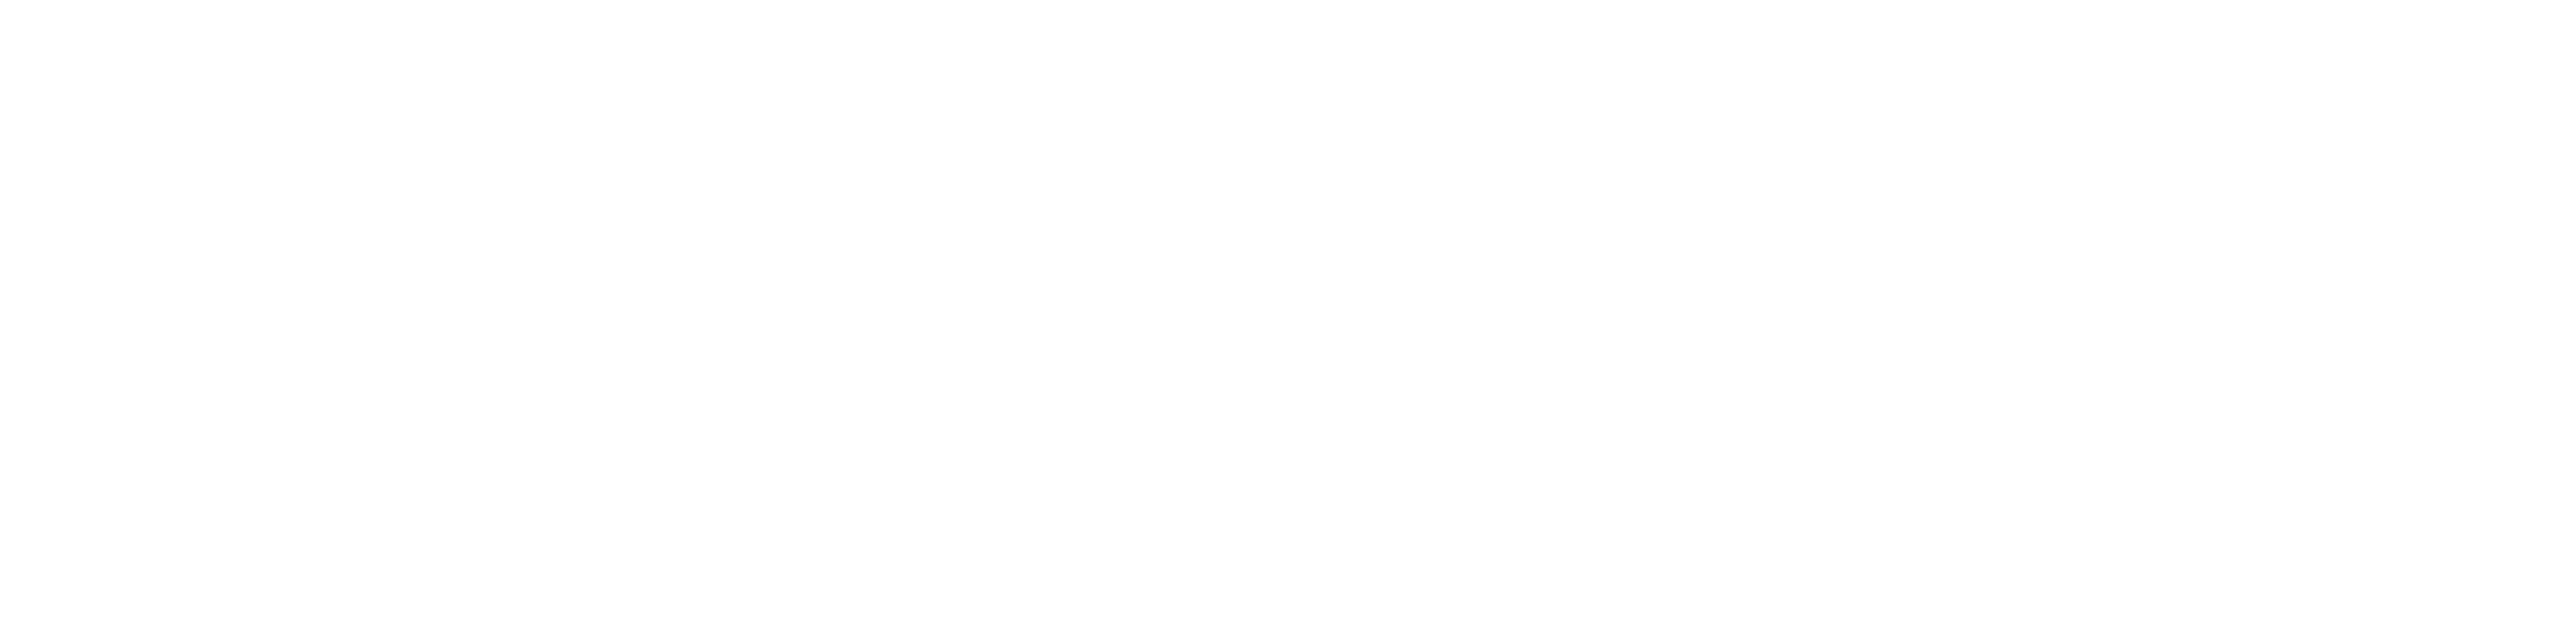

2020-05-29 13:00:43,846 logger INFO loss 1.18, 3D Dis:  6.60mm, poseDiff: 0.44, MemUsed:180.06
2020-05-29 13:00:54,148 logger INFO loss 1.18, 3D Dis:  6.60mm, poseDiff: 0.44, MemUsed:180.06
2020-05-29 13:01:04,846 logger INFO loss 1.18, 3D Dis:  6.61mm, poseDiff: 0.45, MemUsed:180.06
2020-05-29 13:01:15,284 logger INFO loss 1.18, 3D Dis:  6.62mm, poseDiff: 0.45, MemUsed:180.06
2020-05-29 13:01:26,220 logger INFO loss 1.18, 3D Dis:  6.63mm, poseDiff: 0.46, MemUsed:180.06


<IPython.core.display.Javascript object>


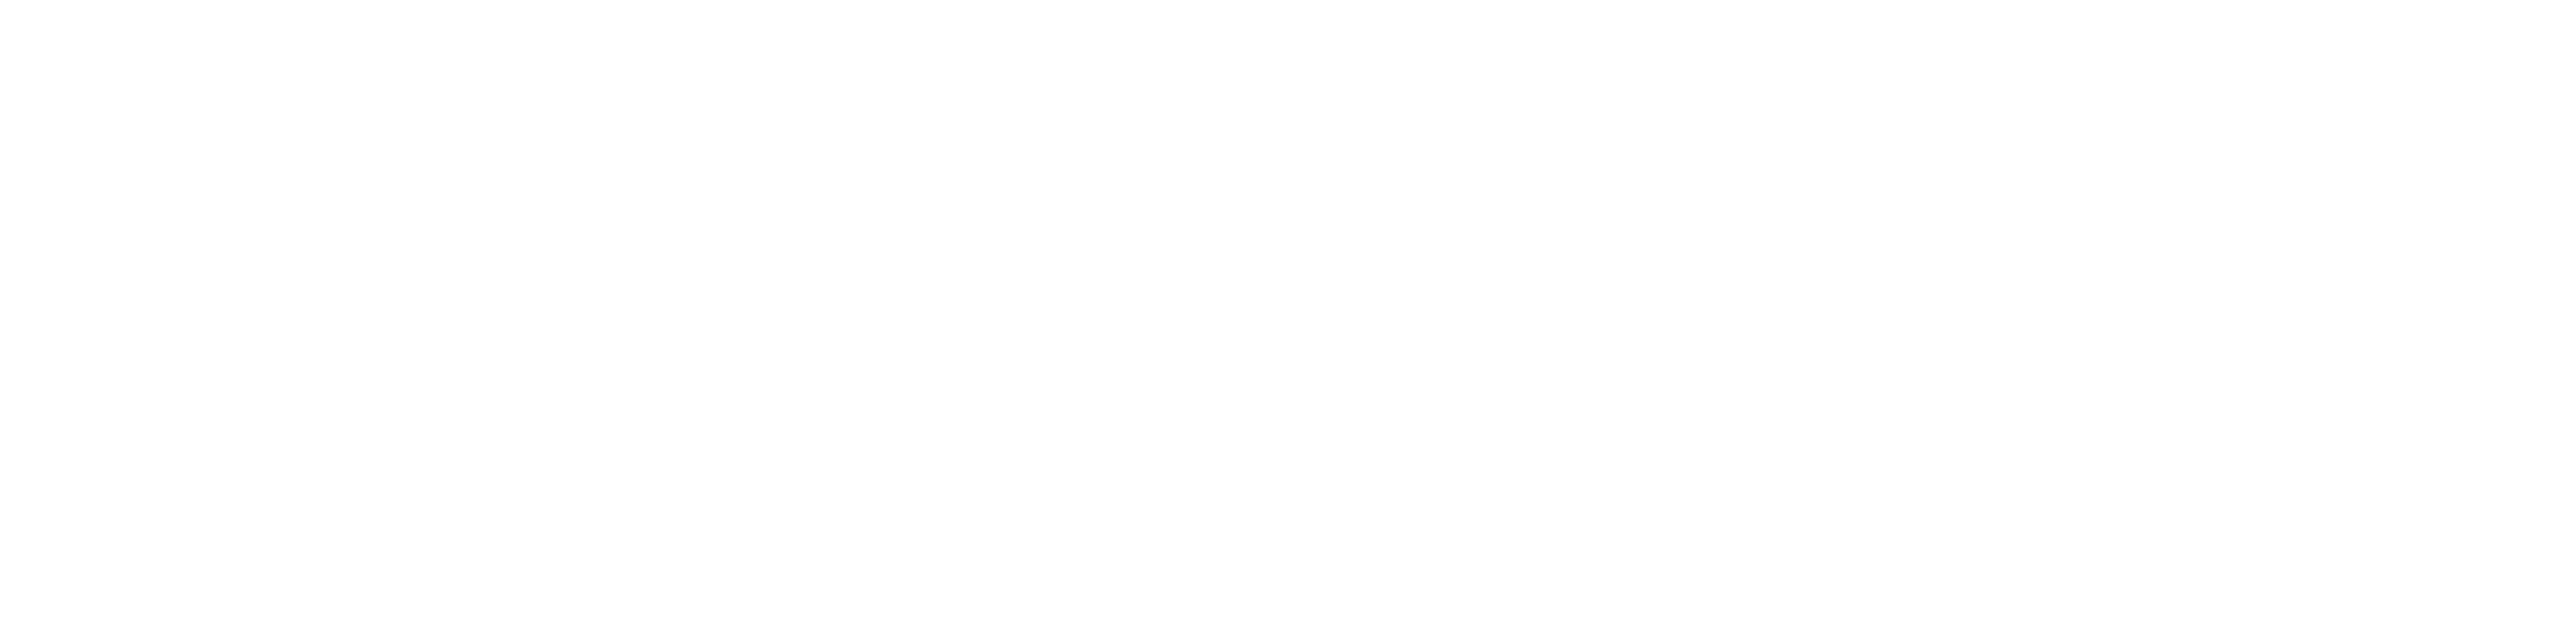

2020-05-29 13:01:59,900 logger INFO loss 1.18, 3D Dis:  6.64mm, poseDiff: 0.46, MemUsed:180.06
2020-05-29 13:02:10,321 logger INFO loss 1.18, 3D Dis:  6.65mm, poseDiff: 0.47, MemUsed:180.06
2020-05-29 13:02:21,014 logger INFO loss 1.18, 3D Dis:  6.66mm, poseDiff: 0.47, MemUsed:180.06
2020-05-29 13:02:31,745 logger INFO loss 1.18, 3D Dis:  6.67mm, poseDiff: 0.48, MemUsed:180.06
2020-05-29 13:02:42,487 logger INFO loss 1.17, 3D Dis:  6.67mm, poseDiff: 0.48, MemUsed:180.06


<IPython.core.display.Javascript object>


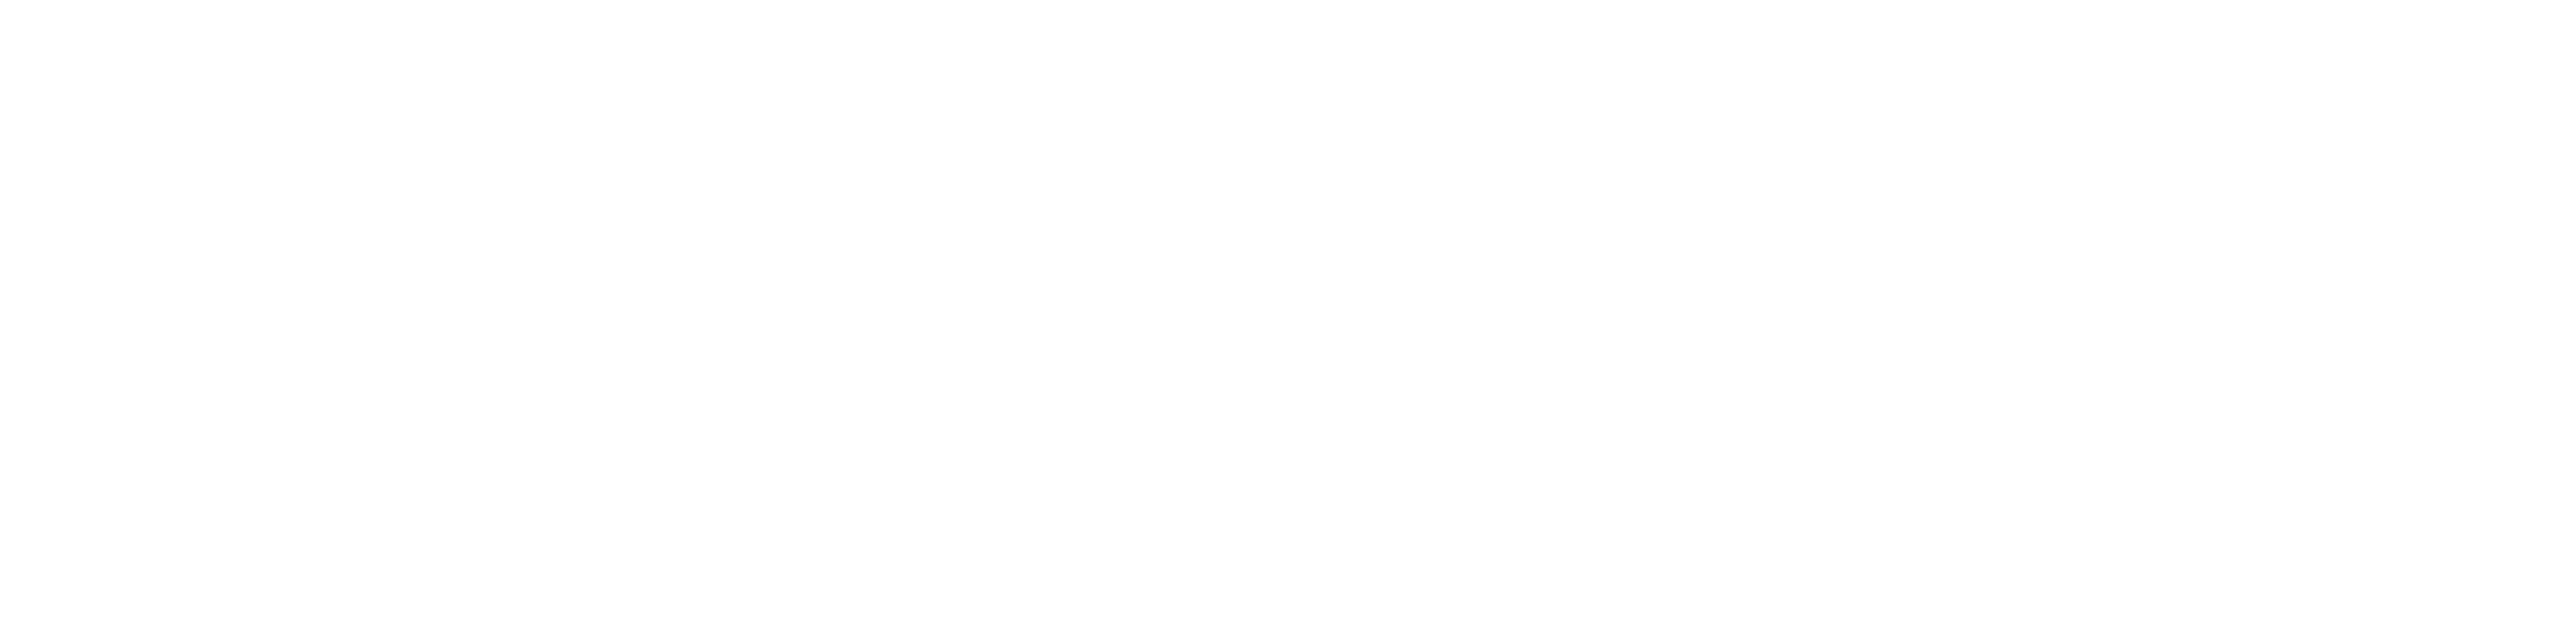

2020-05-29 13:03:16,327 logger INFO loss 1.17, 3D Dis:  6.68mm, poseDiff: 0.49, MemUsed:180.06
2020-05-29 13:03:26,783 logger INFO loss 1.17, 3D Dis:  6.69mm, poseDiff: 0.49, MemUsed:180.06
2020-05-29 13:03:37,418 logger INFO loss 1.17, 3D Dis:  6.71mm, poseDiff: 0.50, MemUsed:180.06
2020-05-29 13:03:48,049 logger INFO loss 1.17, 3D Dis:  6.72mm, poseDiff: 0.50, MemUsed:180.06
2020-05-29 13:03:58,732 logger INFO loss 1.17, 3D Dis:  6.73mm, poseDiff: 0.51, MemUsed:180.06


<IPython.core.display.Javascript object>


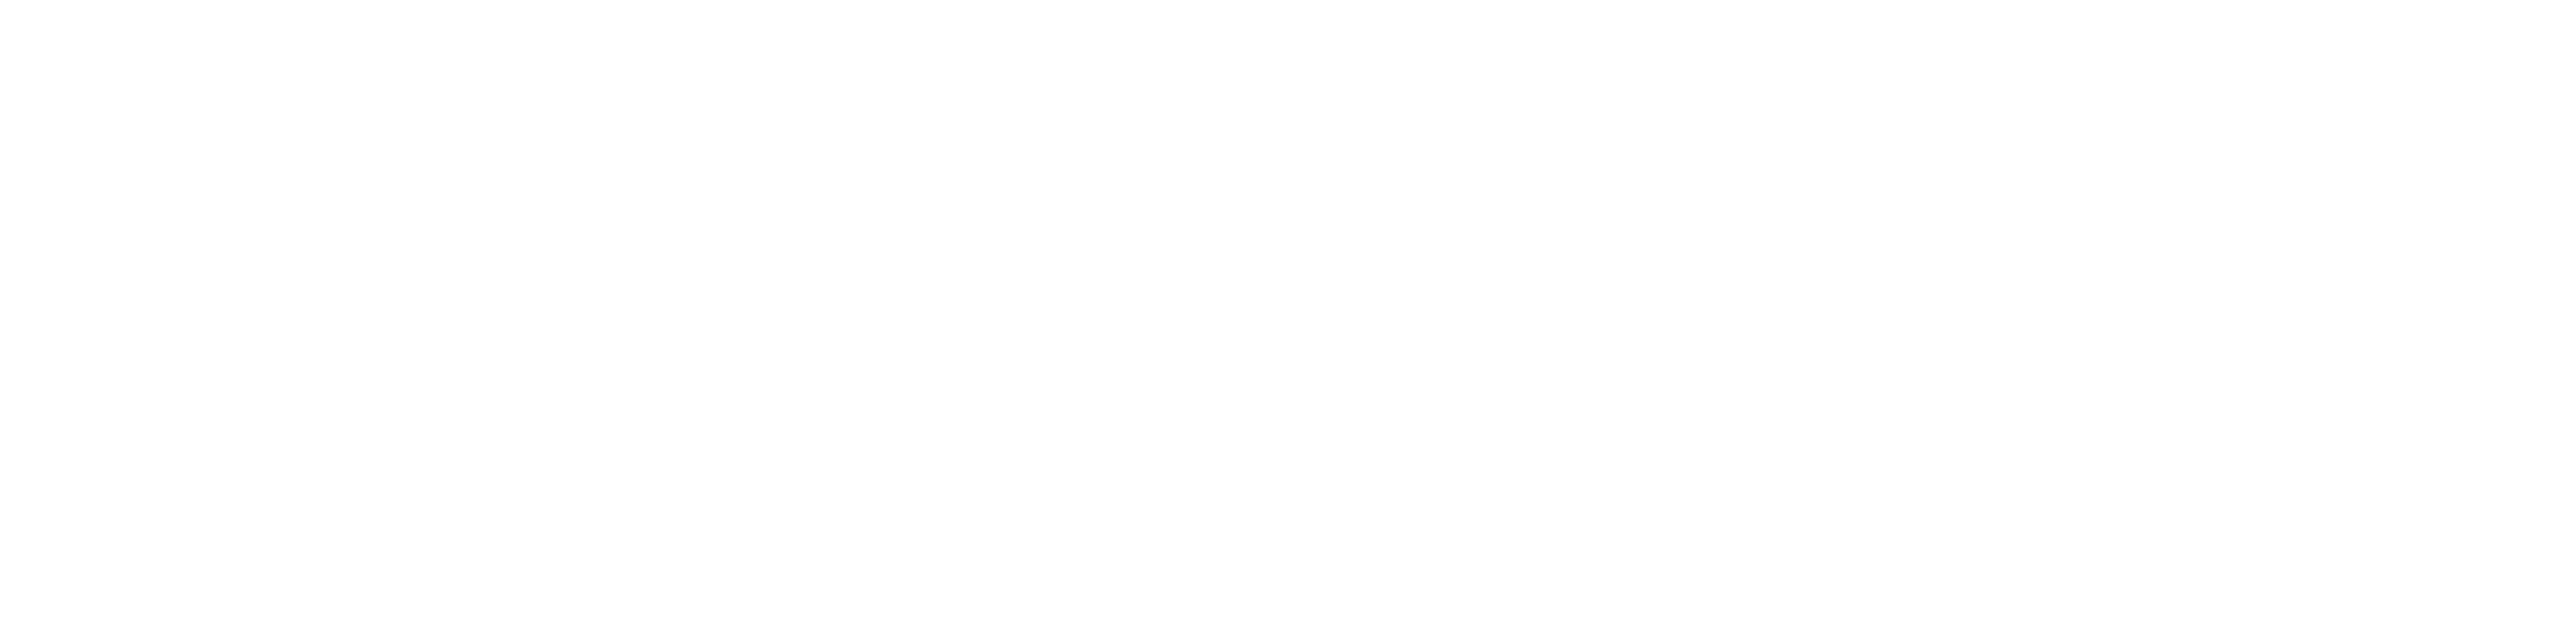

2020-05-29 13:04:32,583 logger INFO loss 1.17, 3D Dis:  6.75mm, poseDiff: 0.51, MemUsed:180.06
2020-05-29 13:04:43,065 logger INFO loss 1.17, 3D Dis:  6.76mm, poseDiff: 0.52, MemUsed:180.06
2020-05-29 13:04:53,731 logger INFO loss 1.17, 3D Dis:  6.77mm, poseDiff: 0.52, MemUsed:180.06
2020-05-29 13:05:04,428 logger INFO loss 1.17, 3D Dis:  6.78mm, poseDiff: 0.53, MemUsed:180.06
2020-05-29 13:05:15,217 logger INFO loss 1.17, 3D Dis:  6.80mm, poseDiff: 0.53, MemUsed:180.06


<IPython.core.display.Javascript object>


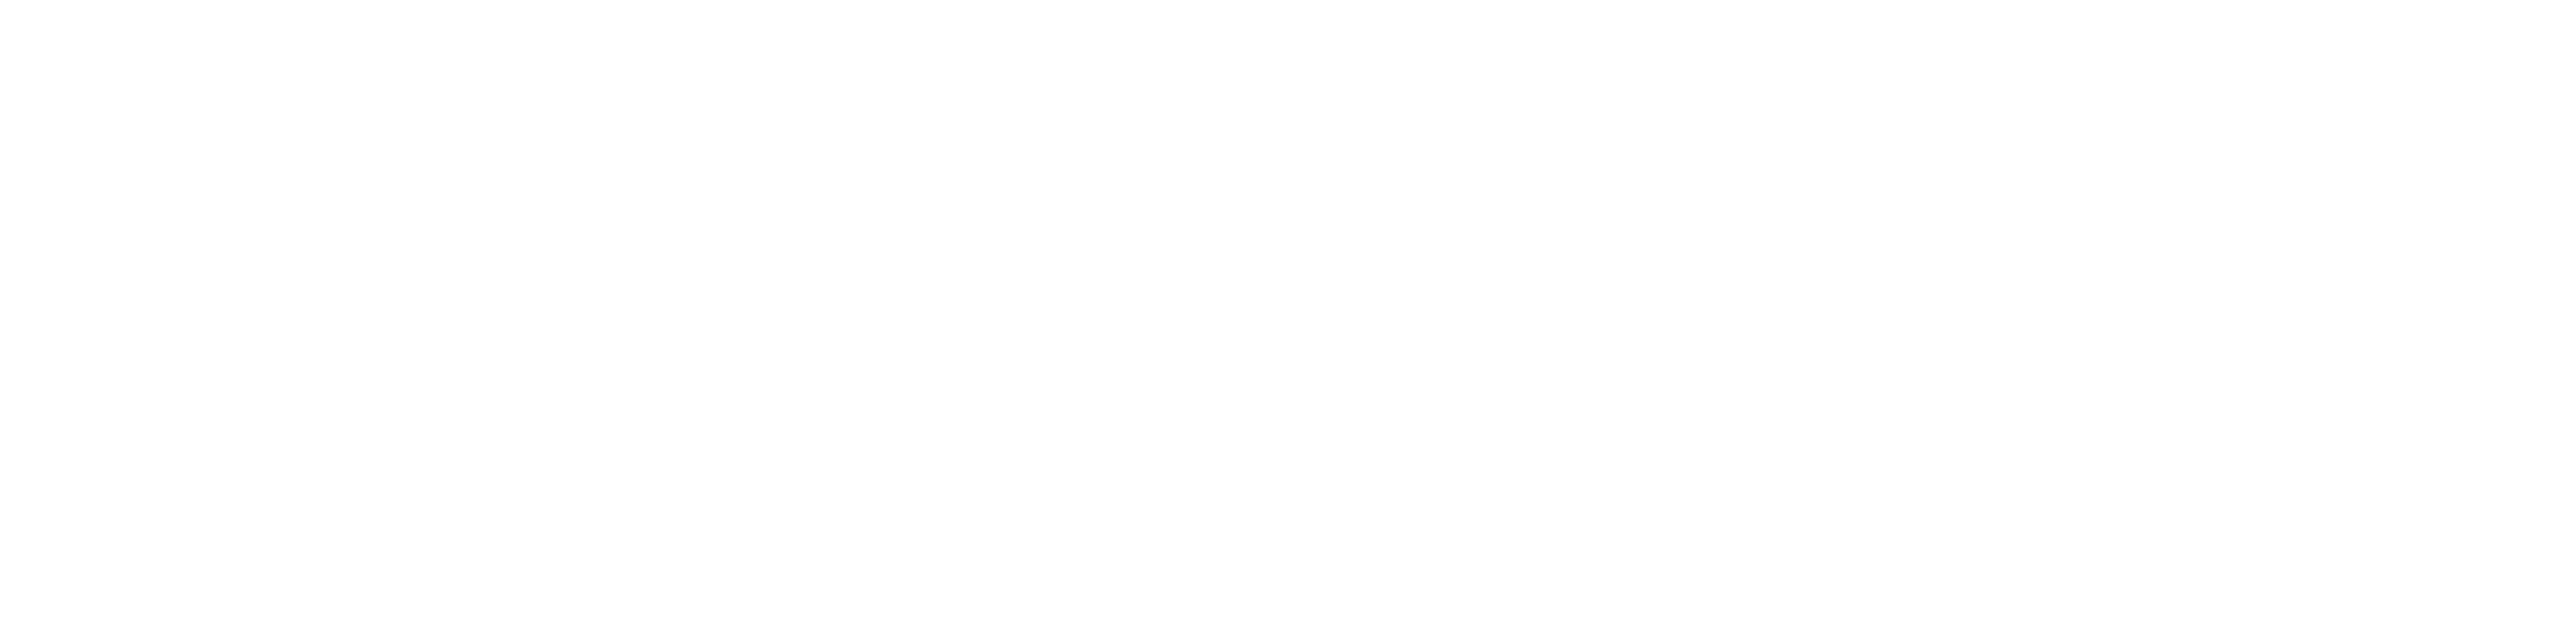

2020-05-29 13:05:48,786 logger INFO loss 1.17, 3D Dis:  6.81mm, poseDiff: 0.54, MemUsed:180.06
2020-05-29 13:05:59,248 logger INFO loss 1.17, 3D Dis:  6.82mm, poseDiff: 0.54, MemUsed:180.06
2020-05-29 13:06:09,856 logger INFO loss 1.17, 3D Dis:  6.84mm, poseDiff: 0.55, MemUsed:180.06
2020-05-29 13:06:20,591 logger INFO loss 1.17, 3D Dis:  6.85mm, poseDiff: 0.56, MemUsed:180.06
2020-05-29 13:06:31,293 logger INFO loss 1.17, 3D Dis:  6.87mm, poseDiff: 0.56, MemUsed:180.06


<IPython.core.display.Javascript object>


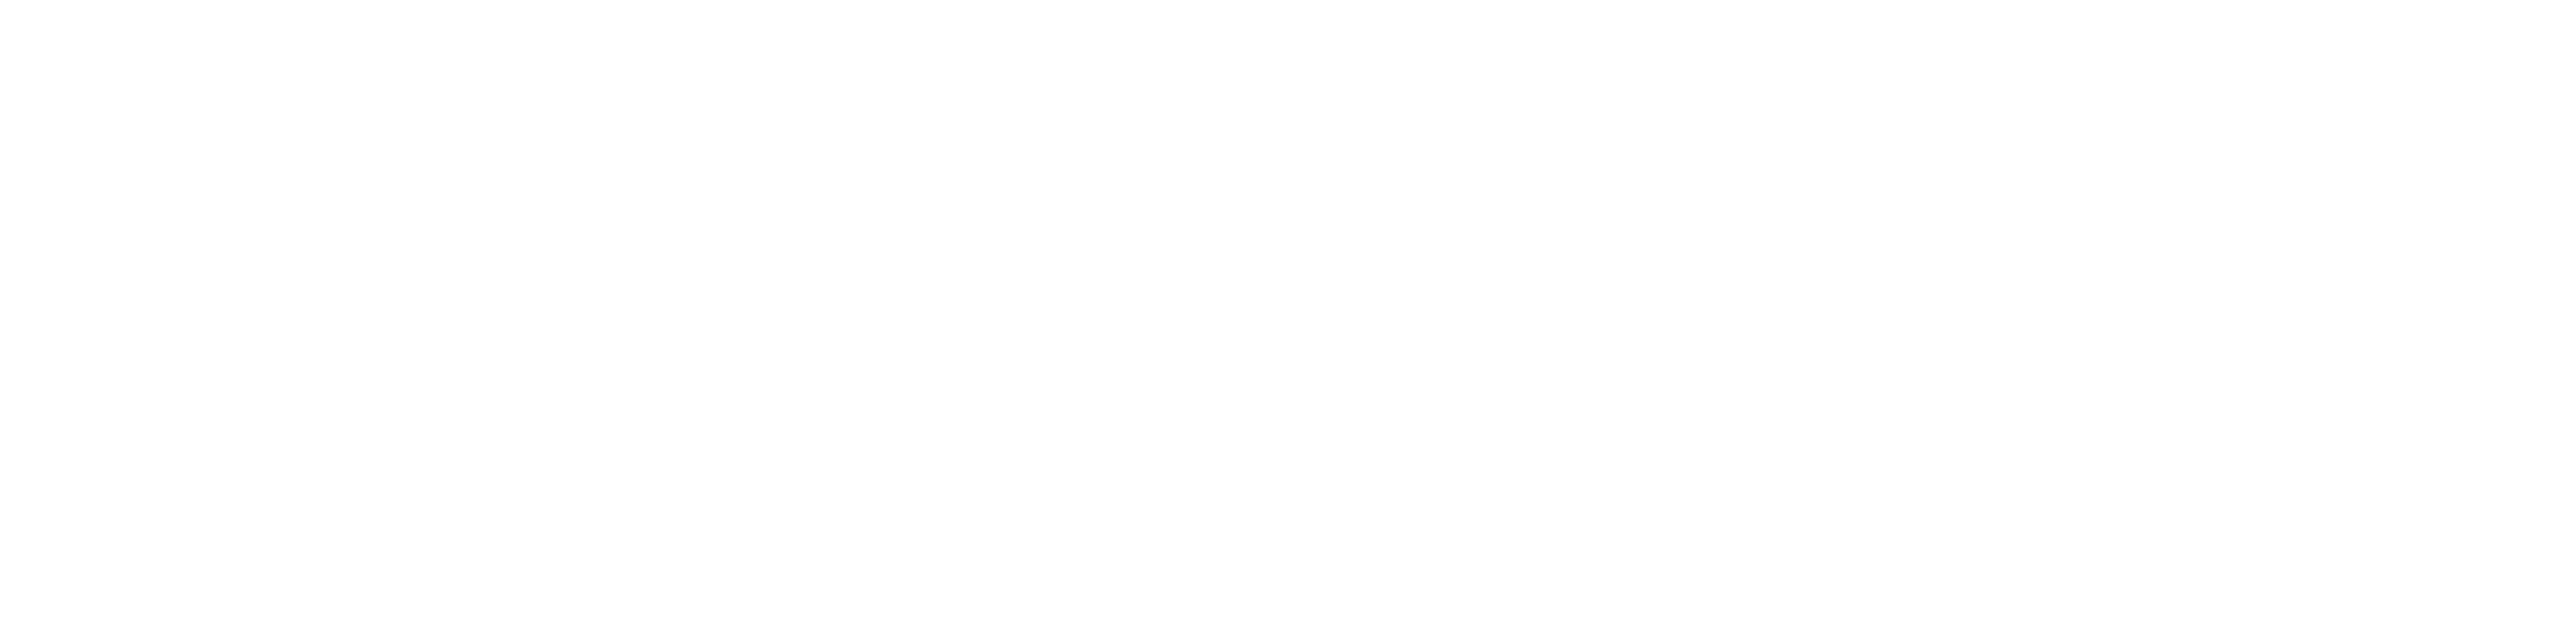

2020-05-29 13:07:05,236 logger INFO loss 1.17, 3D Dis:  6.88mm, poseDiff: 0.57, MemUsed:180.06
2020-05-29 13:07:15,551 logger INFO loss 1.17, 3D Dis:  6.89mm, poseDiff: 0.57, MemUsed:180.06
2020-05-29 13:07:26,137 logger INFO loss 1.17, 3D Dis:  6.91mm, poseDiff: 0.58, MemUsed:180.06
2020-05-29 13:07:36,812 logger INFO loss 1.17, 3D Dis:  6.92mm, poseDiff: 0.58, MemUsed:180.06
2020-05-29 13:07:47,559 logger INFO loss 1.17, 3D Dis:  6.94mm, poseDiff: 0.59, MemUsed:180.06


<IPython.core.display.Javascript object>


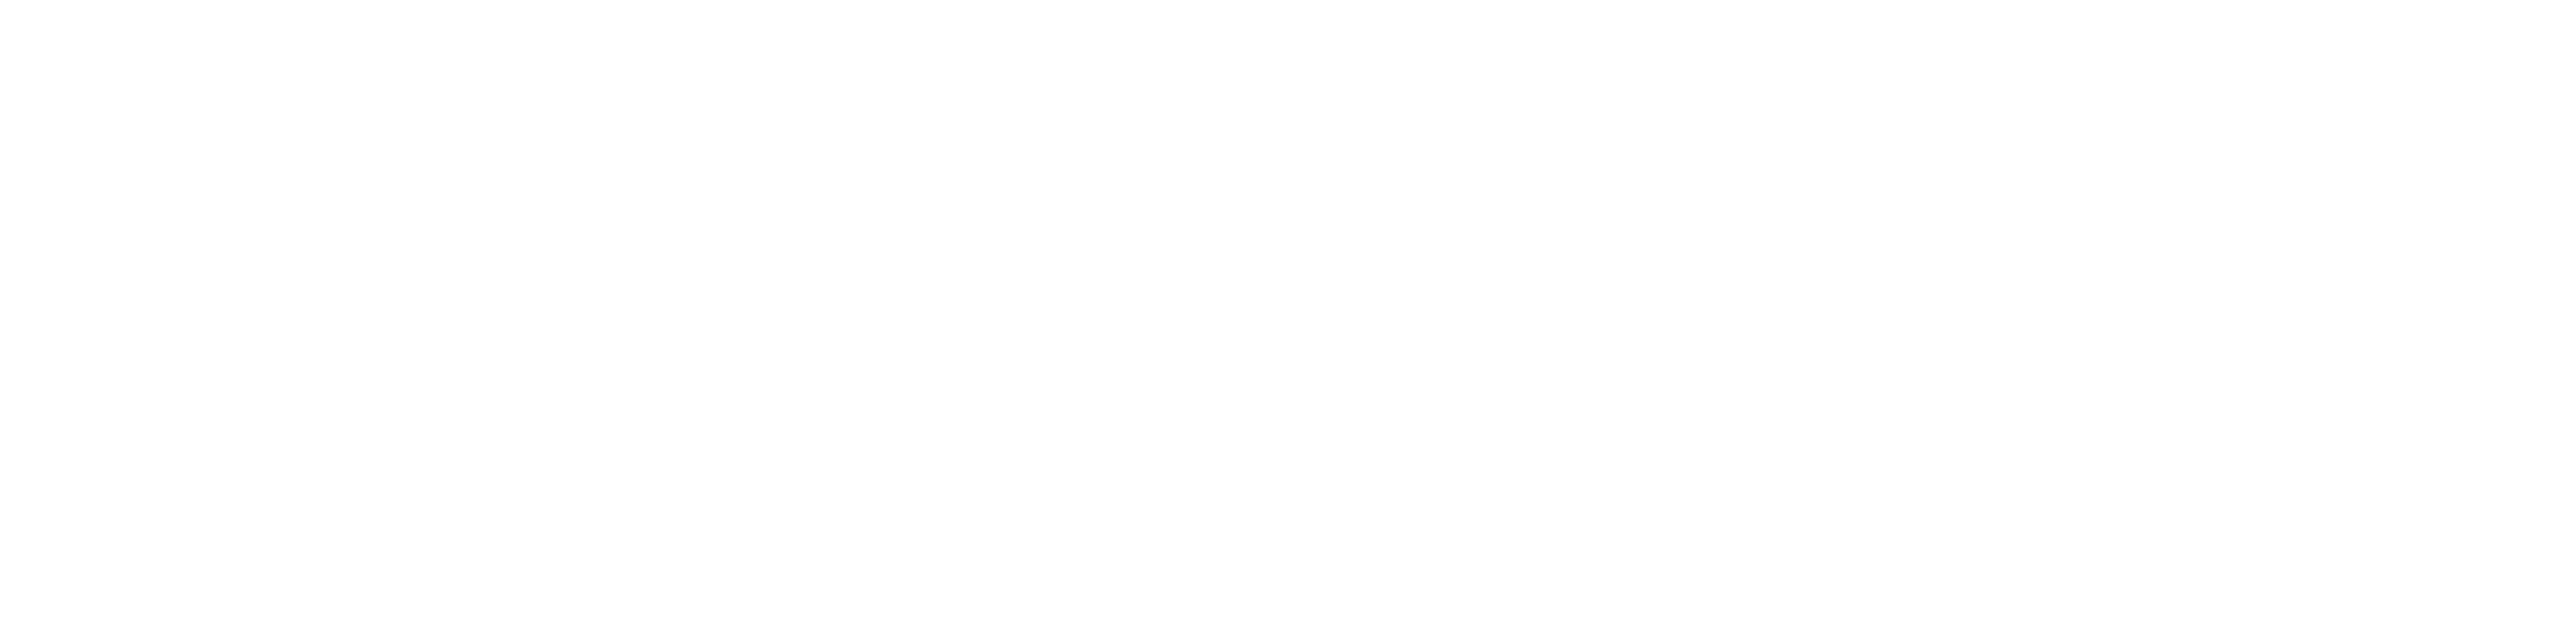

2020-05-29 13:08:21,208 logger INFO loss 1.17, 3D Dis:  6.95mm, poseDiff: 0.60, MemUsed:180.06
2020-05-29 13:08:31,705 logger INFO loss 1.17, 3D Dis:  6.97mm, poseDiff: 0.60, MemUsed:180.06
2020-05-29 13:08:42,262 logger INFO loss 1.17, 3D Dis:  6.99mm, poseDiff: 0.61, MemUsed:180.06
2020-05-29 13:08:52,926 logger INFO loss 1.17, 3D Dis:  7.00mm, poseDiff: 0.61, MemUsed:180.06
2020-05-29 13:09:03,827 logger INFO loss 1.17, 3D Dis:  7.02mm, poseDiff: 0.62, MemUsed:180.06


<IPython.core.display.Javascript object>


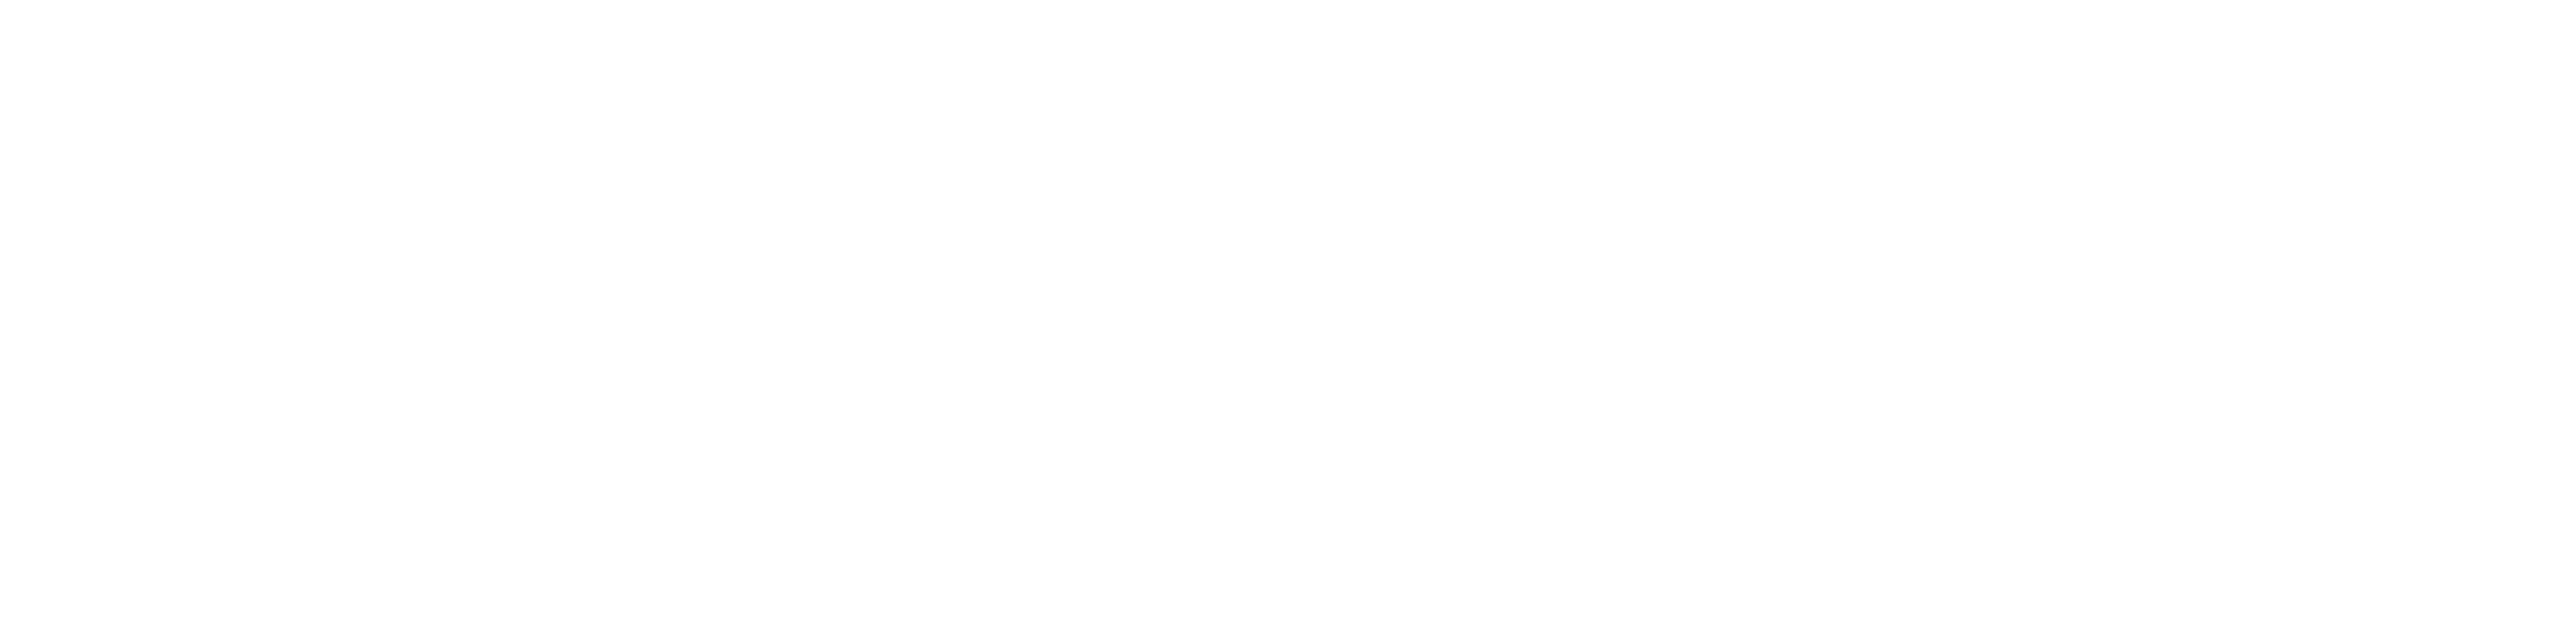

2020-05-29 13:09:37,671 logger INFO loss 1.17, 3D Dis:  7.03mm, poseDiff: 0.63, MemUsed:180.06
2020-05-29 13:09:48,084 logger INFO loss 1.17, 3D Dis:  7.04mm, poseDiff: 0.63, MemUsed:180.06
2020-05-29 13:09:58,548 logger INFO loss 1.17, 3D Dis:  7.05mm, poseDiff: 0.64, MemUsed:180.06
2020-05-29 13:10:09,313 logger INFO loss 1.17, 3D Dis:  7.07mm, poseDiff: 0.65, MemUsed:180.06
2020-05-29 13:10:20,092 logger INFO loss 1.17, 3D Dis:  7.08mm, poseDiff: 0.65, MemUsed:180.06


<IPython.core.display.Javascript object>


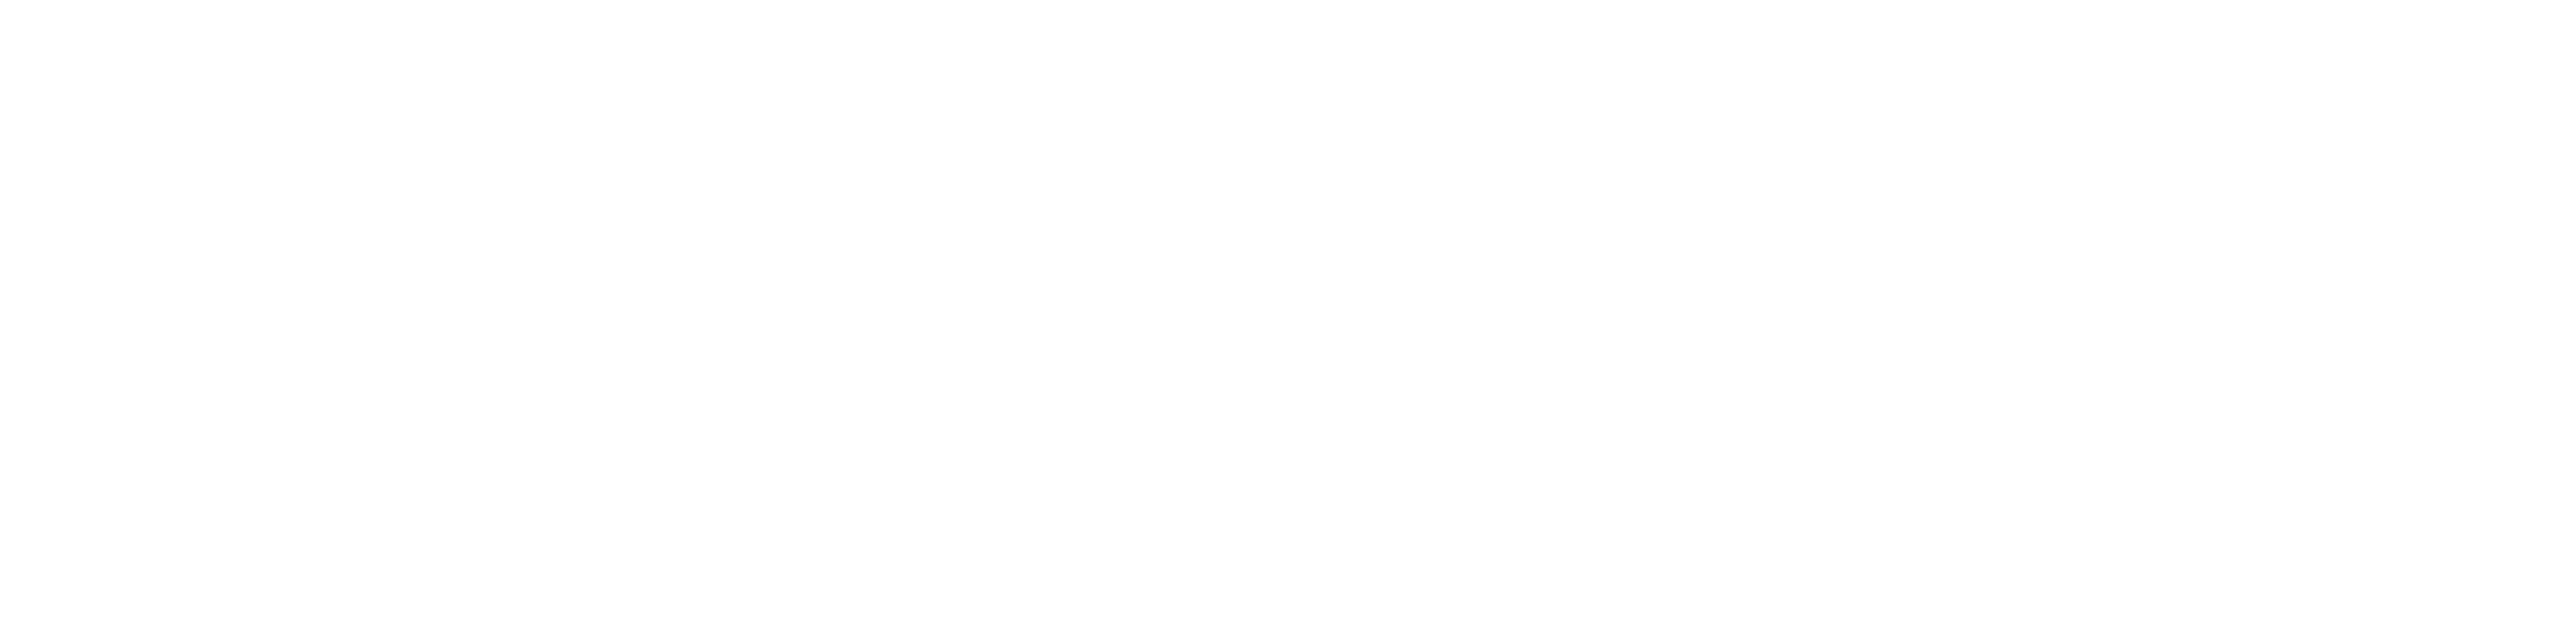

2020-05-29 13:10:53,842 logger INFO loss 1.17, 3D Dis:  7.09mm, poseDiff: 0.66, MemUsed:180.06
2020-05-29 13:11:04,349 logger INFO loss 1.17, 3D Dis:  7.11mm, poseDiff: 0.66, MemUsed:180.06
2020-05-29 13:11:15,051 logger INFO loss 1.17, 3D Dis:  7.12mm, poseDiff: 0.67, MemUsed:180.06
2020-05-29 13:11:25,743 logger INFO loss 1.16, 3D Dis:  7.14mm, poseDiff: 0.68, MemUsed:180.06
2020-05-29 13:11:36,430 logger INFO loss 1.16, 3D Dis:  7.16mm, poseDiff: 0.68, MemUsed:180.06


<IPython.core.display.Javascript object>


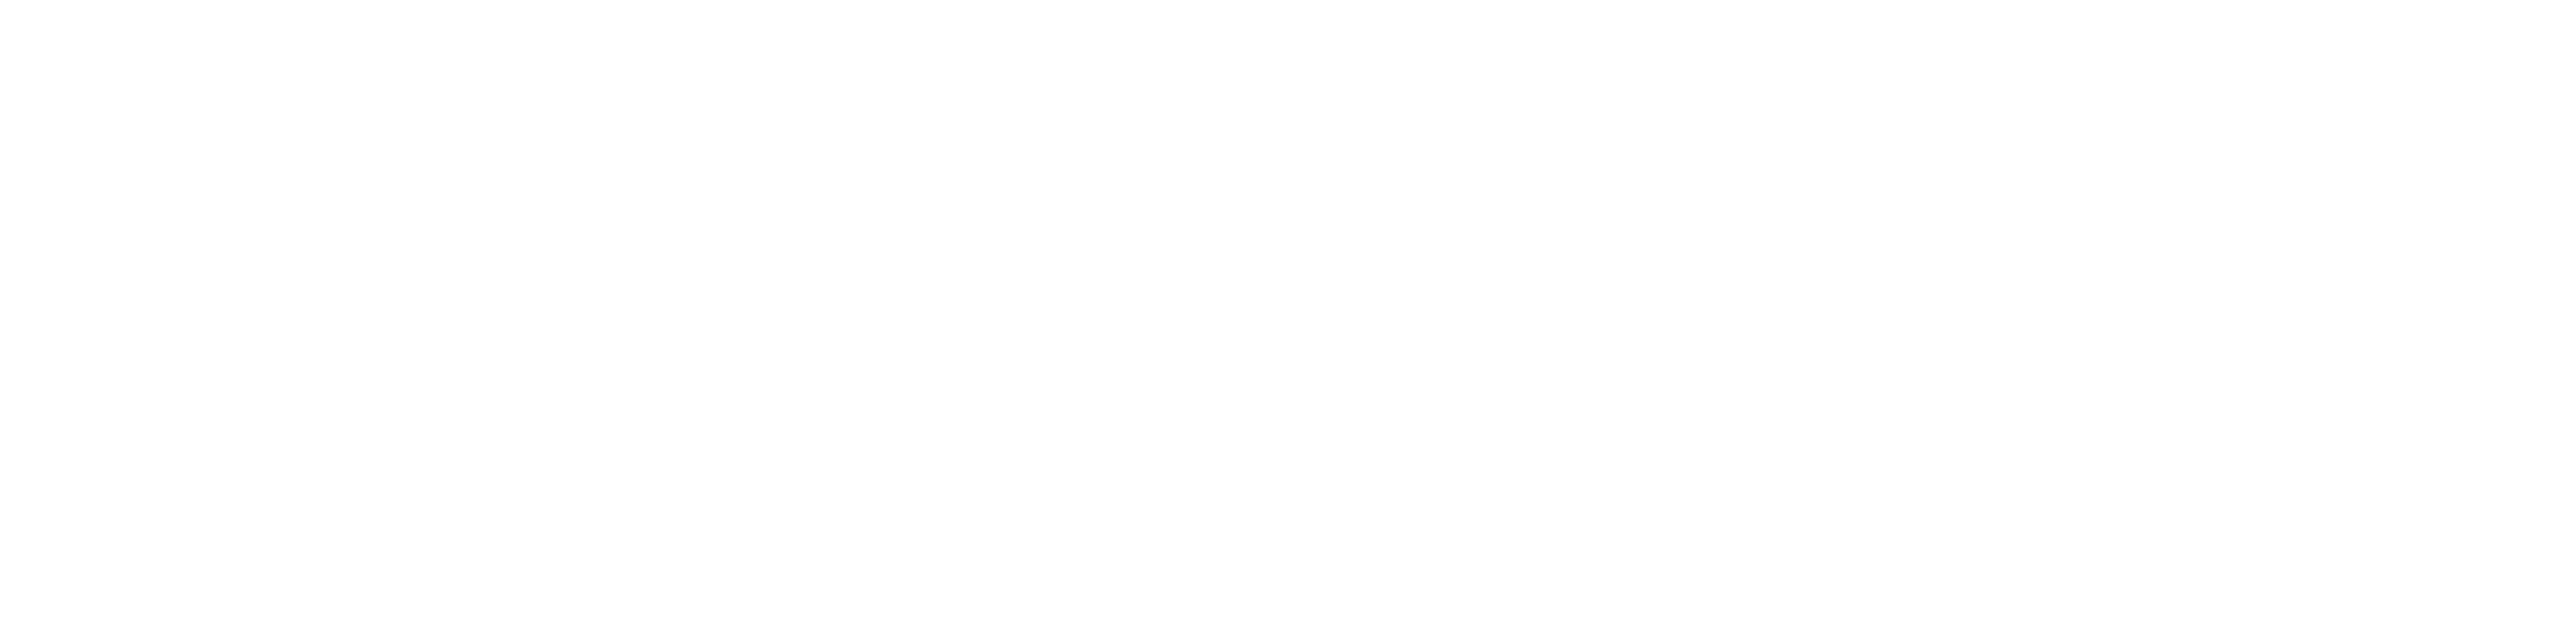

2020-05-29 13:12:10,061 logger INFO loss 1.16, 3D Dis:  7.17mm, poseDiff: 0.69, MemUsed:180.06
2020-05-29 13:12:20,664 logger INFO loss 1.16, 3D Dis:  7.19mm, poseDiff: 0.70, MemUsed:180.06
2020-05-29 13:12:31,195 logger INFO loss 1.16, 3D Dis:  7.21mm, poseDiff: 0.70, MemUsed:180.06
2020-05-29 13:12:41,924 logger INFO loss 1.16, 3D Dis:  7.22mm, poseDiff: 0.71, MemUsed:180.06
2020-05-29 13:12:52,581 logger INFO loss 1.16, 3D Dis:  7.24mm, poseDiff: 0.72, MemUsed:180.06


<IPython.core.display.Javascript object>


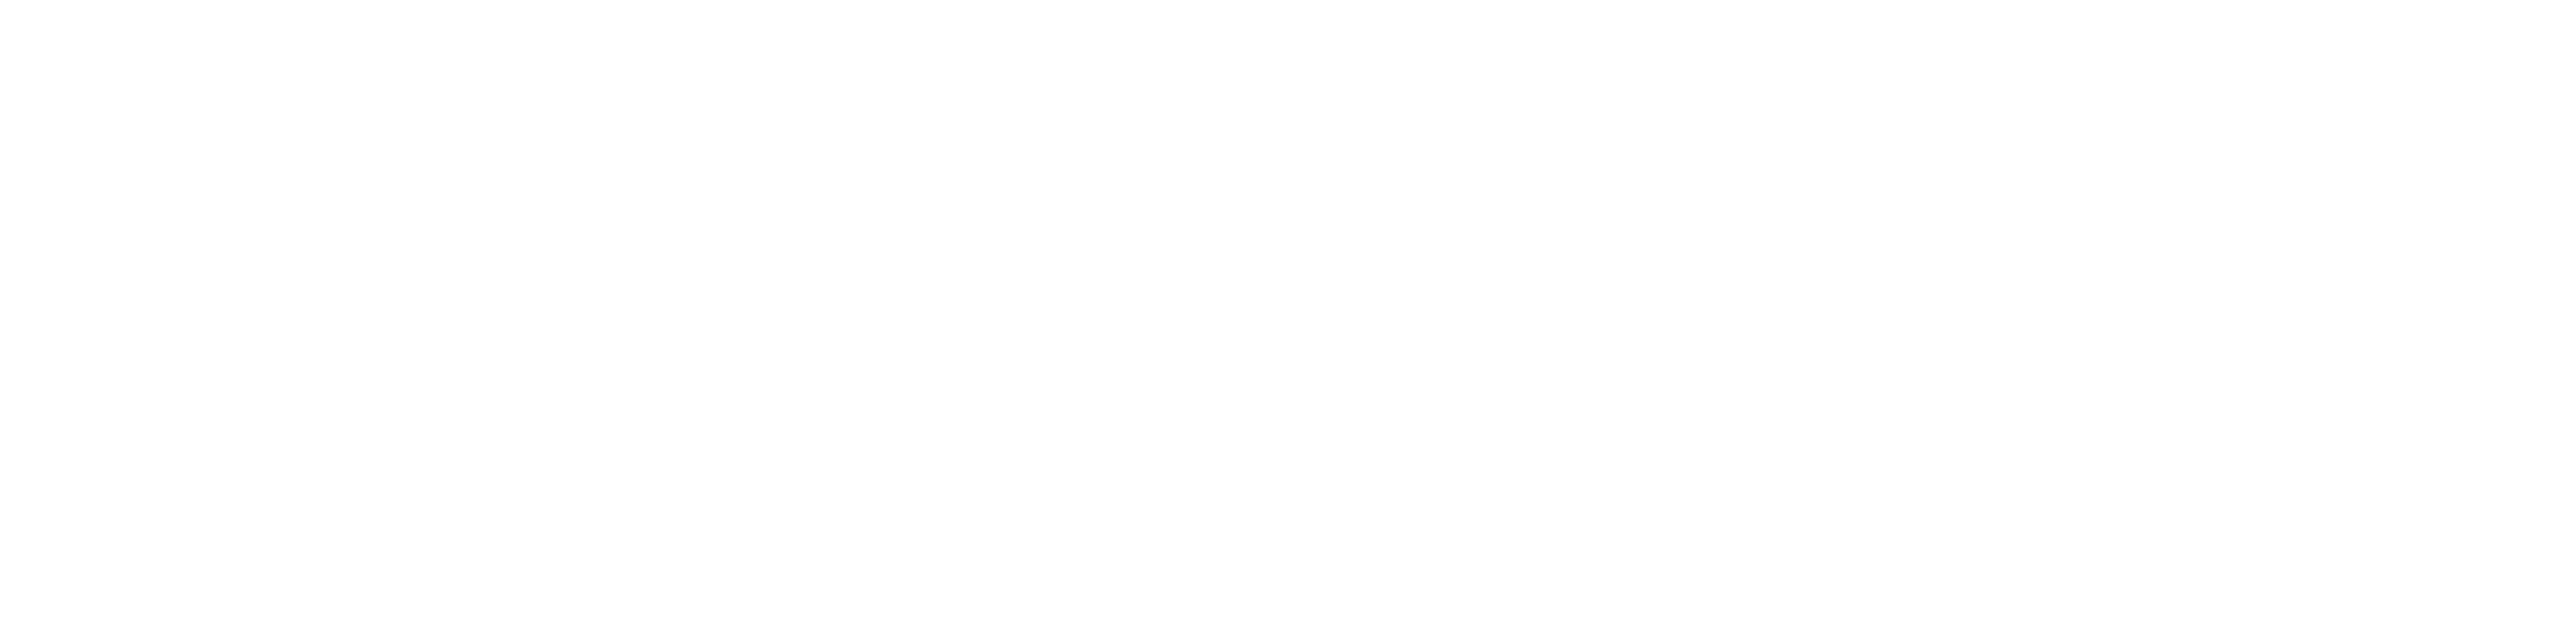

2020-05-29 13:13:26,407 logger INFO loss 1.16, 3D Dis:  7.25mm, poseDiff: 0.72, MemUsed:180.06
2020-05-29 13:13:36,827 logger INFO loss 1.16, 3D Dis:  7.26mm, poseDiff: 0.73, MemUsed:180.06
2020-05-29 13:13:47,396 logger INFO loss 1.16, 3D Dis:  7.28mm, poseDiff: 0.74, MemUsed:180.06
2020-05-29 13:13:58,254 logger INFO loss 1.16, 3D Dis:  7.29mm, poseDiff: 0.75, MemUsed:180.06
2020-05-29 13:14:08,930 logger INFO loss 1.16, 3D Dis:  7.30mm, poseDiff: 0.75, MemUsed:180.06


<IPython.core.display.Javascript object>


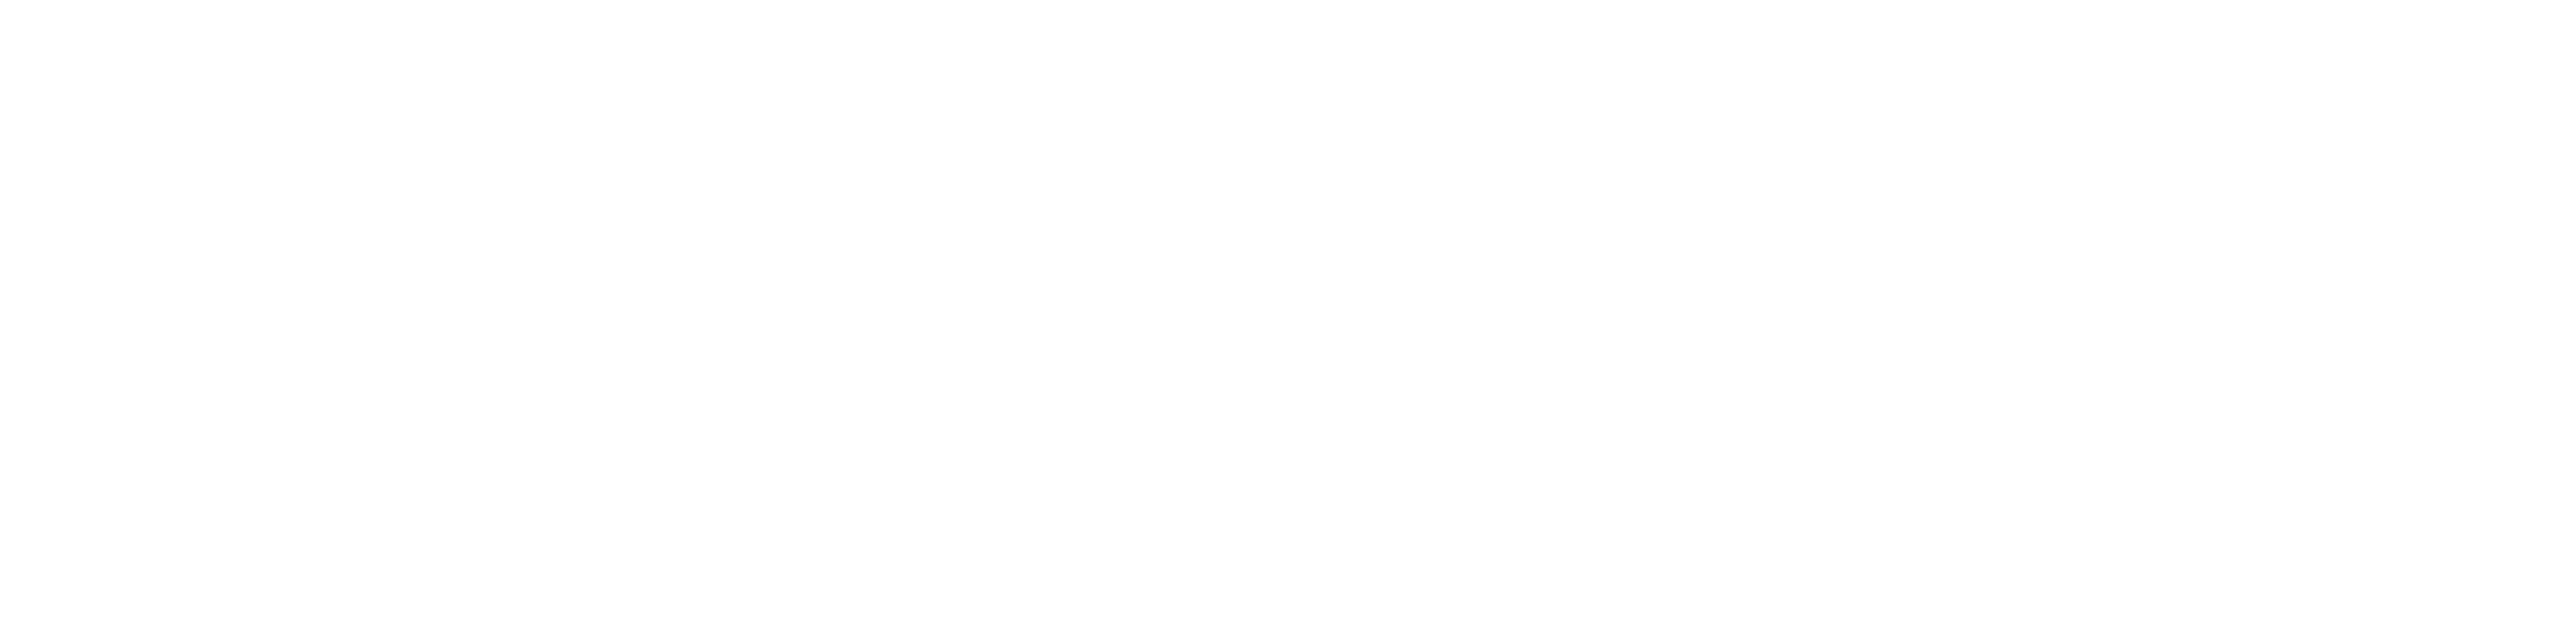

2020-05-29 13:14:43,022 logger INFO loss 1.16, 3D Dis:  7.32mm, poseDiff: 0.76, MemUsed:180.06
2020-05-29 13:14:53,368 logger INFO loss 1.16, 3D Dis:  7.33mm, poseDiff: 0.77, MemUsed:180.06
2020-05-29 13:15:04,086 logger INFO loss 1.16, 3D Dis:  7.34mm, poseDiff: 0.77, MemUsed:180.06
2020-05-29 13:15:14,762 logger INFO loss 1.16, 3D Dis:  7.36mm, poseDiff: 0.78, MemUsed:180.06
2020-05-29 13:15:25,327 logger INFO loss 1.16, 3D Dis:  7.37mm, poseDiff: 0.79, MemUsed:180.06


<IPython.core.display.Javascript object>


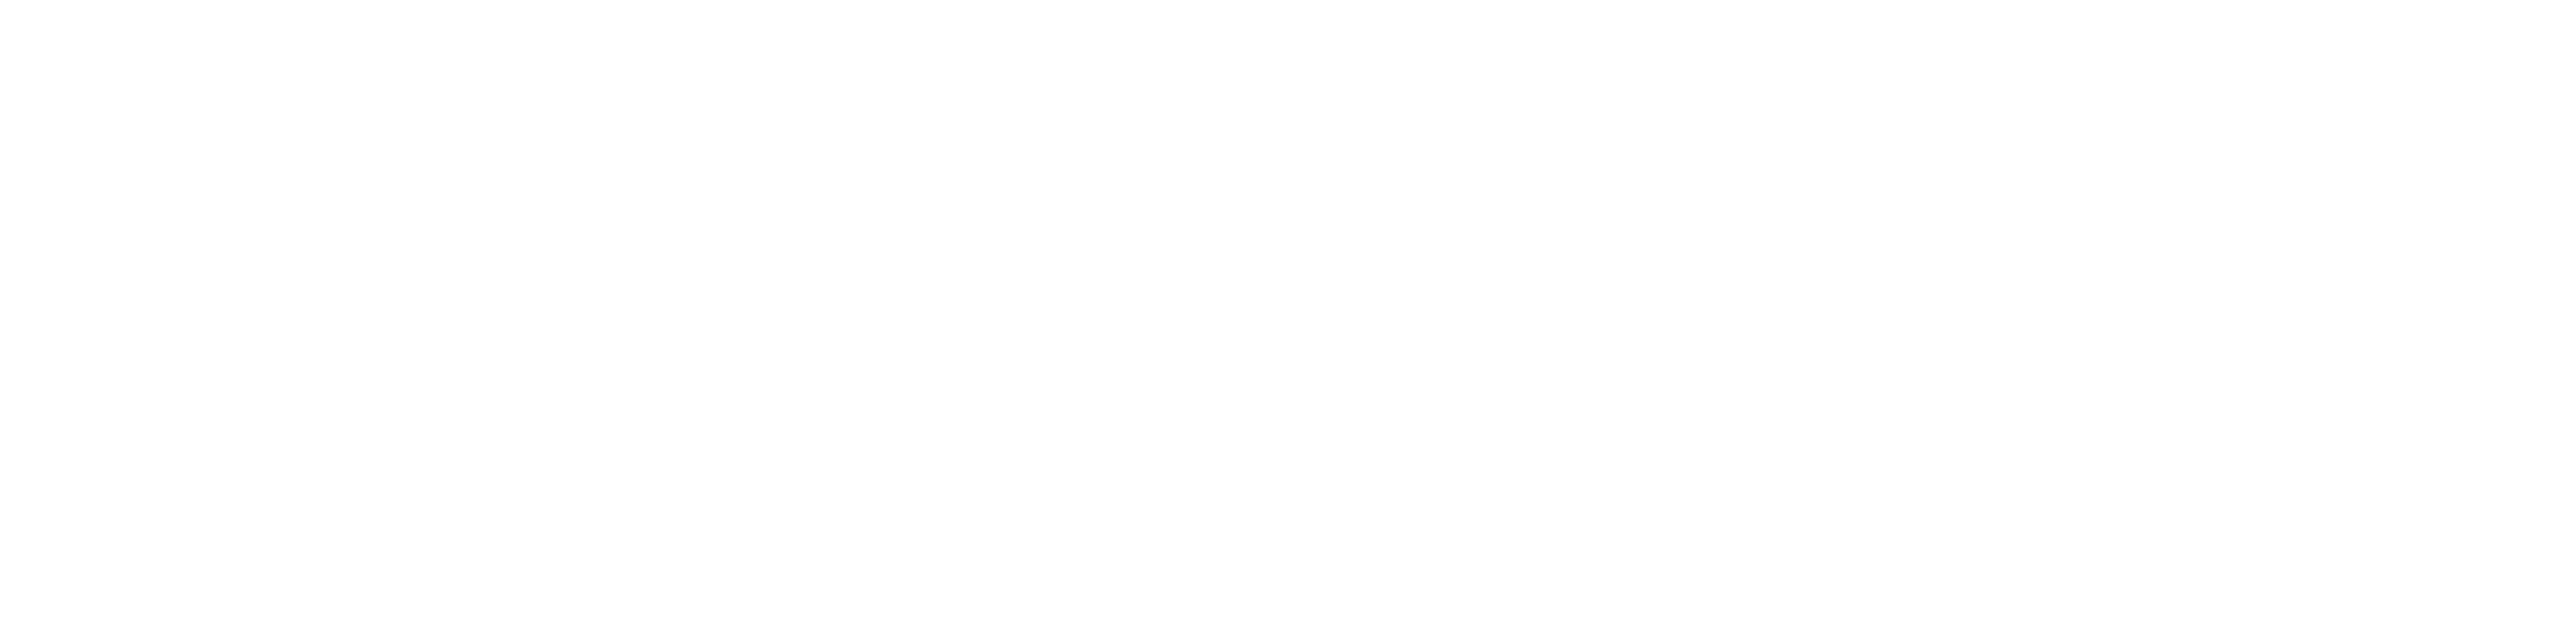

2020-05-29 13:15:58,987 logger INFO loss 1.16, 3D Dis:  7.38mm, poseDiff: 0.80, MemUsed:180.06
2020-05-29 13:16:09,310 logger INFO loss 1.16, 3D Dis:  7.40mm, poseDiff: 0.80, MemUsed:180.06
2020-05-29 13:16:20,065 logger INFO loss 1.16, 3D Dis:  7.41mm, poseDiff: 0.81, MemUsed:180.06
2020-05-29 13:16:30,512 logger INFO loss 1.16, 3D Dis:  7.43mm, poseDiff: 0.82, MemUsed:180.06
2020-05-29 13:16:41,240 logger INFO loss 1.16, 3D Dis:  7.44mm, poseDiff: 0.83, MemUsed:180.06


<IPython.core.display.Javascript object>


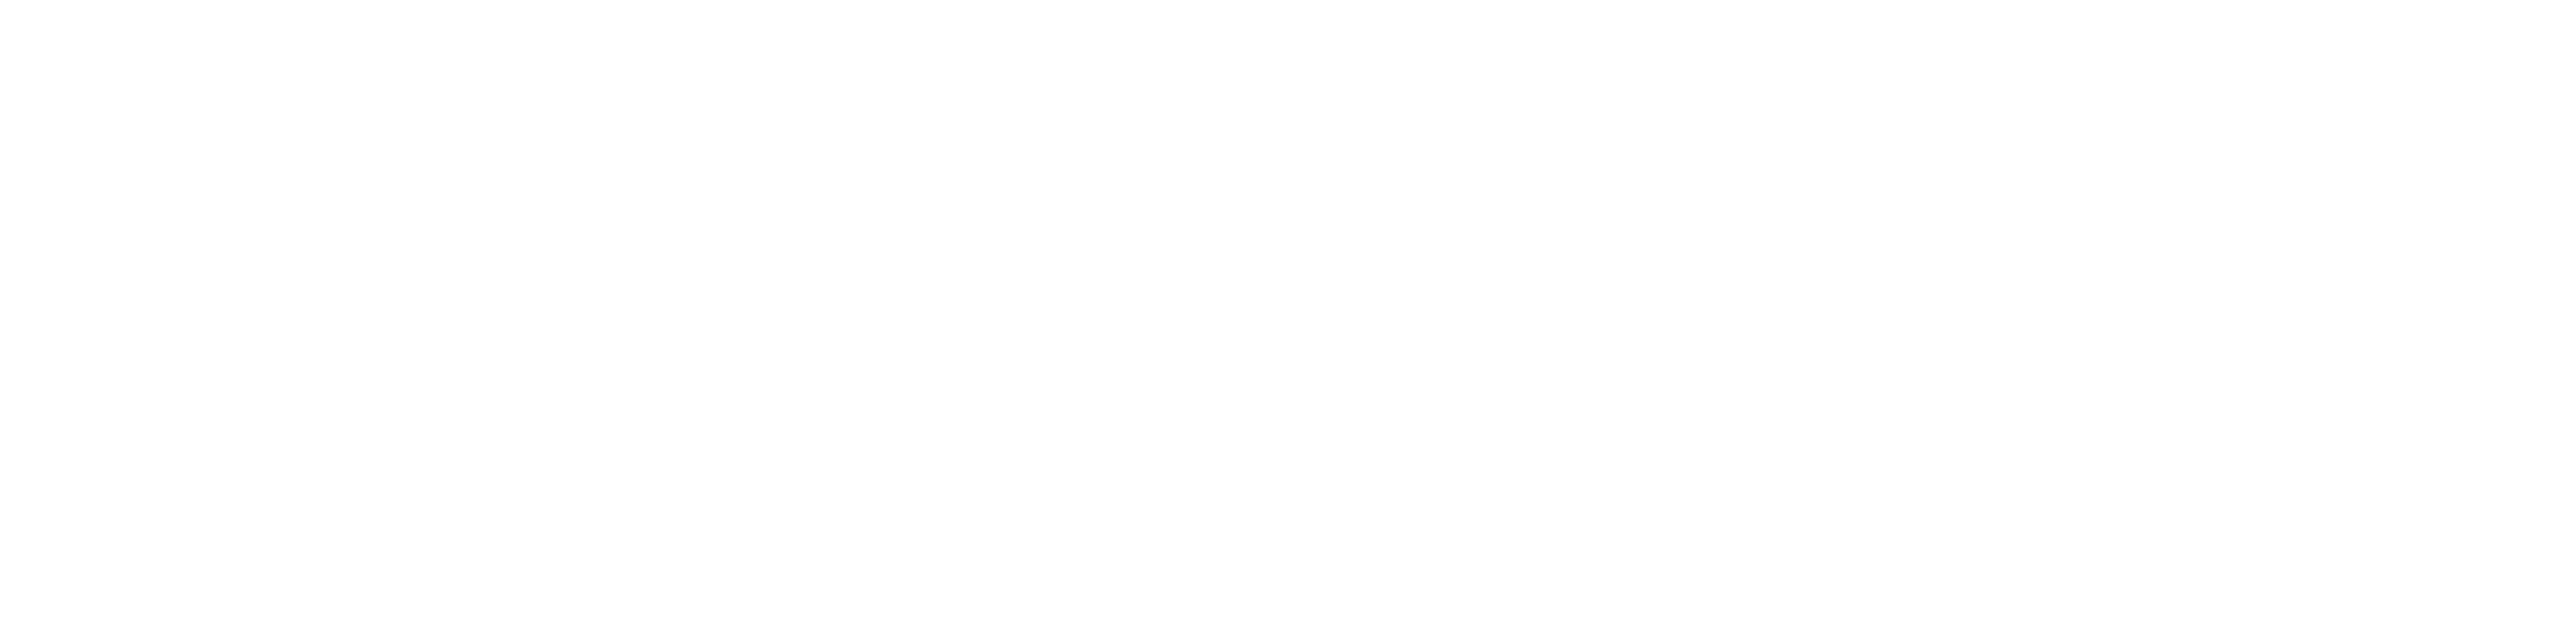

2020-05-29 13:17:15,127 logger INFO loss 1.16, 3D Dis:  7.46mm, poseDiff: 0.83, MemUsed:180.06
2020-05-29 13:17:25,365 logger INFO loss 1.16, 3D Dis:  7.47mm, poseDiff: 0.84, MemUsed:180.06
2020-05-29 13:17:35,685 logger INFO loss 1.16, 3D Dis:  7.49mm, poseDiff: 0.85, MemUsed:180.06
2020-05-29 13:17:45,870 logger INFO loss 1.16, 3D Dis:  7.50mm, poseDiff: 0.86, MemUsed:180.06
2020-05-29 13:17:56,272 logger INFO loss 1.16, 3D Dis:  7.52mm, poseDiff: 0.86, MemUsed:180.06


<IPython.core.display.Javascript object>


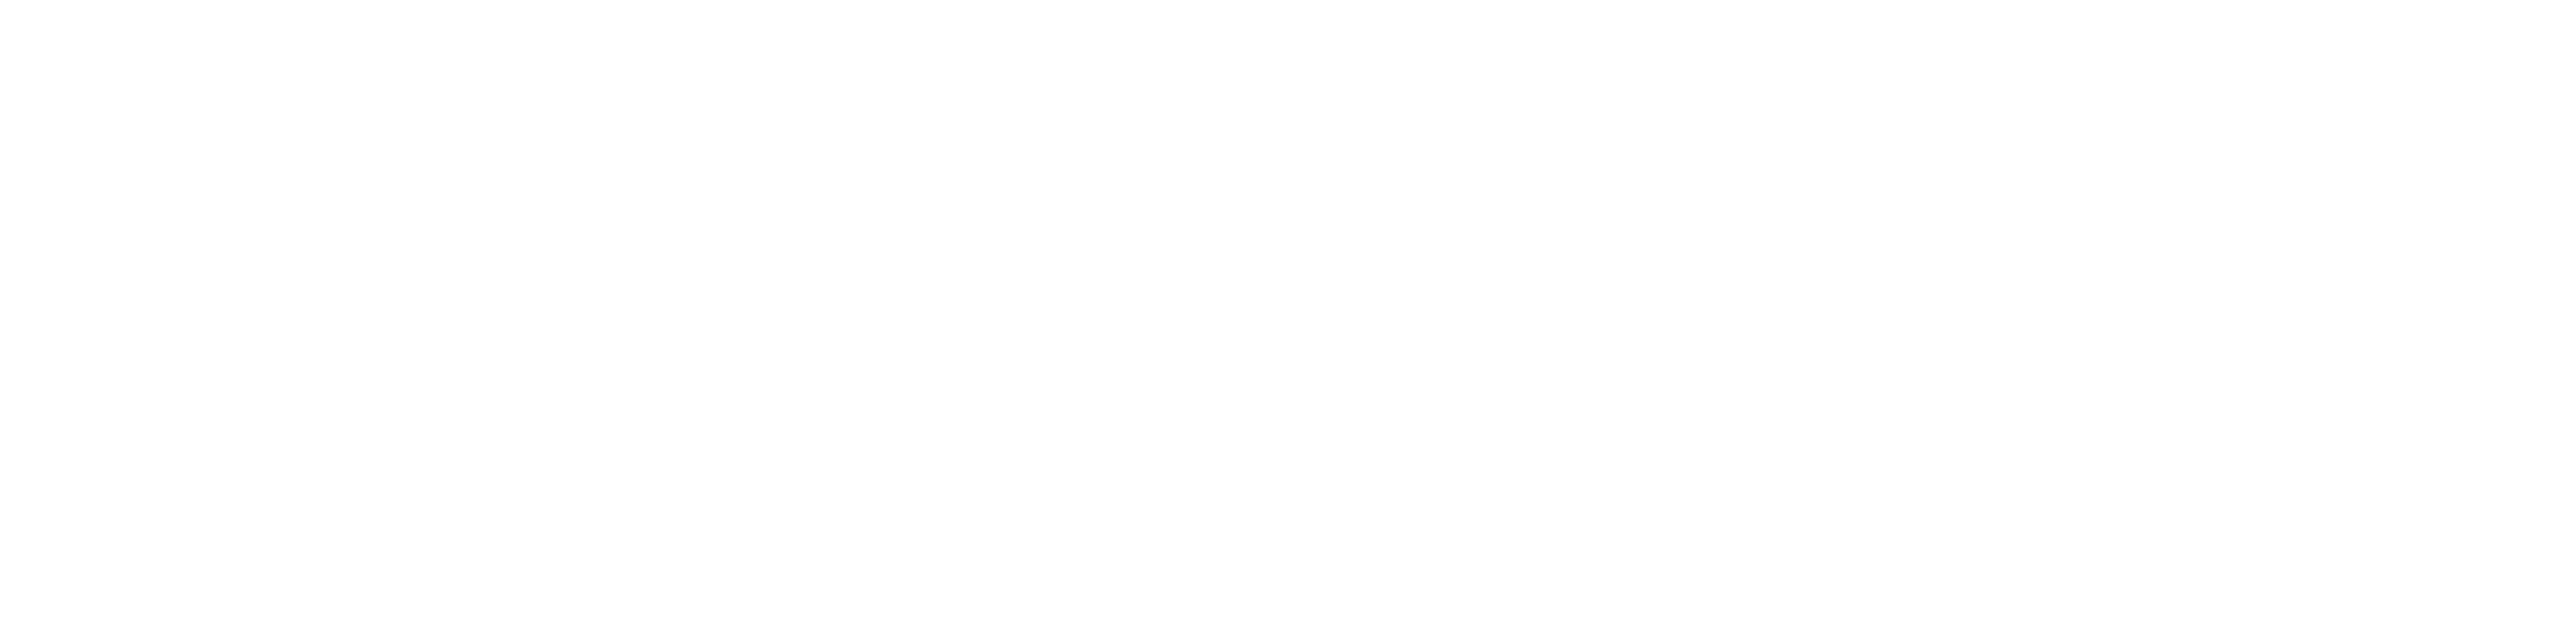

2020-05-29 13:18:30,084 logger INFO loss 1.16, 3D Dis:  7.53mm, poseDiff: 0.87, MemUsed:180.06
2020-05-29 13:18:40,499 logger INFO loss 1.16, 3D Dis:  7.55mm, poseDiff: 0.88, MemUsed:180.06
2020-05-29 13:18:51,092 logger INFO loss 1.16, 3D Dis:  7.56mm, poseDiff: 0.89, MemUsed:180.06
2020-05-29 13:19:01,866 logger INFO loss 1.16, 3D Dis:  7.58mm, poseDiff: 0.90, MemUsed:180.06
2020-05-29 13:19:12,552 logger INFO loss 1.16, 3D Dis:  7.60mm, poseDiff: 0.90, MemUsed:180.06


<IPython.core.display.Javascript object>


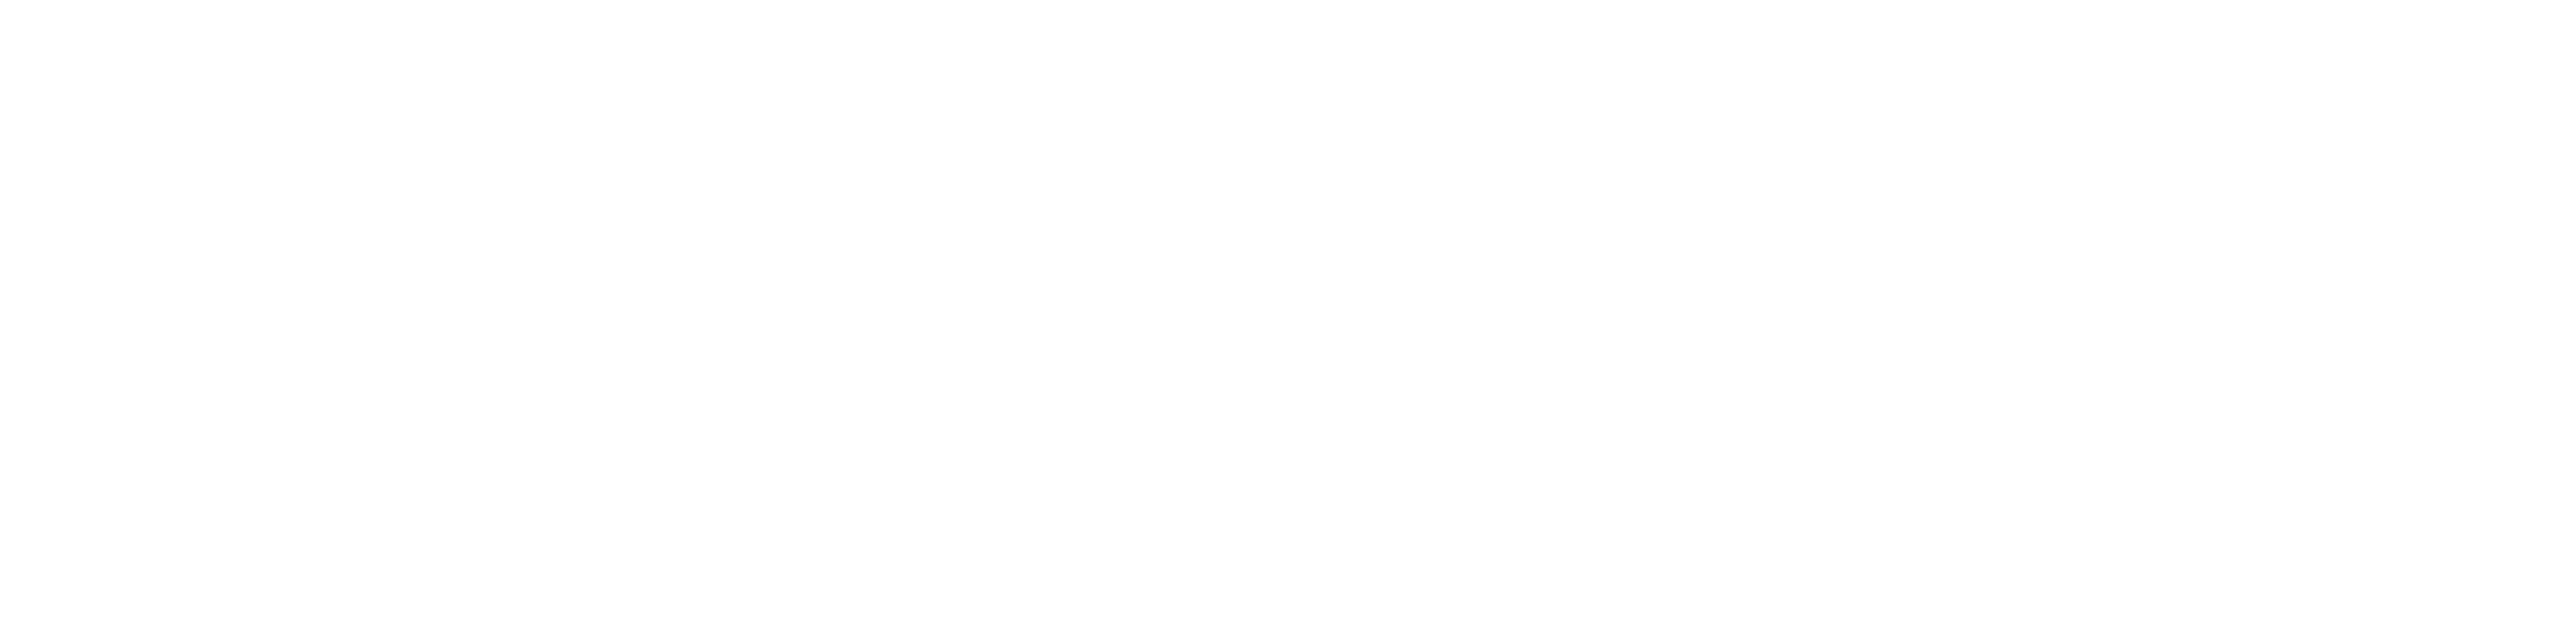

2020-05-29 13:19:46,295 logger INFO loss 1.16, 3D Dis:  7.61mm, poseDiff: 0.91, MemUsed:180.06
2020-05-29 13:19:56,831 logger INFO loss 1.16, 3D Dis:  7.63mm, poseDiff: 0.92, MemUsed:180.06
2020-05-29 13:20:07,422 logger INFO loss 1.16, 3D Dis:  7.65mm, poseDiff: 0.93, MemUsed:180.06
2020-05-29 13:20:17,831 logger INFO loss 1.16, 3D Dis:  7.68mm, poseDiff: 0.94, MemUsed:180.06
2020-05-29 13:20:28,201 logger INFO loss 1.16, 3D Dis:  7.70mm, poseDiff: 0.94, MemUsed:180.06


<IPython.core.display.Javascript object>


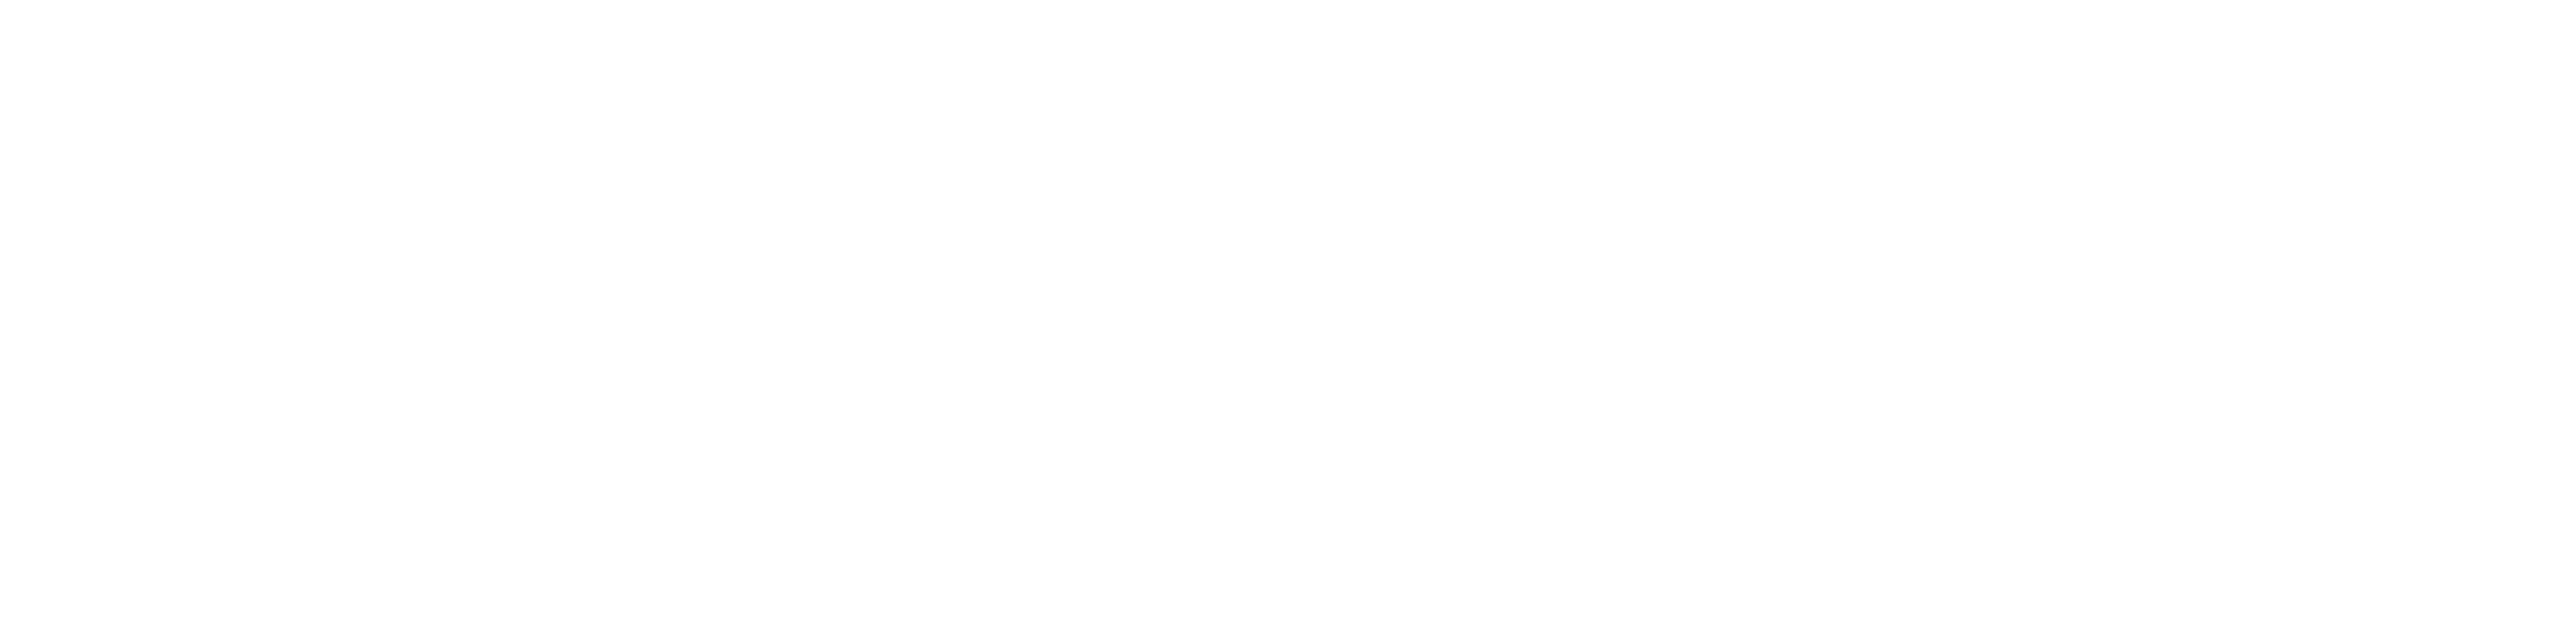

2020-05-29 13:21:01,188 logger INFO loss 1.16, 3D Dis:  7.72mm, poseDiff: 0.95, MemUsed:180.06
2020-05-29 13:21:11,277 logger INFO loss 1.16, 3D Dis:  7.74mm, poseDiff: 0.96, MemUsed:180.06
2020-05-29 13:21:21,652 logger INFO loss 1.16, 3D Dis:  7.76mm, poseDiff: 0.97, MemUsed:180.06
2020-05-29 13:21:31,977 logger INFO loss 1.16, 3D Dis:  7.77mm, poseDiff: 0.98, MemUsed:180.06
2020-05-29 13:21:42,531 logger INFO loss 1.16, 3D Dis:  7.79mm, poseDiff: 0.99, MemUsed:180.06


<IPython.core.display.Javascript object>


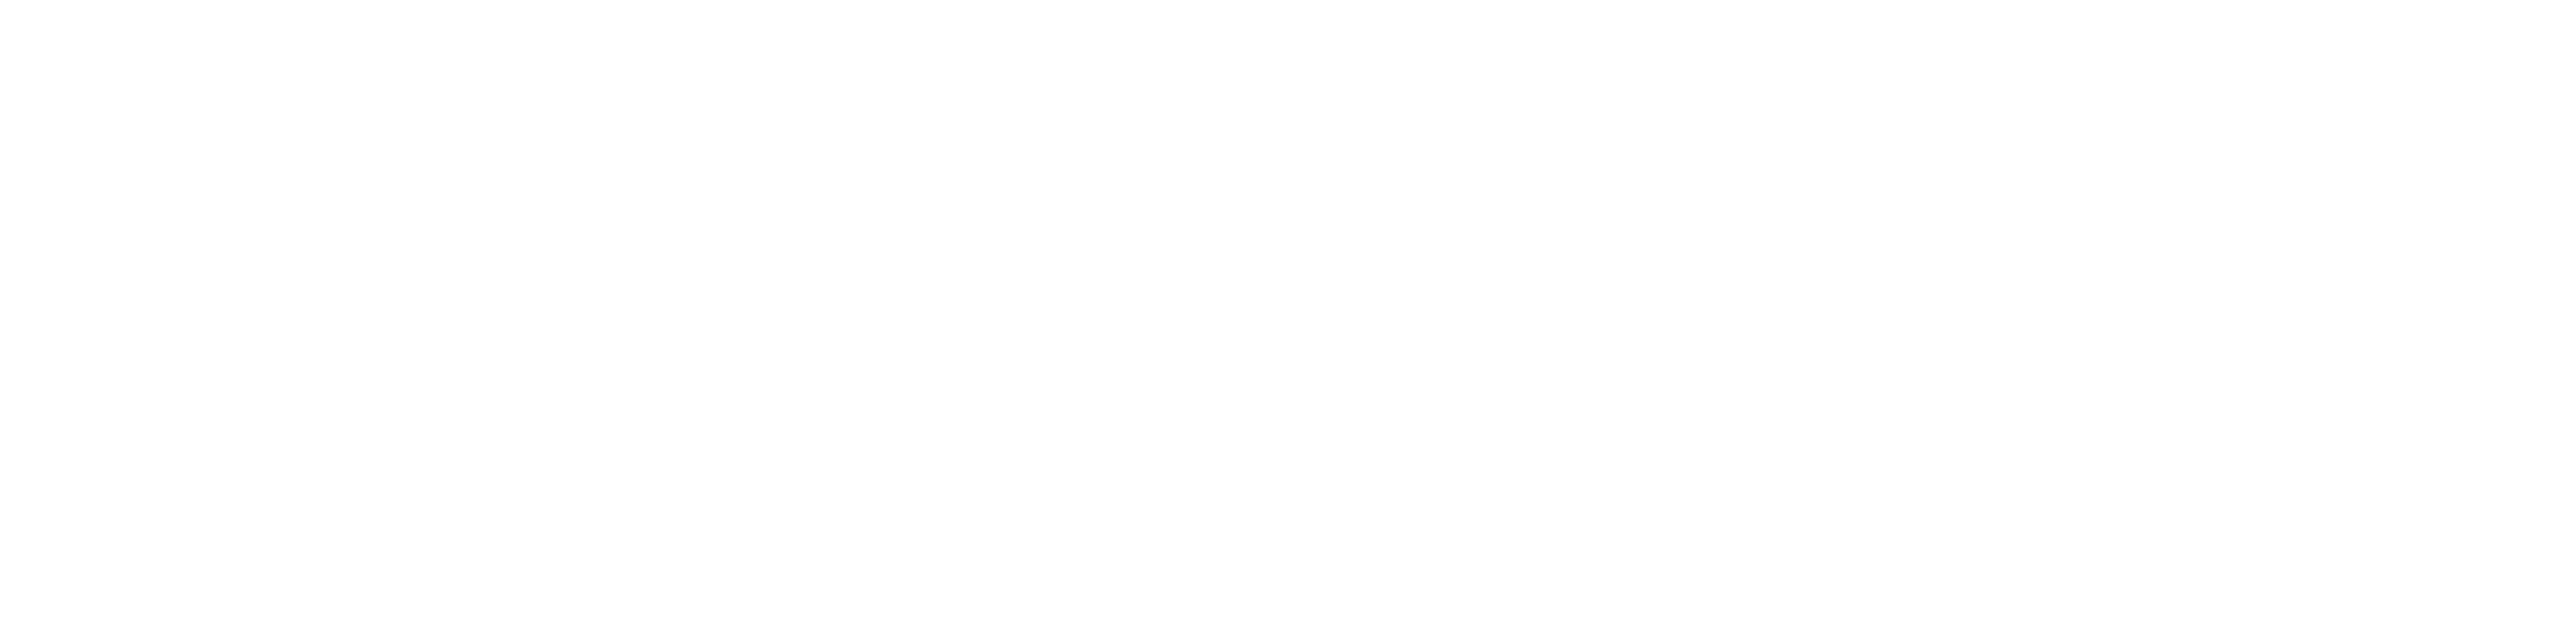

2020-05-29 13:22:15,777 logger INFO loss 1.16, 3D Dis:  7.81mm, poseDiff: 1.00, MemUsed:180.06
2020-05-29 13:22:25,712 logger INFO loss 1.16, 3D Dis:  7.82mm, poseDiff: 1.01, MemUsed:180.06
2020-05-29 13:22:36,020 logger INFO loss 1.16, 3D Dis:  7.84mm, poseDiff: 1.01, MemUsed:180.06
2020-05-29 13:22:46,289 logger INFO loss 1.16, 3D Dis:  7.85mm, poseDiff: 1.02, MemUsed:180.06
2020-05-29 13:22:56,529 logger INFO loss 1.16, 3D Dis:  7.87mm, poseDiff: 1.03, MemUsed:180.06


<IPython.core.display.Javascript object>


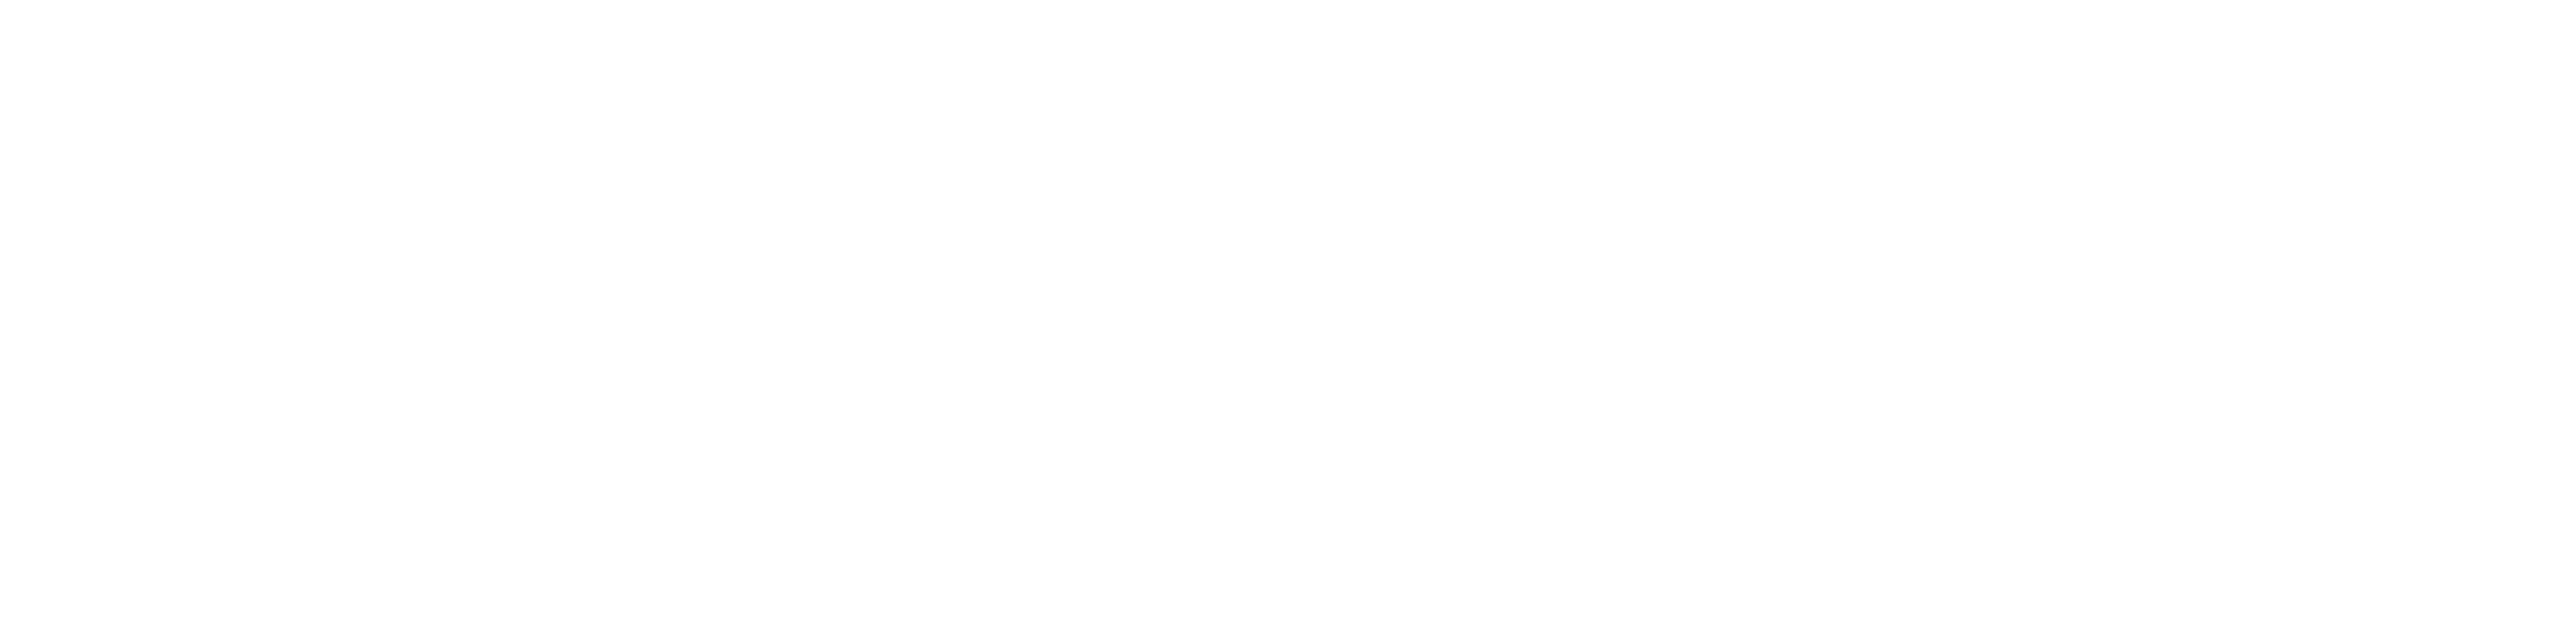

2020-05-29 13:23:29,685 logger INFO loss 1.16, 3D Dis:  7.88mm, poseDiff: 1.04, MemUsed:180.06
2020-05-29 13:23:39,696 logger INFO loss 1.16, 3D Dis:  7.89mm, poseDiff: 1.05, MemUsed:180.06
2020-05-29 13:23:49,838 logger INFO loss 1.15, 3D Dis:  7.91mm, poseDiff: 1.06, MemUsed:180.06
2020-05-29 13:24:00,225 logger INFO loss 1.15, 3D Dis:  7.91mm, poseDiff: 1.07, MemUsed:180.06
2020-05-29 13:24:10,669 logger INFO loss 1.15, 3D Dis:  7.92mm, poseDiff: 1.08, MemUsed:180.06


<IPython.core.display.Javascript object>


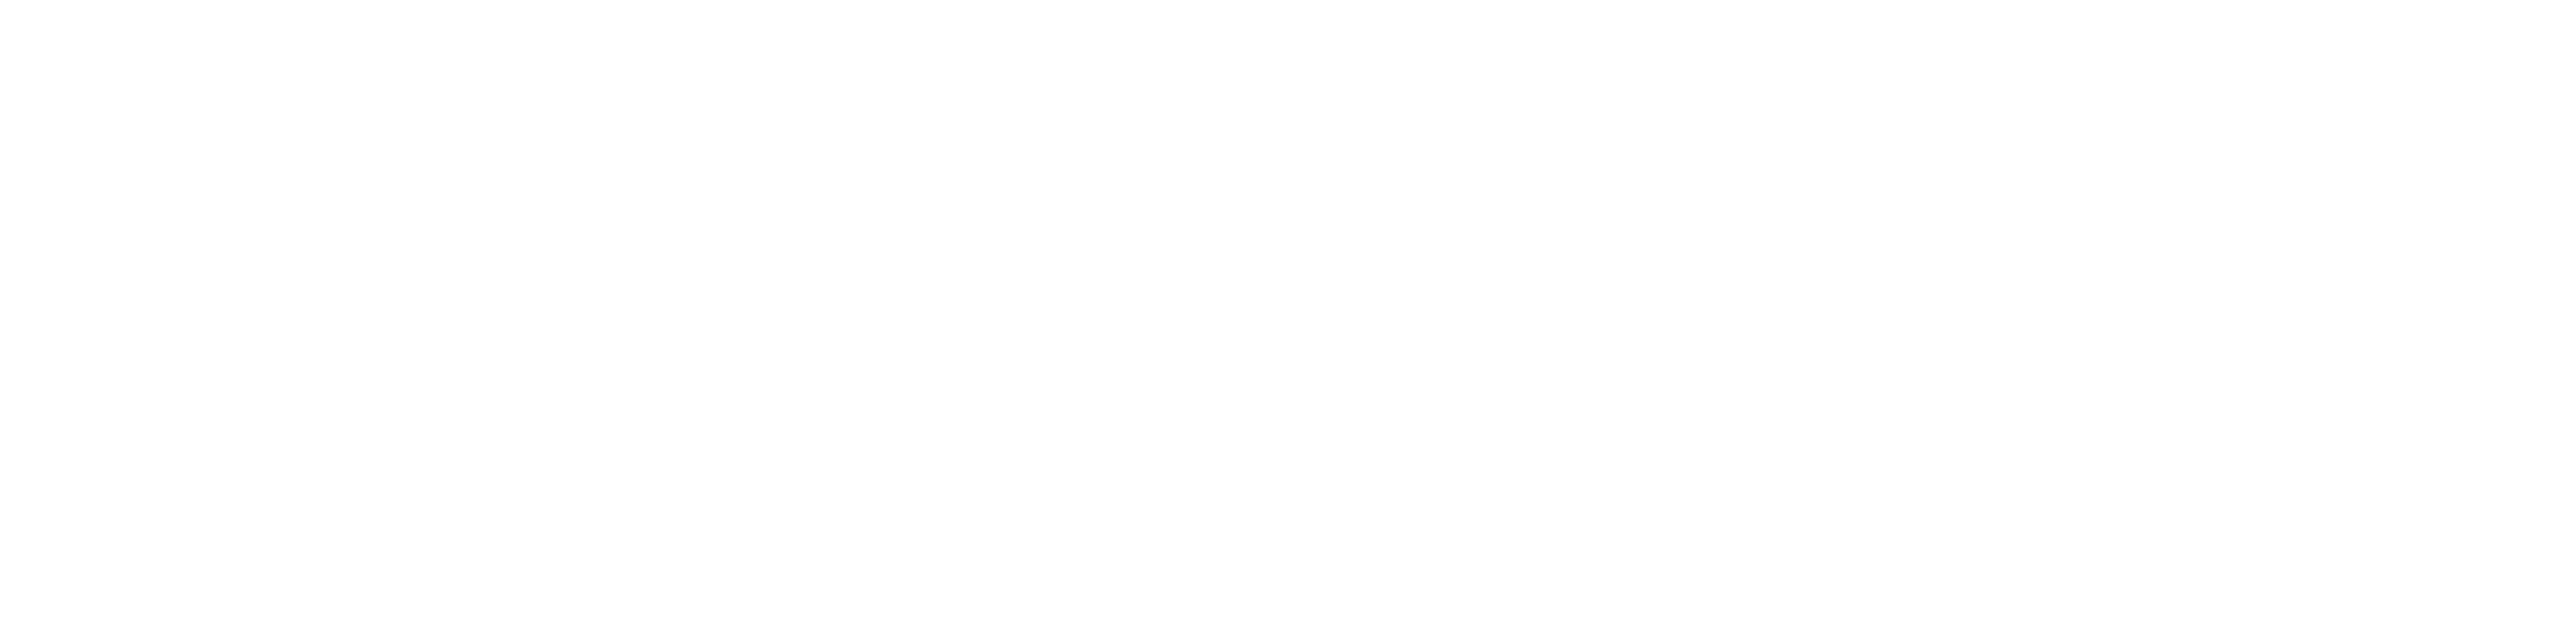

2020-05-29 13:24:43,618 logger INFO loss 1.15, 3D Dis:  7.93mm, poseDiff: 1.09, MemUsed:180.06
2020-05-29 13:24:56,121 logger INFO loss 1.15, 3D Dis:  7.94mm, poseDiff: 1.10, MemUsed:180.06
2020-05-29 13:25:06,422 logger INFO loss 1.15, 3D Dis:  7.96mm, poseDiff: 1.11, MemUsed:180.06
2020-05-29 13:25:16,729 logger INFO loss 1.15, 3D Dis:  7.97mm, poseDiff: 1.11, MemUsed:180.06
2020-05-29 13:25:27,274 logger INFO loss 1.15, 3D Dis:  7.98mm, poseDiff: 1.12, MemUsed:180.06


<IPython.core.display.Javascript object>

In [ ]:
loop = tqdm_notebook(range(cfg.numIterations))
for i in loop:
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    if cfg.bodyJointOnly:
#         poseHands = pose[numBodyParameters:].clone().detach()
        posePerturbed = torch.cat([poseParams, poseHands])
    else:
        posePerturbed = poseParams
    lossVal = 0
    for iCam in range(cfg.numCams):
        vertsPerturbed = smplsh(betas, posePerturbed, trans).type(torch.float32)
        smplshMeshPerturbed = Meshes([vertsPerturbed], [smplsh.faces.to(device)], textures=textures)
        R=camRTs[iCam]['R']
        T=camRTs[iCam]['T']
        
        refImg = torch.tensor(refImgs[iCam][..., 3], dtype=torch.float64, device=device, requires_grad=False)
        images = renderSynth.renderer(smplshMeshPerturbed,  R=R, T=T)

#         loss = torch.sum((refImg - images[..., 3]) ** 2) / cfg.numCams
        loss = 1 - torch.norm(refImg * images[..., 3], p=1) / torch.norm(refImg + images[..., 3] - refImg * images[..., 3], p=1)

        loss.backward()
        lossVal += loss.item()
    
    # targetImg = images[0, ..., :3]
    # loss, _ = model()
    
    # recordData
    losses.append(lossVal)
    poses.append(posePerturbed.cpu().detach().numpy())
    
#     for cam in cameras:
#         image = render(...)
#     loss.backward()
        
    optimizer.step()
    memStats = torch.cuda.memory_stats(device=device)
    memAllocated =  memStats['active_bytes.all.current'] / 1000000
    
    dis3D = vertsPerturbed.cpu().detach().numpy() - verts.cpu().numpy()
    dis3D = np.mean(np.sqrt(dis3D[:,0]**2 + dis3D[:,1]**2 + dis3D[:,2]**2))
    
    infoStr = 'loss %.2f, 3D Dis:  %.2fmm, poseDiff: %.2f, MemUsed:%.2f' \
        % (lossVal, dis3D*1000, torch.sum((pose-posePerturbed)**2).item(), memAllocated)
    
    loop.set_description(infoStr)
    logger.info(infoStr)
    
    if lossVal < cfg.terminateLoss:
        break
    
    # Save outputs to create a GIF. 
    if i % cfg.plotStep == 0:
        # R = look_at_rotation(model.camera_position[None, :], device=model.device)
        # T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        # image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        # image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        # image = img_as_ubyte(image)
        # writer.append_data(image)
        torch.cuda.empty_cache()
        plt.close('all')
        
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        images = renderMesh(camRTs, cfg, smplshMeshPerturbed, renderSynth)
        visualize2DResults(images, refImgs, cfg, outImgFile)
        
        saveVTK(join(outFolderMesh, 'Fit' + str(i).zfill(5) + '.vtk'), vertsPerturbed.cpu().detach().numpy(), smplshExampleMesh)
